# Laboratory LCA of Hydrothermal Carbonization  
This Jupyter notebook is for conducting an explaratory life cycle accessment (LCA) analysis to identify areas of sensitivity and further determine the optimal or most favorable conditions for upscaling hydrothermal carbonization (HTC) under deep uncertainty. This notebook is organized in three sections: 
1) Project Setup: Importing main packages & ecoinvent databases 
2) Baseline LCA Model: Developing a baseline LCA model for evaluating environmental impacts across 3 normalization categories.  
3) Multi-Objective Baseline LCA: Viewing baseline LCA results from multiple objectives to determine optimal conditions for HTC. 
4) Uncertainty Analysis: Conducting uncertainty analysis and calculating a coefficient of variation to determine the impacts of variability and random, aleatoric uncertainty to provide insights for upscaling and decision making. 
5) Supplementary Information: Archive visualizations and additional code for further analysis developed during earlier stages of development.  

This notebook serves as a supplementary analysis to the manuscript, <i>Attributional Life Cycle Analysis Approach to Hydrothermal Carbonization of Food Waste to Guide Environmentally-Motivated Biorefinery Decision-Making</i>. Refer to the README file for a detailed set of instructions on requirements and infrastructure needed for setting up the coding environment. 

## 1: Project Setup
Installing required packages, setting up projects, and importing ecoinvent databases. Be sure to activate the virtual environment and install requirements.txt.  

In [1]:
# Installing main packages
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import re
import copy
import seaborn as sns

In [2]:
# Importing BW2 packages
import brightway2 as bw
from bw2data.parameters import ProjectParameter, ParameterManager, ActivityParameter

In [3]:
# Import BW25 packages. 
import bw2data as bd
import bw2io as bi
import bw2calc as bc
import bw2analyzer as bwa

In [4]:
# Creating a new project: HTC-uncertainty 
bd.projects.set_current('HTC-uncertainty')

In [8]:
# Installing biosphere flows 
bi.bw2setup()

Creating default biosphere

Applying strategy: normalize_units
Applying strategy: drop_unspecified_subcategories
Applying strategy: ensure_categories_are_tuples
Applied 3 strategies in 0.01 seconds
Title: Writing activities to SQLite3 database:
  Started: 09/24/2024 15:32:48
  Finished: 09/24/2024 15:32:48
  Total time elapsed: 00:00:00
  CPU %: 102.10
  Memory %: 0.24
Created database: biosphere3
Creating default LCIA methods

Wrote 762 LCIA methods with 227223 characterization factors
Creating core data migrations



In [5]:
# Getting main folder with ecoinvent files. Replace this with your own directory.  
def get_ecoinvent_directory(): 
    return "../../ecoinvent_v3.10"

In [6]:
# Helper function to write data to a database
def write_data(ei_path, ei_name): 
    if ei_name in bd.databases:
        print("Database has already been imported.")
    else:
        ei_importer = bi.SingleOutputEcospold2Importer(ei_path, ei_name, use_mp = False)
        # Should you have a problem with "unlinked exchanges"
        try: 
            ei_importer.add_unlinked_flows_to_biosphere_database() 
        except Exception as e:
            print(f"An error occurred: {e}")
        ei_importer.apply_strategies()
        ei_importer.statistics()
        ei_importer.write_database()
        print(str(ei_name) + " database is completed!")

In [7]:
def create_databases():
    for folder in os.listdir(get_ecoinvent_directory()):
        folder_path = os.path.join(get_ecoinvent_directory(), folder + "/datasets")
        # Only using cutoff for this analysis 
        if os.path.isdir(folder_path) and 'cutoff' in folder:
            write_data(folder_path, folder_path.split('\\')[-1])
    print(bd.databases)

In [8]:
create_databases()

100%|██████████| 23523/23523 [03:05<00:00, 126.80it/s]


Extracted 23523 datasets in 185.73 seconds


100%|██████████| 5769/5769 [00:00<00:00, 17779.63it/s]


Vacuuming database 
Applying strategy: link_iterable_by_fields
Applying strategy: normalize_units
Applying strategy: update_ecoinvent_locations
Applying strategy: remove_zero_amount_coproducts
Applying strategy: remove_zero_amount_inputs_with_no_activity
Applying strategy: remove_unnamed_parameters
Applying strategy: es2_assign_only_product_with_amount_as_reference_product
Applying strategy: assign_single_product_as_activity
Applying strategy: create_composite_code
Applying strategy: drop_unspecified_subcategories
Applying strategy: fix_ecoinvent_flows_pre35
Applying strategy: drop_temporary_outdated_biosphere_flows
Applying strategy: link_biosphere_by_flow_uuid
Applying strategy: link_internal_technosphere_by_composite_code
Applying strategy: delete_exchanges_missing_activity
Applying strategy: delete_ghost_exchanges
Applying strategy: remove_uncertainty_from_negative_loss_exchanges
Applying strategy: fix_unreasonably_high_lognormal_uncertainties
Applying strategy: convert_activity_pa

100%|██████████| 23523/23523 [01:05<00:00, 358.21it/s]


Vacuuming database 
Created database: ../../ecoinvent_v3.10/cutoff/datasets
../../ecoinvent_v3.10/cutoff/datasets database is completed!
Databases dictionary with 2 object(s):
	../../ecoinvent_v3.10/cutoff/datasets
	biosphere3


In [8]:
# Ensuring cutoff database has been imported correctly
bd.databases

Databases dictionary with 2 object(s):
	../../ecoinvent_v3.10/cutoff/datasets
	biosphere3

In [9]:
# Creating database reference to not override or intefere with cutoff model: 
# eidb = bd.Database("cutoff/datasets")
eidb = bd.Database("../../ecoinvent_v3.10/cutoff/datasets")

In [10]:
# Creating database reference to not override or intefere with the biosphere model: 
biosphere3 = bw.Database('biosphere3')

In [11]:
# Checking for proper replication: 
print("The imported ecoinvent database is of type {} and has a length of {}.".format(type(eidb), len(eidb)))

The imported ecoinvent database is of type <class 'bw2data.backends.base.SQLiteBackend'> and has a length of 23649.


In [12]:
# Checking for proper replication of biosphere database 
print("The biosphere database is of type {} and has a length of {}.".format(type(biosphere3), len(biosphere3)))

The biosphere database is of type <class 'bw2data.backends.base.SQLiteBackend'> and has a length of 5769.


In [14]:
# If needed, migrate the project to Brightway2.5
bd.projects.migrate_project_25()

Updating all LCIA methods


762it [01:41,  7.49it/s]


Updating all LCI databases


2it [00:24, 12.06s/it]


In [13]:
# Ensure that LCIA is working as intended. This code snippet should yield the following result assuming ecoinvent v3.10, as of August 2024. 
# The market group for electricity, low voltage process accounts for 0.494706 kg CO2-Eq.
# Refer to https://ecoquery.ecoinvent.org/

act = [act for act in eidb if 'market group for electricity, low voltage' in act['name']  and 'US' in act['location']][0]
functional_unit = { act: 1}
method_key = [m for m in bw.methods if 'TRACI' in str(m) and 'global warming' in str(m)][0]
lca = bw.LCA(functional_unit, method_key)
lca.lci()
lca.lcia()
print("The {} process accounts for {:f} {}.".format(
    list(functional_unit.keys())[0]['name'],
    lca.score,
    bw.methods.get(method_key).get('unit')
))

The market group for electricity, low voltage process accounts for 0.494706 kg CO2-Eq.


In [ ]:
# Now that the project returns the proper results, backup the project directory
# Optional, but recommended step 
bi.backup.backup_project_directory(
    project='HTC-uncertainty',
    dir_backup='../project-data/lab-HTC'
)

## 2: Baseline LCA
Conducting a baseline LCA, as a foreground system for determining environmental impacts for main feedstocks based on numerical averages. The feedstocks of interest are as follows:  
 - SRU Feedstock with water to reach an 85% moisture content
 - BSG Feedstock with water to reach at 85% moisture content
 - DCW Feedstock (already above 85% moisture content; no additional water needed)

### 2.1: Identifying Appropriate Flows
All hydrothermal carbonization models have the following inputs: 
1) Feedstock: It will be assumed that the feedstock is a waste product and has no corresponding environmental impacts. The process of transporting food waste is not considered for this analysis.  
2) Water: If needed, water is added to reach a moisture content. If not needed, water is 0. 
3) Electricity: Needed for stirring of an HTC reaction & for post-processing. 
4) Heat: Needed for the HTC reaction and post-processing steps. 
It will be assumed that the equipment itself has a long lifetime and any pre-processing for the equipment or environmental impacts for setting up or maintaining a system will not be explored in this analysis. 

Simultaneously, all hydrothermal carbonization models have the following outputs: 
1. Hydrochar (functional unit): The goal of this analysis is to determine the optimal method for producing a solid hydrochar (HC).  
2. Carbon Dioxde: Gas yields from HTC are assumed to be pure CO<sub>2</sub> are emitted to the atmosphere. 
3. Wastewater: Process Water from the HTC process that requires treatment at a wastewater treatment plant. 

In [14]:
# Searching for Electricity
for act in [act for act in eidb if 'market group for electricity, low voltage' in act['name']  and 'US' in act['location']]:
    print(act)

'market group for electricity, low voltage' (kilowatt hour, US, None)


In [15]:
# Assuming Heat uses the same source as electricity, based on Parr reactor specifications
# https://www.parrinst.com/products/stirred-reactors/series-4520-1-2l-bench-top-reactors/specifications/

for act in [act for act in eidb if 'market group for electricity, low voltage' in act['name']  and 'US' in act['location']]:
    print(act)

'market group for electricity, low voltage' (kilowatt hour, US, None)


In [16]:
# Searching for Water 
for act in [act for act in eidb if 'market for water, completely softened' in act['name']  and 'US' in act['location']]:
    print(act)

'market for water, completely softened' (kilogram, US, None)


In [17]:
# Searching for Wastewater 
for act in [act for act in eidb if 'treatment of wastewater, average, wastewater treatment' in act['name']  and 'RoW' in act['location']]:
    print(act)

'treatment of wastewater, average, wastewater treatment' (cubic meter, RoW, None)


In [18]:
# Searching for Carbon Dioxide Stream; in this case the second option is of interest.  
for flow in [flow for flow in biosphere3 if 'carbon dioxide, non-fossil, resource correction' in flow['name'].lower()]:
    print(flow)

'Carbon dioxide, non-fossil, resource correction' (kilogram, None, ('natural resource', 'in air'))
'Carbon dioxide, non-fossil, resource correction' (kg, None, None)


### 2.2: Setting Up Product System
Creating product systems for main feedstocks

In [19]:
from feedstock import Feedstock, FeedstockManager, create_elementary_feedstocks
from model import get_feedstock_quantity, get_water_quantity, get_heat_needed, get_electricity_needed
from model import  get_co2_emissions, get_pw, get_parameter, get_post_processing, split_reactor_conditions

In [20]:
# If needed, delete existing parameters
for item in ProjectParameter.select(): 
    item.delete()

ProjectParameter.drop_table(safe=True, drop_sequences=True)
# create a new empty table of project parameters
ProjectParameter.create_table()

for name in ProjectParameter.select():
    name.print()

In [21]:
# If needed, delete existing activities
for act in [act for act in eidb if 'hydrochar production' in act['name']]:
    act.delete()
    
for act in [act for act in eidb if 'hydrochar production' in act['name']]:
    print(act)

In [22]:
# Re initializing elementary feedstocks if needed
elementary_feedstocks = create_elementary_feedstocks()

In [23]:
def create_hydrochar_activity(feedstock: Feedstock):
    '''Creates a hydrochar activity, given a feedstock'''
    temp = feedstock.temp
    time = feedstock.time 
    hydrochar_production = eidb.new_activity(
        code=f'HTC_{feedstock.name}_{temp}C_{time}hr',
        name=f"hydrochar production, {feedstock.name}_{temp}C_{time}hr",
        location='US',
        unit="kg"
    )
    parameters = ParameterManager()
    yield_HC = get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'HC_yield')
    gas_yield = get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'gas_yield')
    project_data = [
        {
            'name': 'feedstock_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_feedstock_quantity(yield_HC, feedstock)
        }, 
        {
            'name': 'water_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_water_quantity(yield_HC, feedstock)
        }, 
        {
            'name': 'heat_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_heat_needed(feedstock, temp, time)
        },
        {
            'name': 'electricity_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_electricity_needed(feedstock, time, temp)
        }, 
        {
            'name': 'co2_' + f'HTC_{feedstock.name}_{temp}C_{time}hr',
            'amount': get_co2_emissions(yield_HC, gas_yield, feedstock)
        }, 
        {
            'name': 'wastewater_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_pw(yield_HC, gas_yield, feedstock, hc_placeholder=1)
        },
        {
            'name': 'post_processing_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_post_processing(hc_placeholder=1)
        }
    ]
    
    print(project_data)
    parameters.new_project_parameters(project_data)
    
    # for param in ProjectParameter.select():
    #     print(param, param.amount)
    
    # Feedstock 
    hydrochar_production.new_exchange(input=('biosphere3', 'feedstock'), amount=0, unit="kg", type='custom', formula= 'feedstock')
    hydrochar_production.save()
                        
    # Water 
    water = [act for act in eidb if 'market for water, completely softened' in act['name']  and 'US' in act['location']][0]
    hydrochar_production.new_exchange(input=water.key, amount=0, unit="kilogram", type='technosphere', 
                                        formula= 'water_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
    hydrochar_production.save()
    
    # Electricity
    electricity = [act for act in eidb if 'market group for electricity, low voltage' in act['name']  and 'US' in act['location']][0]
    hydrochar_production.new_exchange(input=electricity.key, amount=0, unit="kilowatt hour", type='technosphere', 
                                        formula='electricity_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
    hydrochar_production.save()
    
    # Heat 
    electricity = [act for act in eidb if 'market group for electricity, low voltage' in act['name']  and 'US' in act['location']][0]
    hydrochar_production.new_exchange(input=electricity.key, amount=0, unit="kilowatt hour", type='technosphere', 
                                        formula='heat_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
    hydrochar_production.save()
    
    # CO2 Emissions
    co2 = [flow for flow in biosphere3 if 'carbon dioxide, non-fossil, resource correction' in flow['name'].lower()][1]
    hydrochar_production.new_exchange(input=co2.key, amount=0, unit="kilogram", type='biosphere', 
                                        formula='-1*co2_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
    hydrochar_production.save()
    
    # Wastewater 
    wastewater = [act for act in eidb if 'treatment of wastewater, average, wastewater treatment' in act['name']  and 'RoW' in act['location']][0]
    hydrochar_production.new_exchange(input=wastewater.key, amount=0, unit="cubic meter", type='technosphere', 
                                        formula='-1*wastewater_' + f'HTC_{feedstock.name}_{temp}C_{time}hr/1000').save()
    hydrochar_production.save()
    
    # Post-Processing
    electricity = [act for act in eidb if 'market group for electricity, low voltage' in act['name']  and 'US' in act['location']][0]
    hydrochar_production.new_exchange(input=electricity.key, amount=0, unit="kilowatt hour", type='technosphere', 
                                        formula='post_processing_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
    hydrochar_production.save()
    
    parameters.add_exchanges_to_group(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", hydrochar_production)
    ActivityParameter.recalculate_exchanges(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr")
    print()        

In [24]:
# Creating Activities for Different Feedstocks 
excluded_feedstocks = {"rawSRU", "rawBSG"}
for attr, feedstocks in elementary_feedstocks.__dict__.items():
    for feedstock in feedstocks:
        if feedstock.name not in excluded_feedstocks:
            create_hydrochar_activity(feedstock)

[{'name': 'feedstock_HTC_stdSRU_190C_1hr', 'amount': 4.405149378057423}, {'name': 'water_HTC_stdSRU_190C_1hr', 'amount': 1.4013095047525619}, {'name': 'heat_HTC_stdSRU_190C_1hr', 'amount': 1.802243989661737}, {'name': 'electricity_HTC_stdSRU_190C_1hr', 'amount': 0.052881176818981995}, {'name': 'co2_HTC_stdSRU_190C_1hr', 'amount': 0.013643627895201066}, {'name': 'wastewater_HTC_stdSRU_190C_1hr', 'amount': 4.792815254914784}, {'name': 'post_processing_HTC_stdSRU_190C_1hr', 'amount': 0.403}]

[{'name': 'feedstock_HTC_stdSRU_190C_3hr', 'amount': 3.902283644770988}, {'name': 'water_HTC_stdSRU_190C_3hr', 'amount': 1.2413443205572885}, {'name': 'heat_HTC_stdSRU_190C_3hr', 'amount': 3.9700552622566088}, {'name': 'electricity_HTC_stdSRU_190C_3hr', 'amount': 0.12378628909107907}, {'name': 'co2_HTC_stdSRU_190C_3hr', 'amount': 0.019413962826294342}, {'name': 'wastewater_HTC_stdSRU_190C_3hr', 'amount': 4.124214002501982}, {'name': 'post_processing_HTC_stdSRU_190C_3hr', 'amount': 0.403}]

[{'name': 

In [25]:
# Cross Checking Exchanges 
for act in [act for act in eidb if 'hydrochar production' in act['name']]:
    print(act)
    for exc in act.exchanges():
        print(exc)
    print()

'hydrochar production, rawDCW_190C_1hr' (kg, US, None)
Exchange: 0.0 kilogram 'market for water, completely softened' (kilogram, US, None) to 'hydrochar production, rawDCW_190C_1hr' (kg, US, None)>
Exchange: 0.5254175586964392 kilowatt hour 'market group for electricity, low voltage' (kilowatt hour, US, None) to 'hydrochar production, rawDCW_190C_1hr' (kg, US, None)>
Exchange: 17.080005283678084 kilowatt hour 'market group for electricity, low voltage' (kilowatt hour, US, None) to 'hydrochar production, rawDCW_190C_1hr' (kg, US, None)>
Exchange: -0.12118516960108892 kg 'Carbon dioxide, non-fossil, resource correction' (kg, None, None) to 'hydrochar production, rawDCW_190C_1hr' (kg, US, None)>
Exchange: -0.0816883782605723 cubic meter 'treatment of wastewater, average, wastewater treatment' (cubic meter, RoW, None) to 'hydrochar production, rawDCW_190C_1hr' (kg, US, None)>
Exchange: 0.403 kilowatt hour 'market group for electricity, low voltage' (kilowatt hour, US, None) to 'hydrochar p

### 2.3: Testing Baseline LCIA 
Ensuring that Life Cycle Impact Assessments work with Brightway2.5 for one impact category & one metric for the functional unit of 1 gram of hydrochar produced.  

In [26]:
# Testing with TRACI v 2.1 no long-term (no LT) climate change impact assessment category for a random feedstock + reactor condition. 
method_key = [m for m in bw.methods if 'TRACI' in str(m) and 'global warming' in str(m)][0]
activity = [act for act in eidb if 'hydrochar production' in act['name']][5]
functional_unit = { activity:1e-3}

In [27]:
lca = bw.LCA(functional_unit, method_key)

In [28]:
lca.lci()
lca.lcia()

In [29]:
lca.demand

{29305: 0.001}

In [30]:
lca.method

('TRACI v2.1 no LT',
 'climate change no LT',
 'global warming potential (GWP100) no LT')

In [31]:
print("The {} process accounts for {:f} {}.".format(
    list(functional_unit.keys())[0]['name'],
    lca.score,
    bw.methods.get(method_key).get('unit')
    ))

The hydrochar production, stdBSG_190C_1hr process accounts for 0.001369 kg CO2-Eq.


In [32]:
# Note that CO2 is not included, will resolve when computing LCIA for multiple impact categories
exchange_contributions = []
total_impact = lca.score
for exc in activity.exchanges():
    # Create a temporary LCA object for each exchange
    temp_lca = bw.LCA({exc.input: exc['amount']}, method_key)
    print(exc.input)
    if 'Carbon dioxide' in str(exc.input): 
        pass
    else: 
        temp_lca.lci()
        temp_lca.lcia()
        
        # Calculate the contribution of this exchange
        contribution = temp_lca.score
        
        # Store the result
        exchange_contributions.append({
            'exchange': exc,
            'contribution': contribution,
            'percentage': (contribution * 0.001 / total_impact) * 100
        })

# Print the results
for result in exchange_contributions:
    print(f"Exchange: {result['exchange']}")
    print(f"Contribution: {result['contribution']:.4f}")
    print(f"Percentage of total impact: {result['percentage']:.2f}%")
    print('-' * 40)

'market for water, completely softened' (kilogram, US, None)
'market group for electricity, low voltage' (kilowatt hour, US, None)
'market group for electricity, low voltage' (kilowatt hour, US, None)
'Carbon dioxide, non-fossil, resource correction' (kg, None, None)
'treatment of wastewater, average, wastewater treatment' (cubic meter, RoW, None)
'market group for electricity, low voltage' (kilowatt hour, US, None)
Exchange: Exchange: 3.5811632604478727 kilogram 'market for water, completely softened' (kilogram, US, None) to 'hydrochar production, stdBSG_190C_1hr' (kg, US, None)>
Contribution: 0.0015
Percentage of total impact: 0.11%
----------------------------------------
Exchange: Exchange: 0.0658065668321662 kilowatt hour 'market group for electricity, low voltage' (kilowatt hour, US, None) to 'hydrochar production, stdBSG_190C_1hr' (kg, US, None)>
Contribution: 0.0326
Percentage of total impact: 2.38%
----------------------------------------
Exchange: Exchange: 2.2779740642281054

### 2.4: Developing Baseline LCA Models & Saving Data
Given that the baseline LCIA model has worked for one category for one process of producing hydrochar, repeat the process for all of the different baseline models and save to an Excel worksheet. 

In [33]:
# Identifying Life Cycle Impact Assessment Methods of Interest
methods = []
methods.append([m for m in bw.methods if 'ReCiPe 2016 v1.03, midpoint (H)' in str(m) and 'no LT' in str(m) and 'water use' in str(m)][0])
methods.append([m for m in bw.methods if 'ReCiPe 2016 v1.03, midpoint (H)' in str(m) and 'no LT' in str(m) and 'energy resources' in str(m)][0])
for method in [m for m in bw.methods if 'TRACI' in str(m) and 'no LT' in str(m)]: 
    methods.append(method)

In [34]:
from lcia import HydrocharLCIA, HydrocharLCIAManager

In [35]:
def get_impact_category(method) -> str:
    '''Returns the corresponding impact assessment method name for modifying HydrocharLCIA given a Brightway LCIA method''' 
    if 'energy resource' in method[1]:
        return 'energy_resources'
    elif 'non-carcinogenic' in method[1]:
        return 'human_toxicity_noncarcinogenic'
    else: 
        method_name = (method[1].split('no LT')[0]).rstrip().replace(':', '_')
        method_name  = method_name.replace(' ', '_')
        method_name  = method_name.replace('__', '_')
        return method_name

In [36]:
# Creating a baseline lcia manager for storing results from hydrochar production
baseline_lcia_manager = HydrocharLCIAManager()

In [37]:
# Functional Unit: 1g or 0.001kg
scaling_factor = 0.001 
process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']

# Computing LCIA for different process categories for all baseline LCIA results 
for act in [act for act in eidb if 'hydrochar production' in act['name']]:
    activity_lcia = HydrocharLCIA(act['name'])
    for method in methods:
        impact_category = get_impact_category(method)
        method_key = method
        unit = bw.methods.get(method_key).get('unit')
        
        for i in range(len(process_categories)):
            process_catgeory = process_categories[i]
            exc = [exc for exc in act.exchanges()][i]
                
            functional_amount = exc['amount'] * scaling_factor
            functional_unit = { exc.input: functional_amount}
            temp_lca = bw.LCA(functional_unit, method_key)
            
            if 'Carbon dioxide' in str(exc.input) and 'climate change' in str(method_key):
                activity_lcia.set_impact_score(impact_category, process_catgeory, -1*functional_amount, unit)
                
            elif 'Carbon dioxide' in str(exc.input):
                activity_lcia.set_impact_score(impact_category, process_catgeory, 0, unit)
            
            else:
                temp_lca.lci()
                temp_lca.lcia()
                # print(exc.input, str(temp_lca.score) + str(unit))
                activity_lcia.set_impact_score(impact_category, process_catgeory, temp_lca.score, unit)
    
    baseline_lcia_manager.add_hydrochar(activity_lcia)
    print(activity_lcia.name , "successfully calculated & added to baseline LCIA Manager.")
    

hydrochar production, stdSRU_250C_3hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, rawDCW_220C_3hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, stdBSG_220C_3hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, stdBSG_250C_3hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, stdBSG_250C_1hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, rawDCW_190C_1hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, stdBSG_190C_1hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, stdSRU_250C_1hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, rawDCW_190C_3hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, stdSRU_190C_1hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, rawDCW_250C_1hr su

In [38]:
def export_hydrochar_lcia_to_excel(baseline_lcia_manager, exchange_names, input_names, file_path):
    
    # Create an Excel writer object with the xlsxwriter engine
    with pd.ExcelWriter(file_path, engine='xlsxwriter') as writer:
        # Iterate through each hydrochar in the baseline_lcia_manager
        # for attr, lcia in baseline_lcia_manager.__dict__.items():
        hydrochar_lcia_list = sorted([hc for attr, lcia in baseline_lcia_manager.__dict__.items() for hc in lcia], key=lambda x: x.name)
        for hydrochar in hydrochar_lcia_list:
            # Create a dataframe for the hydrochar LCIA
            sheet_name = hydrochar.name.split('hydrochar production, ')[1]
            data = []

            # Row 1: Two blank cells followed by exchange names
            data.append(['', '', *exchange_names])
            
            # Row 2: Two blank cells followed by input names
            data.append(['', '', *input_names])
            
            # Row 3: First cell filled with 'Impact Assessment Method'
            data.append(['Impact Assessment Method'])
            
            # Fill other rows with impact assessment data
            impact_categories = [
                'water_use', 'energy_resources', 'acidification', 'climate_change',
                'ecotoxicity_freshwater', 'eutrophication', 'human_toxicity_carcinogenic',
                'human_toxicity_noncarcinogenic', 'ozone_depletion',
                'particulate_matter_formation', 'photochemical_oxidant_formation'
            ]
            
            for category in impact_categories:
                method_name = category.replace('_', ' ').title()
                method_unit = ""
                impact_data = getattr(hydrochar, category)
                for process_category in impact_data:
                    unit = impact_data[process_category]['unit']
                    if unit:
                        method_unit = unit
                        break
                
                row = [method_name, method_unit]
                for process_category in process_categories:
                    row.append(float('{:.2e}'.format(impact_data[process_category]['score'])))
                    # print(process_category)
                    # print(impact_data[process_category])
                data.append(row)
            
            df = pd.DataFrame(data)
            
            # Write dataframe to Excel sheet
            df.to_excel(writer, sheet_name=sheet_name, index=False, header=False)
            

In [39]:
# Identifying Exchanges of Interest 
exchange_names = []
activity = [act for act in eidb if 'hydrochar production' in act['name']][0]
for exc in activity.exchanges(): 
    exchange_names.append(exc.input)
    
# Gathering Process Categories  
process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']

# Writing Data to an Excel File 
export_hydrochar_lcia_to_excel(baseline_lcia_manager, exchange_names, process_categories, 'baseline-lcia/baseline_lcia.xlsx')

### 2.5: Plotting Functional Unit Baseline LCA Results 
Plotting baseline LCA results standardized to the functional unit of 1 gram of hydrochar produced. 

In [40]:
# Making Figures 
def plot_stacked_bar_impact(baseline_lcia_manager, impact_category, normalization):
    '''
    Plots a stacked bar graph for a Life Cycle Impact Category given a set of LCIA results & normalization technique.
    
    Parameters:
        baseline_lcia_manager (obj: HydrocharLCIAManager): Contains all Hydrochar LCIA results.
        impact_category (str): See method get_impact_categories in class Hydrochar LCIA in lcia.py for available categories.
        normalization (str): Normalization method (i.e. gram HC, gram feedstock, gram hydrochar HHV).
    '''
    # Extract all HydrocharLCIA objects from the baseline_lcia_manager
    hydrochar_lcia_list = [hc for attr, lcia in baseline_lcia_manager.__dict__.items() for hc in lcia]

    # Extract labels from the HydrocharLCIA objects
    labels = [hc.name.split('hydrochar production, ')[1] for hc in hydrochar_lcia_list]

    # Prepare data for the plot
    process_categories = ['Water', 'Heat-HTC', 'Electricity - HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']
    colors = plt.get_cmap("tab10").colors[:len(process_categories)]
    data = {process: [] for process in process_categories}
    units = None

    for hc in hydrochar_lcia_list:
        impact_data = getattr(hc, impact_category)
        for process in process_categories:
            score = impact_data[process]['score']
            unit = impact_data[process]['unit']
            data[process].append(score)
            if not units:
                units = unit

    # Convert data to a NumPy array for easier manipulation
    data_matrix = np.array([data[process] for process in process_categories])

    # Sort labels and data_matrix together based on the labels
    labels, data_matrix = zip(*sorted(zip(labels, data_matrix.T), key=lambda x: x[0]))
    data_matrix = np.array(data_matrix).T

    # Sort the data to have the highest impacts on the bottom
    sorted_indices = np.argsort(data_matrix.sum(axis=1))[::-1]
    sorted_data_matrix = data_matrix[sorted_indices]
    sorted_process_categories = np.array(process_categories)[sorted_indices]

    # Assuming data is already provided via a function (sorted_process_categories, sorted_data_matrix, labels, etc.)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a 1x3 layout for subplots
    fig.subplots_adjust(wspace=0.3)  # Adjust the space between subplots

    # Divide your sorted data into three groups for plotting across subplots
    groups = [range(0, 6), range(6, 12), range(12, 18)]
    max_bottom = 0

    def clean_label(label):
        # Split the label after the first underscore, replace 'C' with '°C', and add line breaks
        parts = label.split('_')[1:]  # Skip the first part, and keep everything after the first underscore
        cleaned_label = '\n'.join(part.replace('C', '°C') for part in parts)  # Replace 'C' with '°C' and add line breaks
        return cleaned_label
        
    # Plot each group in a separate subplot (side by side)
    for idx, group in enumerate(groups):
        ax = axes[idx]  # Access each subplot (axes[0], axes[1], axes[2])
        bottom = np.zeros(len(group))  # Initialize the bottom for stacked bars

        # Plot each process category for the current group
        for i, process in enumerate(sorted_process_categories):
            scores = sorted_data_matrix[i][group]  # Use only the subset of data for the current group
            ax.bar([clean_label(labels[j]) for j in group], scores, bottom=bottom, label=process, color=colors[i])
            bottom += scores

        titles = [labels[j] for j in group][0].split('_')[0][3:].upper()
        max_bottom = max(max_bottom, bottom.max())
        
        # Set labels and title for each subplot
        ax.set_xlabel('Reactor Conditions')
        ax.set_title(titles, fontsize=12)
        # ax.set_title(f'Total {impact_category.replace("_", " ").title()} Impact - Group {idx+1}')

        # Add total impact labels on the bars in scientific notation
        for j, total in enumerate(bottom):
            formatted_total = f'{total:.1e}'.replace('e-0', 'e-').replace('e+0', 'e')
            ax.text(j, total, f'{formatted_total}', ha='center', va='bottom', fontsize=12)

        # Rotate x-axis labels for readability
        ax.tick_params(axis='x')

    # Set y-label only for the first (leftmost) subplot
    formatted_units = re.sub(r'(\d+)', r'$_{\1}$', units)  # Find all numbers and replace with subscript formatting
    if normalization == "gram HC / HHV": 
        axes[0].set_ylabel(f'Total Impact ({formatted_units}) per MJ produced')
    else: 
        axes[0].set_ylabel(f'Total Impact ({formatted_units}) per {normalization}')
    # axes[0].set_ylabel(f'Total Impact per {normalization} ({units})')

    # Share the y-axis across all subplots to keep the scale consistent
    for ax in axes:
        ax.set_ylim(0, max_bottom * 1.25)  # Ensure y-limits are consistent and scaled

    # Master title for the entire figure
    if normalization == "gram HC / HHV": 
        fig.suptitle(f'Total {impact_category.replace("_", " ").title()} Impact per MJ produced', fontsize=18, y=1.02)
    else: 
        fig.suptitle(f'Total {impact_category.replace("_", " ").title()} Impact per {normalization}', fontsize=18, y=1.02)

    # Create a single legend for all subplots
    handles, labels = axes[-1].get_legend_handles_labels()  # Get handles and labels from the last subplot
    labels = [label.replace('CO2 - HTC', 'CO\u2082 - HTC') for label in labels]
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=len(sorted_process_categories), fontsize=12)
    # fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(sorted_process_categories), fontsize=10)  # Place the legend below the plots

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the master title and the legend
    # plt.show()

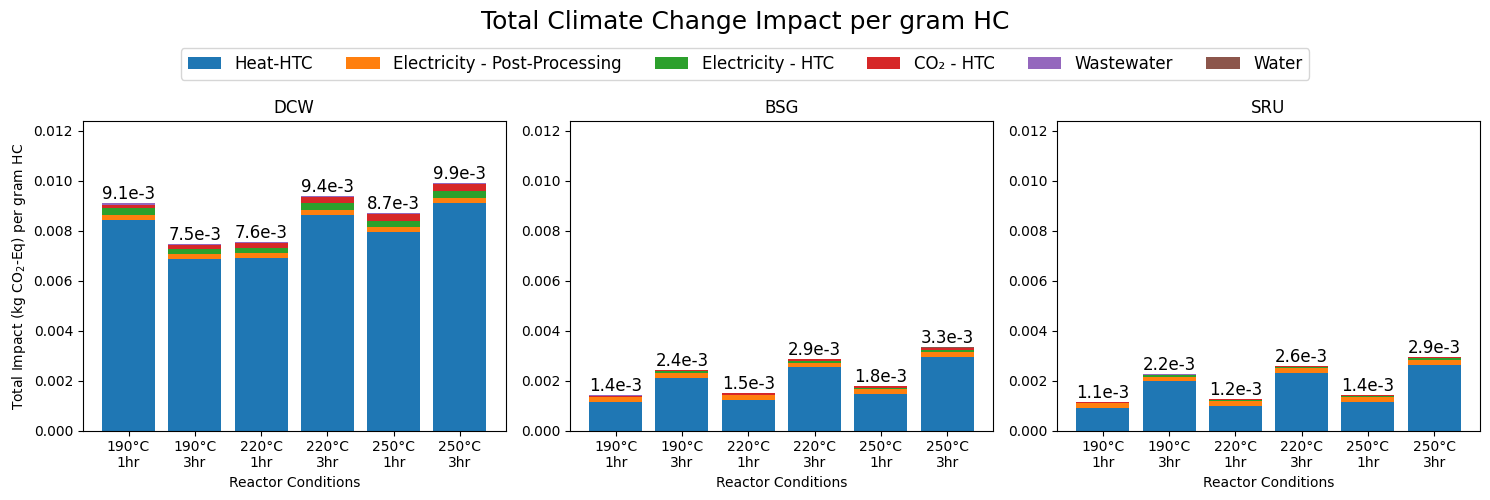

In [41]:
plot_stacked_bar_impact(baseline_lcia_manager, 'climate_change', 'gram HC')

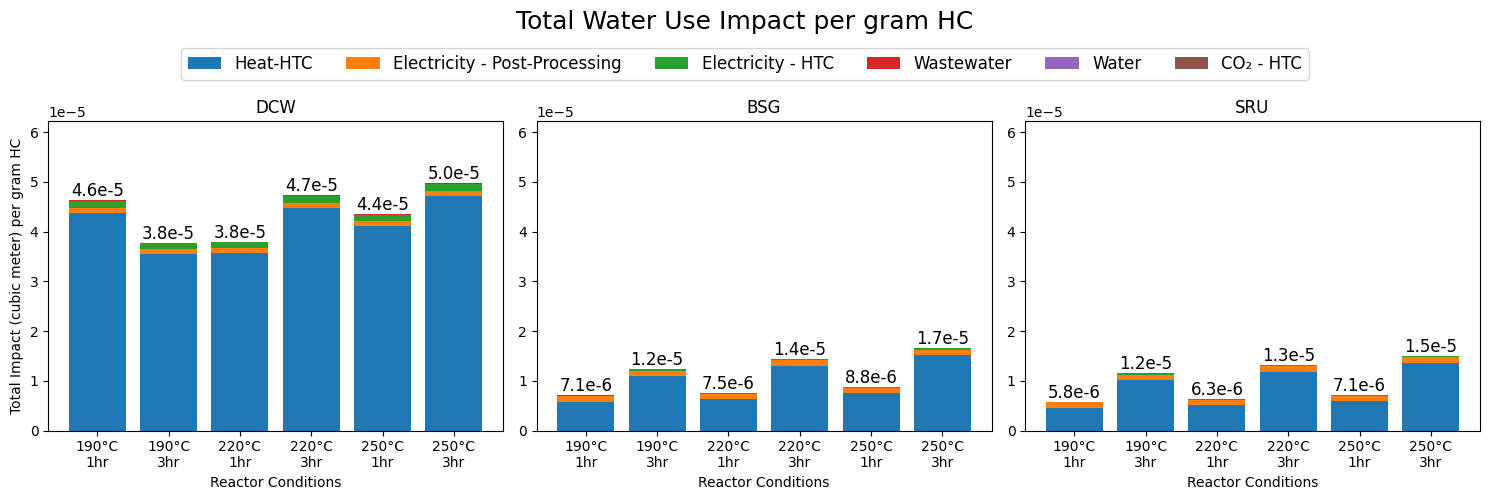

In [42]:
plot_stacked_bar_impact(baseline_lcia_manager, 'water_use', 'gram HC')

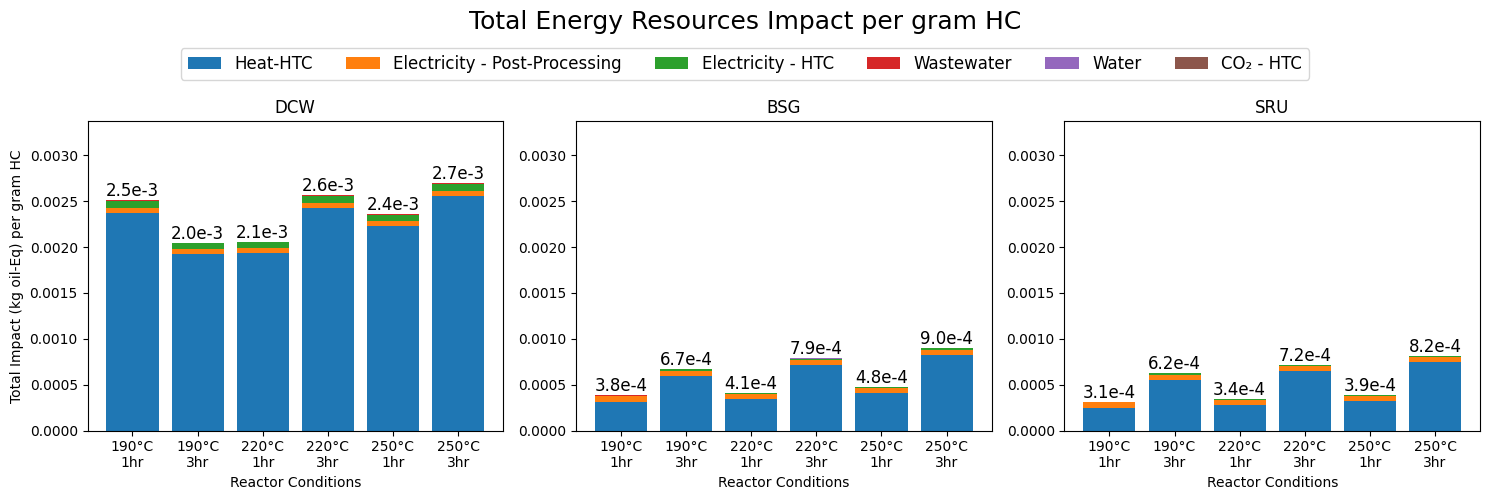

In [43]:
plot_stacked_bar_impact(baseline_lcia_manager, 'energy_resources', 'gram HC')

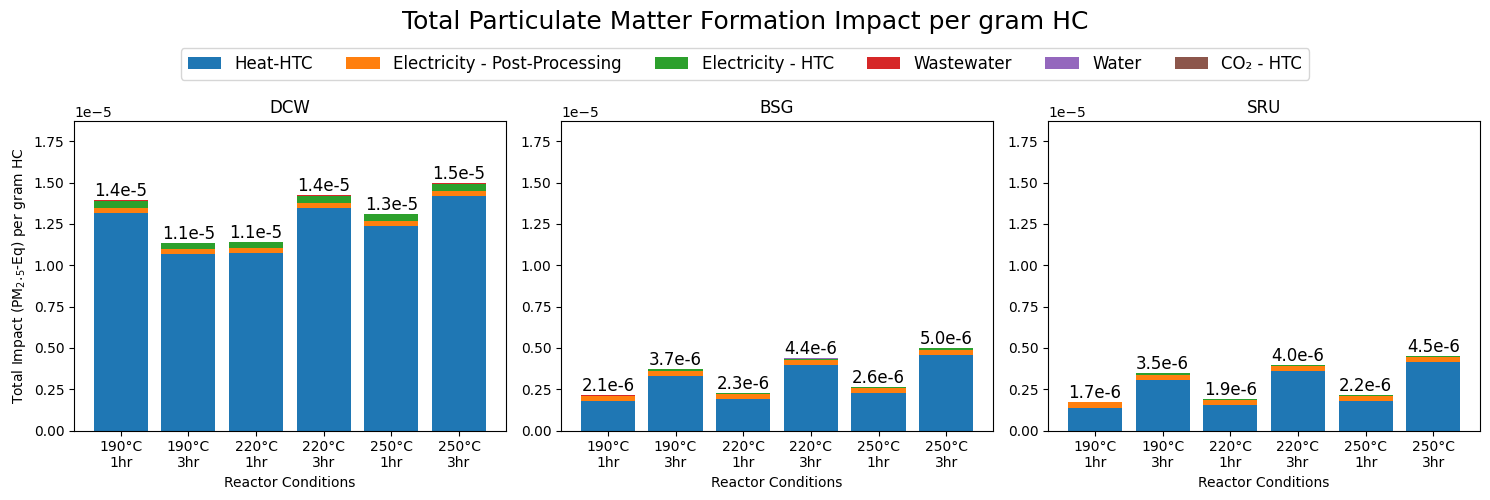

In [44]:
plot_stacked_bar_impact(baseline_lcia_manager, 'particulate_matter_formation', 'gram HC')

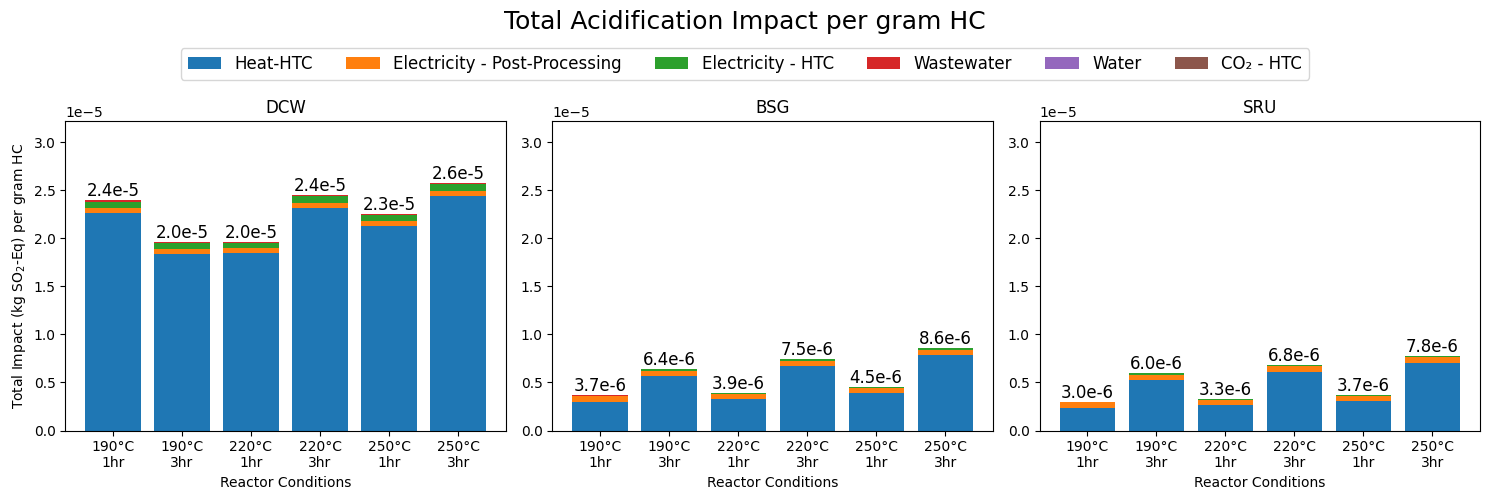

In [45]:
plot_stacked_bar_impact(baseline_lcia_manager, 'acidification', 'gram HC')

### 2.6: Plotting Feedstock Normalized Baseline LCA Results 
Plotting baseline LCA results normalized to per 500 grams of feedstock utilized to reflect lab scale conditions. Note that differences in results are directly attributed to utilizing the quantity of the feedstock, as compared to the production of hydrochar. 

In [46]:
# Replicating Baseline LCIA Manager for Re-Use
feedstock_lcia_manager = copy.deepcopy(baseline_lcia_manager)
feedstock_lcia_list = [hc for attr, lcia in feedstock_lcia_manager.__dict__.items() for hc in lcia]
for lcia in feedstock_lcia_list: 
    
    # Getting Relevant Feedstock 
    activity = [act for act in eidb if str(lcia.name) in act['name']][0]
    feedstock_decomposed = activity['name'].split('hydrochar production, ')[1].split('_')
    feedstock_name, temp, time = feedstock_decomposed[0], int(feedstock_decomposed[1][0:3]), int(feedstock_decomposed[2][0])
    
    # Getting Feedstock Quantity 
    feedstock = elementary_feedstocks.get_feedstock(feedstock_name, temp, time)
    
    # Determine normalization factor for getting per feedstock LCIA results
    # LCIA/feedstock = (LCIA / g hydrochar) * (g hydrochar / g feedstock) 
    normalization_factor = 1 / feedstock.quantity
    
    # Alternatively impact_categories = [attr for attr in lcia.__dict__ if attr != 'name']
    impact_categories = lcia.get_impact_categories()
    
    # Alternatively process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']
    process_categories = lcia.get_process_categories()
    
    for impact_category in impact_categories:
        for process_category in process_categories: 
            # Multiply by 500 to mimic experimental conditions
            unit = lcia.get_impact_unit(impact_category, process_category)
            # score = lcia.get_impact_score(impact_category, process_category) * normalization_factor * 1000
            score = lcia.get_impact_score(impact_category, process_category) * normalization_factor
            lcia.set_impact_score(impact_category, process_category, score, unit)
    
    print(lcia.name , "successfully updated in feedstock LCIA Manager.")

hydrochar production, stdSRU_250C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, rawDCW_220C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdBSG_220C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdBSG_250C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdBSG_250C_1hr successfully updated in feedstock LCIA Manager.
hydrochar production, rawDCW_190C_1hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdBSG_190C_1hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdSRU_250C_1hr successfully updated in feedstock LCIA Manager.
hydrochar production, rawDCW_190C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdSRU_190C_1hr successfully updated in feedstock LCIA Manager.
hydrochar production, rawDCW_250C_1hr successfully updated in feedstock LCIA Manager.
hydrochar production, rawDCW_250C_3hr successfully upd

In [47]:
# Identifying Exchanges of Interest 
exchange_names = []
activity = [act for act in eidb if 'hydrochar production' in act['name']][0]
for exc in activity.exchanges(): 
    exchange_names.append(exc.input)
    
# Gathering Process Categories  
process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']

# Writing Data to an Excel File 
export_hydrochar_lcia_to_excel(feedstock_lcia_manager, exchange_names, process_categories, 'baseline-lcia/feedstock_lcia.xlsx')

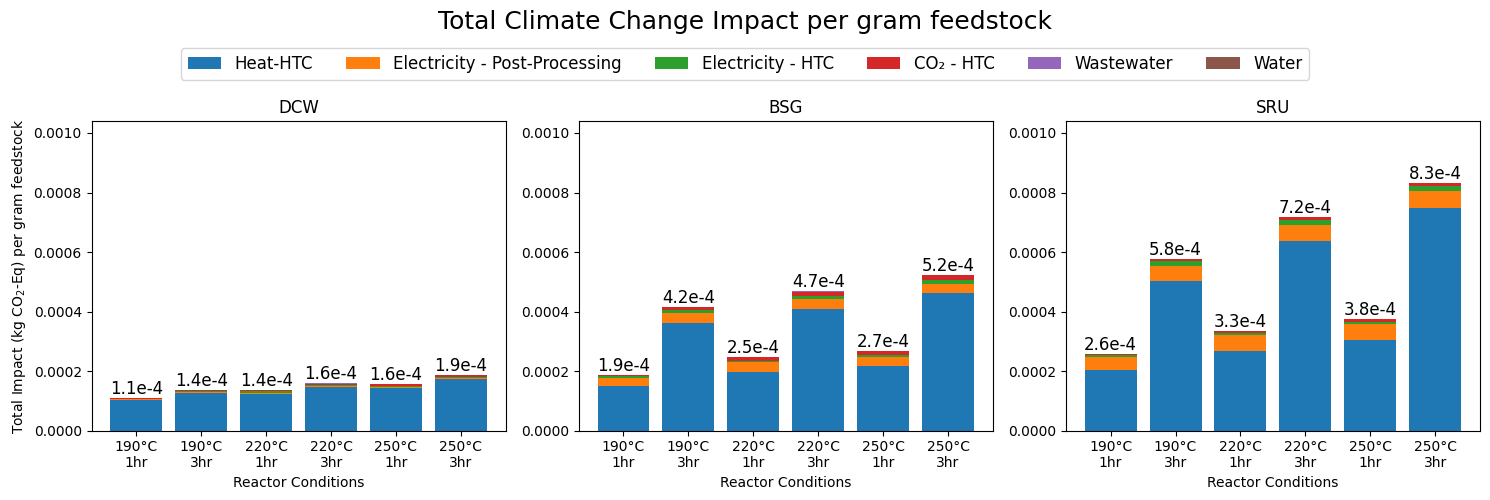

In [48]:
plot_stacked_bar_impact(feedstock_lcia_manager, 'climate_change', 'gram feedstock')

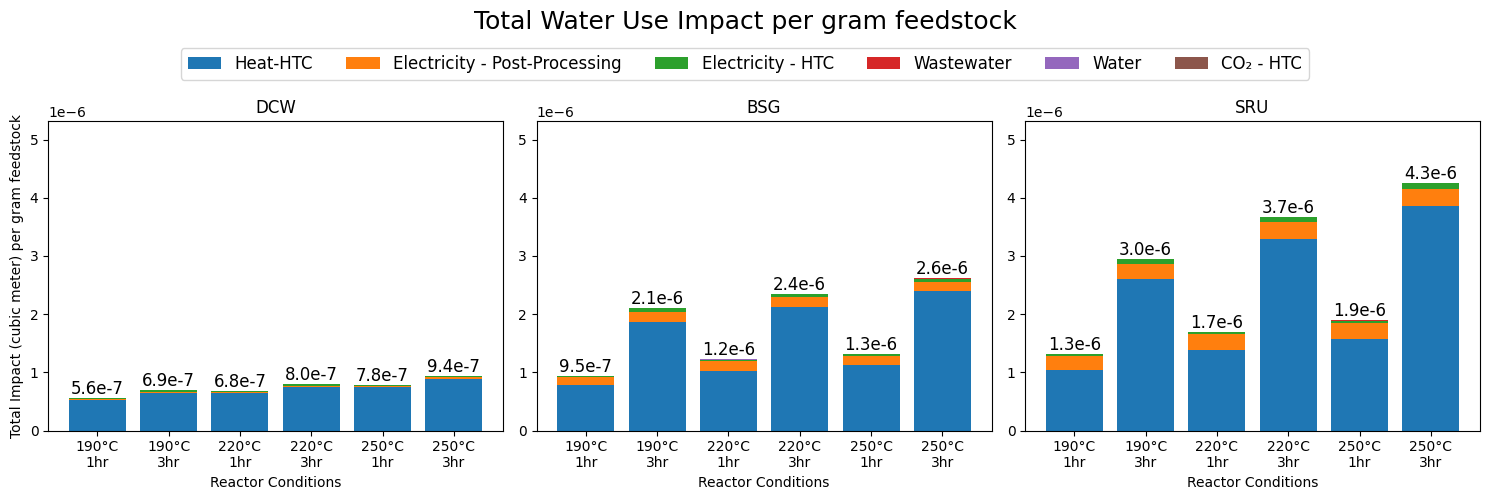

In [49]:
plot_stacked_bar_impact(feedstock_lcia_manager, 'water_use', 'gram feedstock')

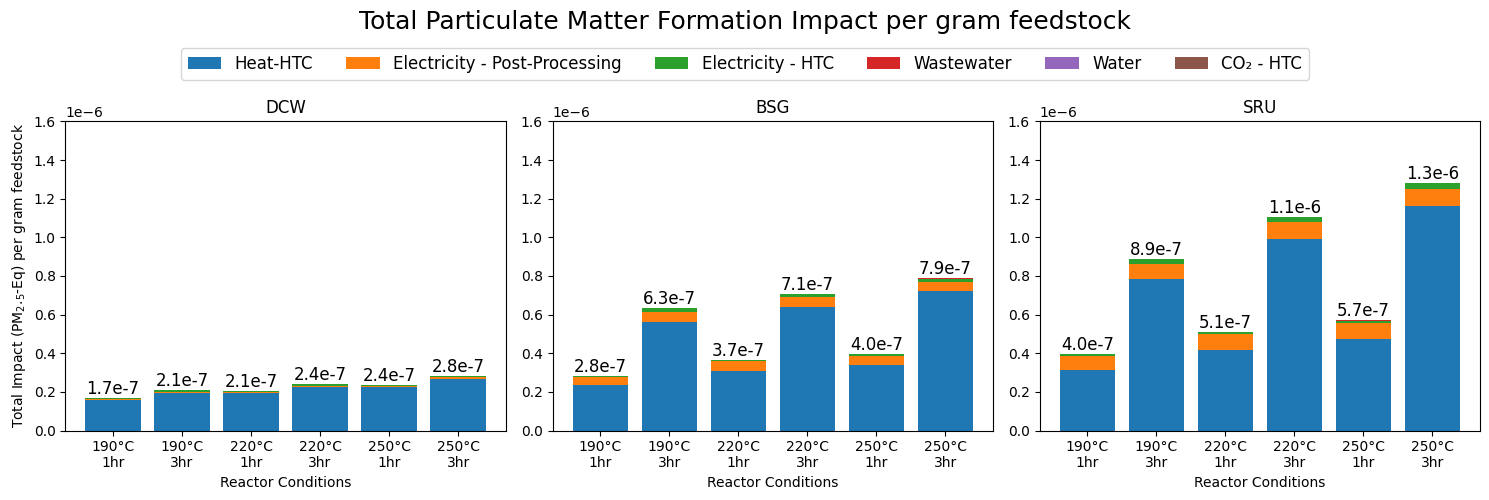

In [50]:
plot_stacked_bar_impact(feedstock_lcia_manager, 'particulate_matter_formation', 'gram feedstock')

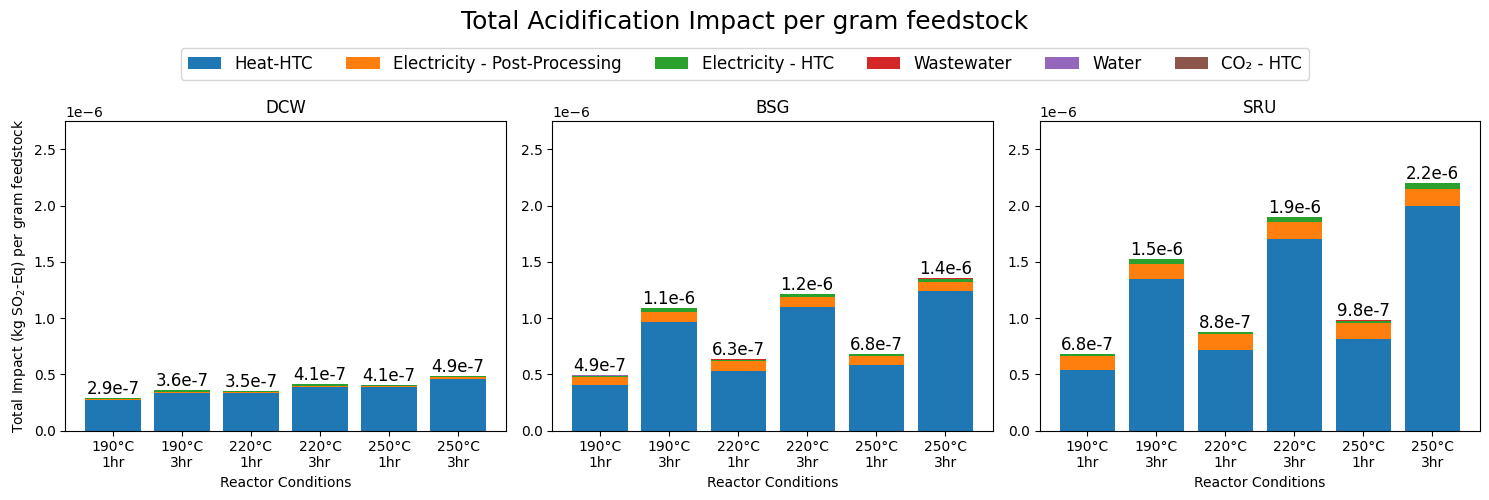

In [51]:
plot_stacked_bar_impact(feedstock_lcia_manager, 'acidification', 'gram feedstock')

### 2.7: Plotting HHV Normalized Baseline LCA Results 
Plotting baseline LCA results normalized to HHV per gram of feedstock utilized. While each process produces a solid hydrochar, the properties of the hydrochar are different, which can affect the best utilization of the hydrochar after production. In this example, we'll focus on a coal replacement for electricity generation through analysis of a higher heating value (HHV). While the downstream process is not in the scope of this analysis and this does not consider the full complexity of post-processing needed for application, it does provide some initial insights towards considering future application.

If considering hydrochar for a different application such as a soil amendment, for carbon sequestration purposes, wastewater treatment, etc, other properties (i.e surface area) may be more applicable. 

In [52]:
# Replicating Baseline LCIA Manager for Re-Use
hc_hhv_lcia_manager = copy.deepcopy(baseline_lcia_manager)
hc_hhv_lcia_list = [hc for attr, lcia in hc_hhv_lcia_manager.__dict__.items() for hc in lcia]
for lcia in hc_hhv_lcia_list: 
    
    # Getting Relevant Feedstock HC HHV
    activity = [act for act in eidb if str(lcia.name) in act['name']][0]
    feedstock = activity['name']
    hc_hhv = get_parameter(feedstock, 'HHV_HC')
    
    # Determine normalization factor for getting per HHV LCIA results
    # LCIA/HHV = (LCIA / g hydrochar) / ((MJ / kg hydrochar) * (1/1000) )
    normalization_factor = hc_hhv / 1000
    
    # Alternatively impact_categories = [attr for attr in lcia.__dict__ if attr != 'name']
    impact_categories = lcia.get_impact_categories()
    
    # Alternatively process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']
    process_categories = lcia.get_process_categories()
    
    for impact_category in impact_categories:
        for process_category in process_categories: 
            unit = lcia.get_impact_unit(impact_category, process_category)
            score = lcia.get_impact_score(impact_category, process_category) / normalization_factor 
            lcia.set_impact_score(impact_category, process_category, score, unit)
        
    
    print(lcia.name , "successfully updated in hydrochar HHV LCIA Manager.")

hydrochar production, stdSRU_250C_3hr successfully updated in hydrochar HHV LCIA Manager.
hydrochar production, rawDCW_220C_3hr successfully updated in hydrochar HHV LCIA Manager.
hydrochar production, stdBSG_220C_3hr successfully updated in hydrochar HHV LCIA Manager.
hydrochar production, stdBSG_250C_3hr successfully updated in hydrochar HHV LCIA Manager.
hydrochar production, stdBSG_250C_1hr successfully updated in hydrochar HHV LCIA Manager.
hydrochar production, rawDCW_190C_1hr successfully updated in hydrochar HHV LCIA Manager.
hydrochar production, stdBSG_190C_1hr successfully updated in hydrochar HHV LCIA Manager.
hydrochar production, stdSRU_250C_1hr successfully updated in hydrochar HHV LCIA Manager.
hydrochar production, rawDCW_190C_3hr successfully updated in hydrochar HHV LCIA Manager.
hydrochar production, stdSRU_190C_1hr successfully updated in hydrochar HHV LCIA Manager.
hydrochar production, rawDCW_250C_1hr successfully updated in hydrochar HHV LCIA Manager.
hydrochar 

In [53]:
# Identifying Exchanges of Interest 
exchange_names = []
activity = [act for act in eidb if 'hydrochar production' in act['name']][0]
for exc in activity.exchanges(): 
    exchange_names.append(exc.input)
    
# Gathering Process Categories  
process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']

# Writing Data to an Excel File 
export_hydrochar_lcia_to_excel(hc_hhv_lcia_manager, exchange_names, process_categories, 'baseline-lcia/hhv_hc_lcia.xlsx')

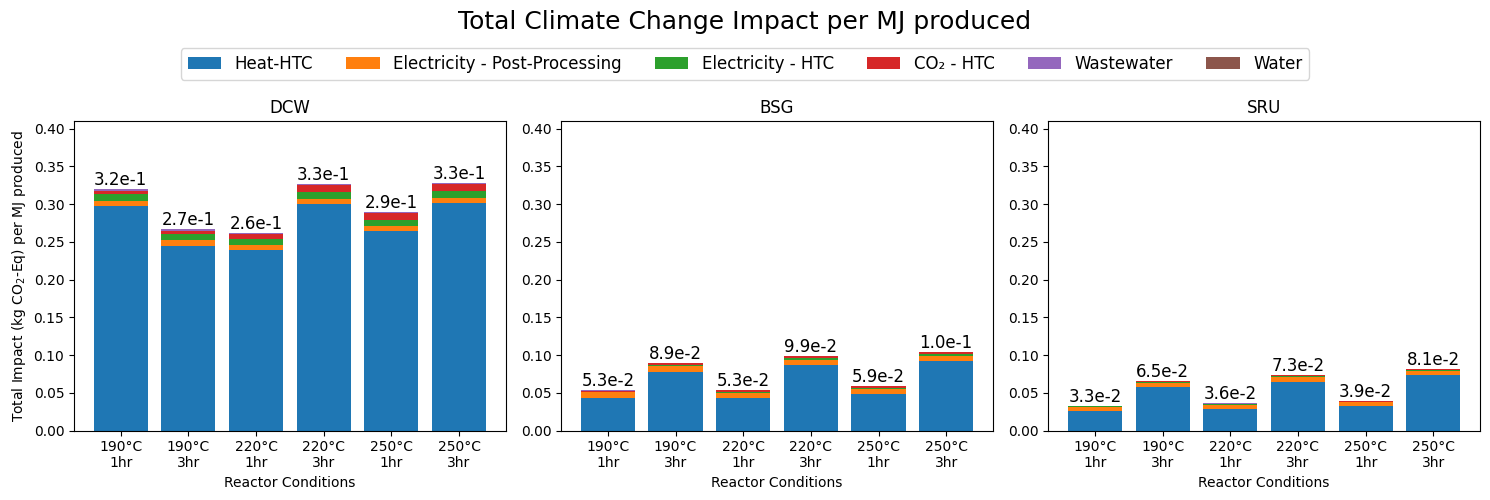

In [54]:
plot_stacked_bar_impact(hc_hhv_lcia_manager, 'climate_change', 'gram HC / HHV')

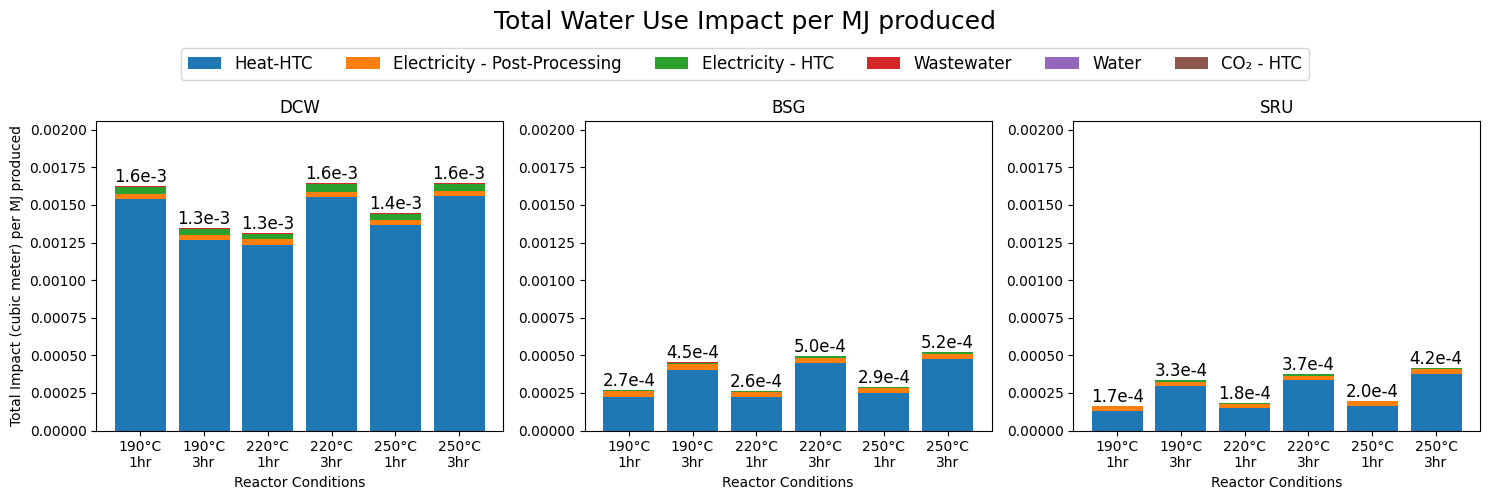

In [55]:
plot_stacked_bar_impact(hc_hhv_lcia_manager, 'water_use', 'gram HC / HHV')

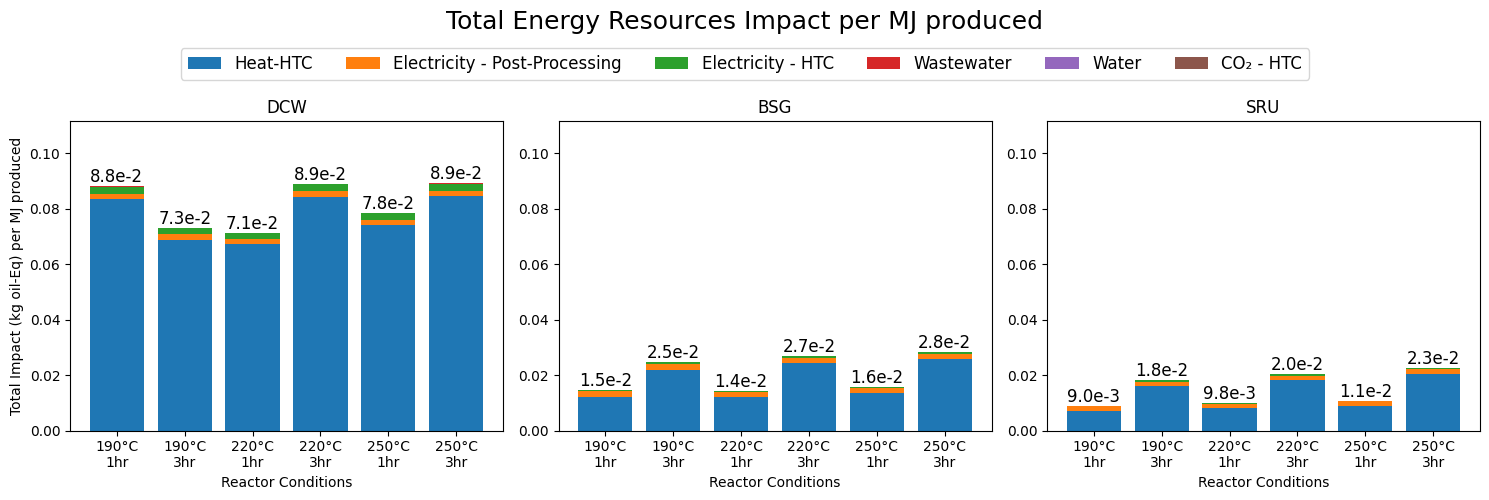

In [56]:
plot_stacked_bar_impact(hc_hhv_lcia_manager, 'energy_resources', 'gram HC / HHV')

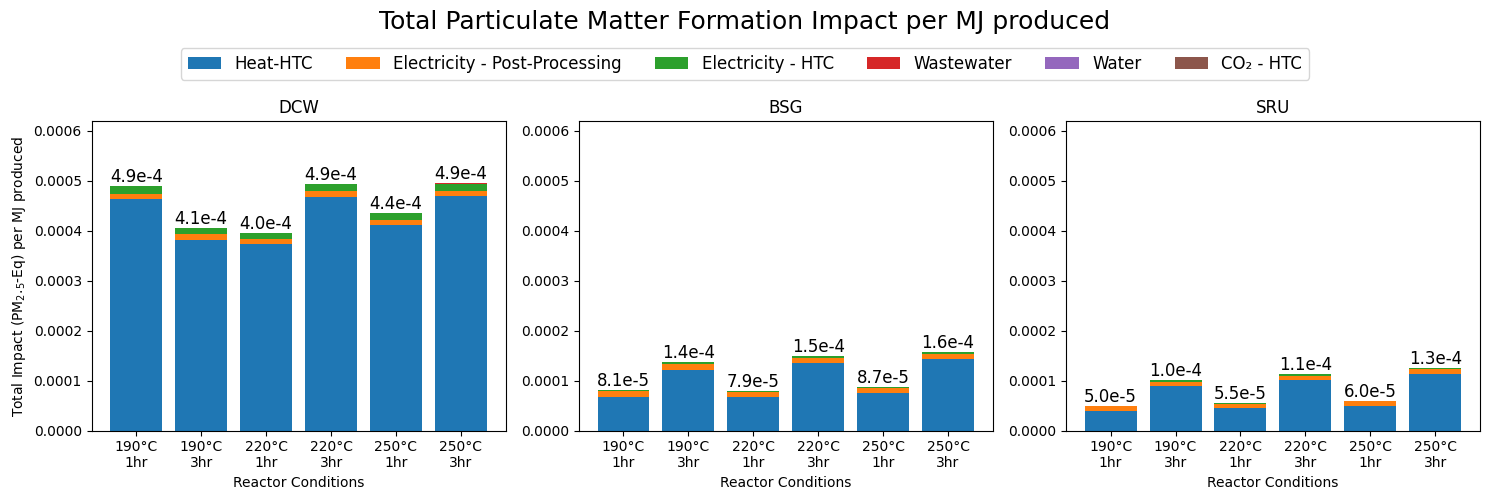

In [57]:
plot_stacked_bar_impact(hc_hhv_lcia_manager, 'particulate_matter_formation', 'gram HC / HHV')

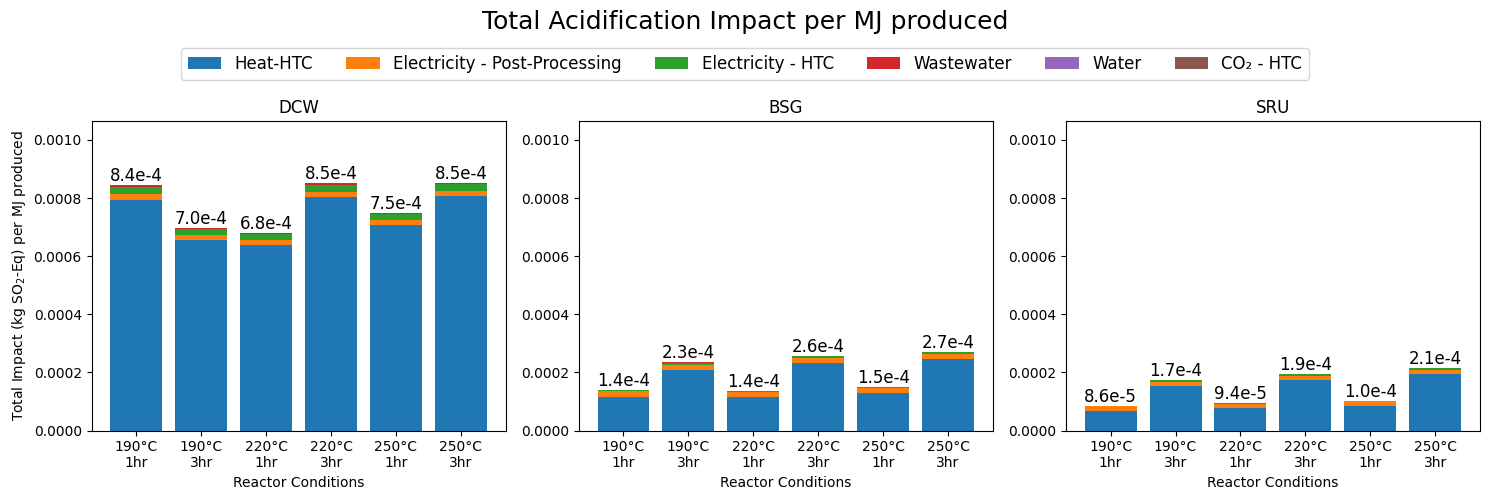

In [58]:
plot_stacked_bar_impact(hc_hhv_lcia_manager, 'acidification', 'gram HC / HHV')

In [59]:
def plot_combined_stacked_bar_impact(baseline_lcia_manager, feedstock_lcia_manager, hc_hhv_lcia_manager, impact_category):
    '''
    Plots a combined stacked bar graph for a Life Cycle Impact Category given a set of LCIA results for hydrochar, 
    feedstock, and HC HHV normalization techniques in a single figure with one set of labels and title.
    
    Parameters:
        baseline_lcia_manager (obj): Contains all Hydrochar LCIA results.
        feedstock_lcia_manager (obj): Contains all Feedstock LCIA results.
        hc_hhv_lcia_manager (obj): Contains all HC HHV LCIA results.
        impact_category (str): The LCIA impact category to plot.
    '''

    # Combine the LCIA lists
    hydrochar_lcia_list = [hc for attr, lcia in baseline_lcia_manager.__dict__.items() for hc in lcia]
    feedstock_lcia_list = [hc for attr, lcia in feedstock_lcia_manager.__dict__.items() for hc in lcia]
    hc_hhv_lcia_list = [hc for attr, lcia in hc_hhv_lcia_manager.__dict__.items() for hc in lcia]
    
    combined_lcia_list = [hydrochar_lcia_list, feedstock_lcia_list, hc_hhv_lcia_list]
    normalization_labels = [" per gram HC", " per gram feedstock", " per MJ produced"]

    # Process categories and colorblind-friendly colors
    process_categories = ['Water', 'Heat-HTC', 'Electricity - HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']
    colors = plt.get_cmap("tab10").colors[:len(process_categories)]
    units = None

    fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True)
    fig.subplots_adjust(hspace=0.4, wspace=0.3)

    for row, lcia_list in enumerate(combined_lcia_list):
        labels = [hc.name.split('hydrochar production, ')[1] for hc in lcia_list]
        data = {process: [] for process in process_categories}

        for hc in lcia_list:
            impact_data = getattr(hc, impact_category)
            for process in process_categories:
                score = impact_data[process]['score']
                unit = impact_data[process]['unit']
                data[process].append(score)
                if not units:
                    units = unit

        data_matrix = np.array([data[process] for process in process_categories])
        labels, data_matrix = zip(*sorted(zip(labels, data_matrix.T), key=lambda x: x[0]))
        data_matrix = np.array(data_matrix).T

        sorted_indices = np.argsort(data_matrix.sum(axis=1))[::-1]
        sorted_data_matrix = data_matrix[sorted_indices]
        sorted_process_categories = np.array(process_categories)[sorted_indices]

        groups = [range(0, 6), range(6, 12), range(12, 18)]
        row_max_bottom = 0

        def clean_label(label):
            parts = label.split('_')[1:]  
            cleaned_label = '\n'.join(part.replace('C', '°C') for part in parts)
            return cleaned_label

        for col, ax in enumerate(axes[row, :]):
            group = groups[col]
            bottom = np.zeros(len(group))

            for j, process in enumerate(sorted_process_categories):
                scores = sorted_data_matrix[j][group]
                ax.bar([clean_label(labels[k]) for k in group], scores, bottom=bottom, label=process, color=colors[j])
                bottom += scores

            titles = [labels[k] for k in group][0].split('_')[0][3:].upper() + normalization_labels[row]
            row_max_bottom = max(row_max_bottom, bottom.max())
            subplot_label = chr(97 + col + row * 3)  # (a), (b), etc.
            ax.set_title(titles, fontsize=14)
            ax.text(-0.1, 1.05, f'({subplot_label})', transform=ax.transAxes, size=14, weight='bold')

            for k, total in enumerate(bottom):
                formatted_total = f'{total:.1e}'.replace('e-0', 'e-').replace('e+0', 'e')
                ax.text(k, total, f'{formatted_total}', ha='center', va='bottom', fontsize=12)

        # Set independent y-axis limits for each row
        for col_ax in axes[row, :]:
            col_ax.set_ylim(0, row_max_bottom * 1.25)
        
    formatted_units = re.sub(r'(\d+)', r'$_{\1}$', units)
    fig.text(0.04, 0.5, f'Total {impact_category.replace("_", " ").title()} Impact ({formatted_units})', va='center', rotation='vertical', fontsize=14)
    fig.text(0.5, 0.02, "Reactor Conditions", ha='center', fontsize=14)

    handles, labels = axes[0, -1].get_legend_handles_labels()
    labels = [label.replace('CO2 - HTC', 'CO\u2082 - HTC') for label in labels]
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1), ncol=len(sorted_process_categories), fontsize=14, frameon=False)

    plt.tight_layout(rect=[0.05, 0.03, 1, 0.95], pad=2.0)
    plt.show()


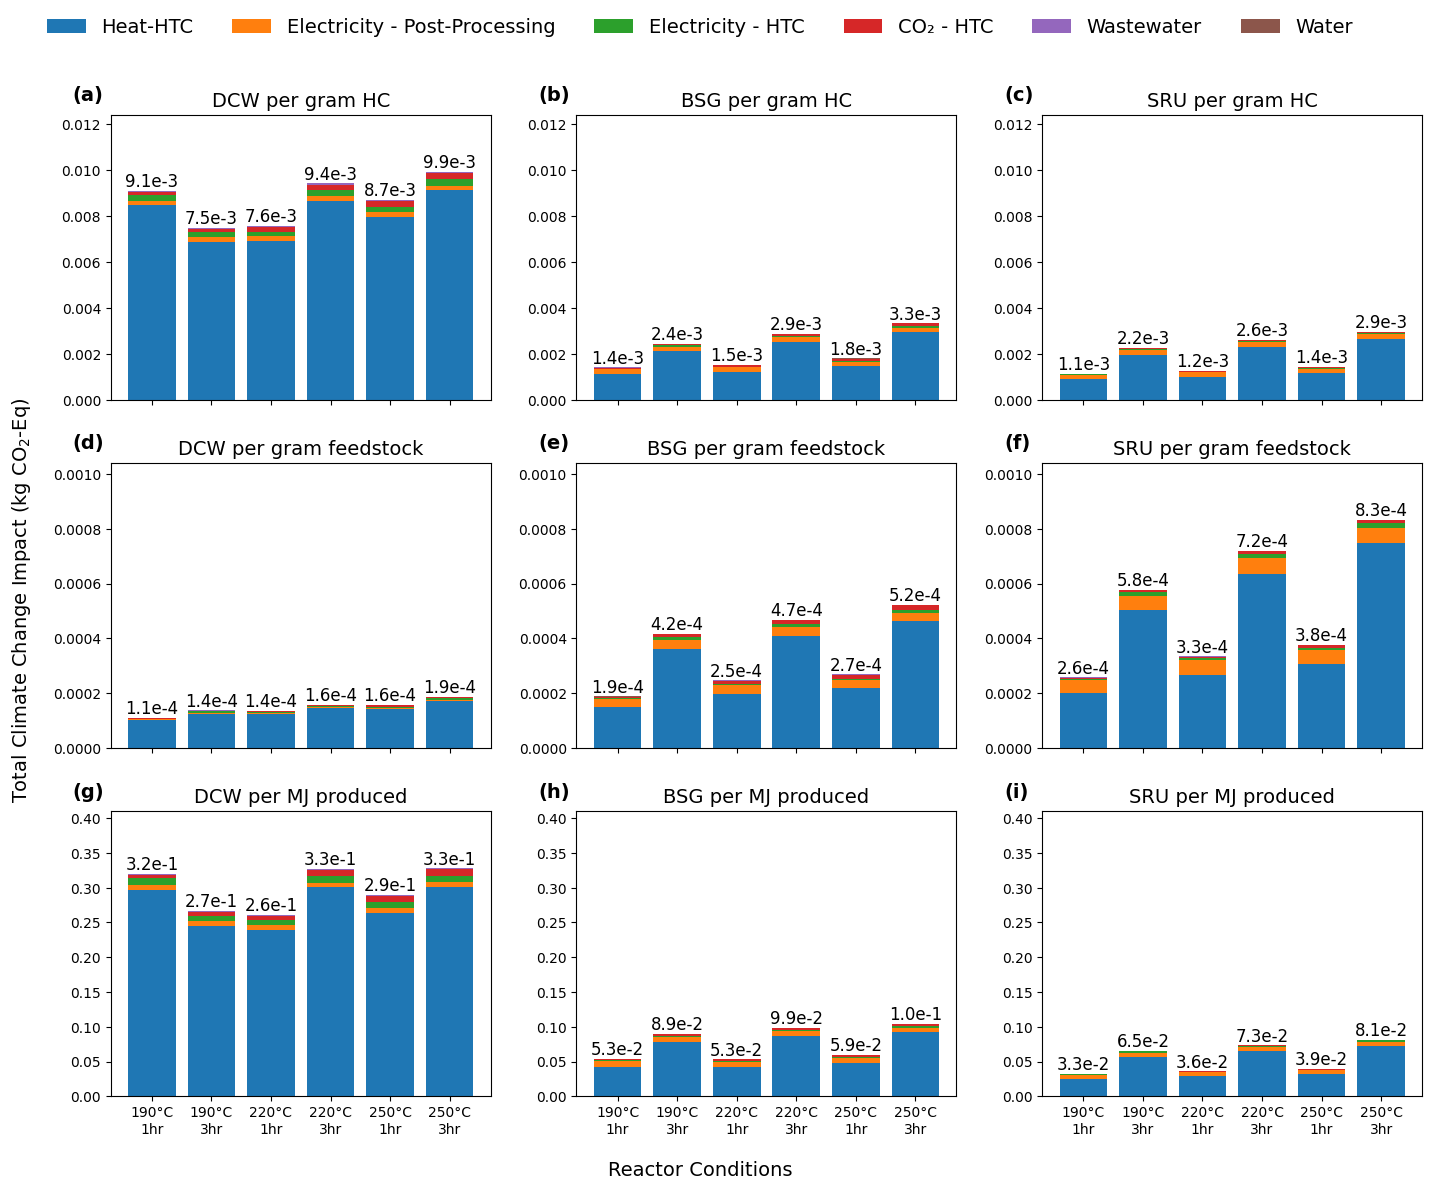

In [60]:
plot_combined_stacked_bar_impact(baseline_lcia_manager, feedstock_lcia_manager, hc_hhv_lcia_manager, 'climate_change')

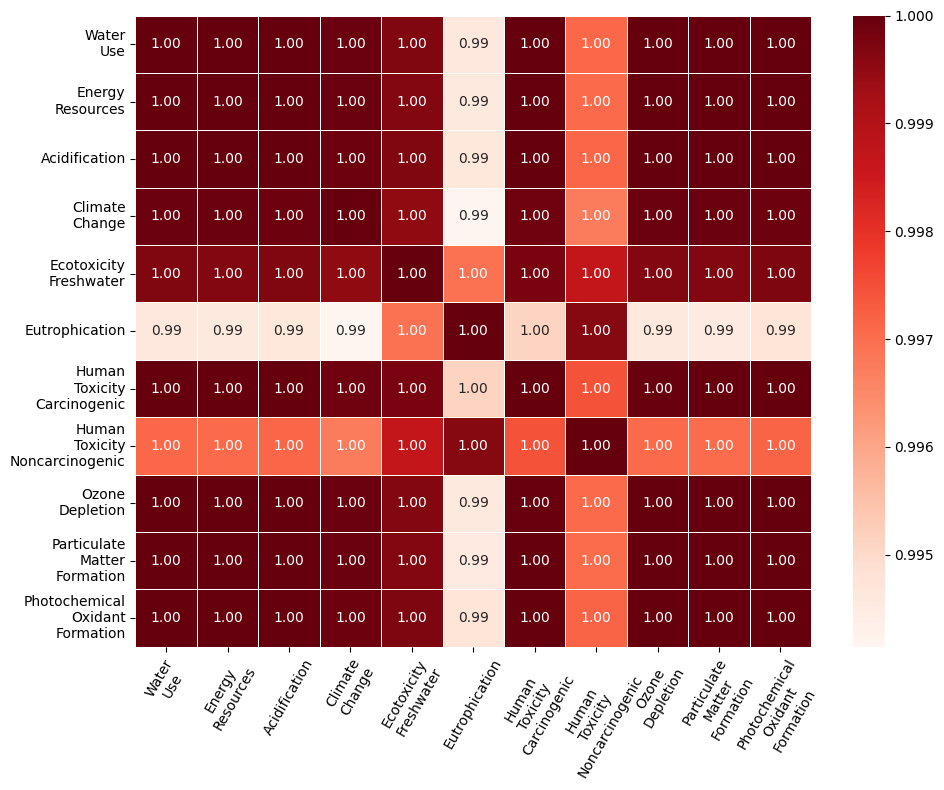

In [61]:
# Showing correlation between impact assessment categories
hydrochar_lcia_list = [hc for attr, lcia in baseline_lcia_manager.__dict__.items() for hc in lcia]
impact_categories = hydrochar_lcia_list[0].get_impact_categories()

for row in hydrochar_lcia_list:
    labels = [hc.name.split('hydrochar production, ')[1] for hc in hydrochar_lcia_list]
    data = {impact_category: [] for impact_category in impact_categories}
    for hc in hydrochar_lcia_list:
        for impact_category in impact_categories:
            data[impact_category].append(hc.get_total_impact_score(impact_category))
    
    data_matrix = np.array([data[impact_category] for impact_category in impact_categories])
    labels, data_matrix = zip(*sorted(zip(labels, data_matrix.T), key=lambda x: x[0]))
    data_matrix = np.array(data_matrix).T
    
    sorted_indices = np.argsort(data_matrix.sum(axis=1))[::-1]
    sorted_data_matrix = data_matrix[sorted_indices]
    sorted_impact_categories = np.array(impact_categories)[sorted_indices]

def clean_label(label):
    parts = label.split('_') 
    cleaned_parts = []
    for part in parts:
        if 'DCW' in part: 
            cleaned_parts.append(part)
        elif 'C' in part and not part.endswith('°C'):
            cleaned_parts.append(part.replace('C', '°C'))
        else:
            cleaned_parts.append(part)  
    return '\n'.join(cleaned_parts) 
            
cleaned_labels = [clean_label(label) for label in labels]

def clean_labels_for_heatmap(labels):
    """
    Cleans the labels by replacing underscores with a line break and converting to title case.
    """
    cleaned_labels = [label.replace('_', '\n').title() for label in labels]
    return cleaned_labels

cleaned_impact_categories = clean_labels_for_heatmap(impact_categories)

# Compute correlation matrix
correlation_matrix = np.corrcoef(data_matrix)

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, xticklabels=cleaned_impact_categories, yticklabels=cleaned_impact_categories, 
            cmap='Reds', annot=True, fmt='.2f', linewidths=0.5)
plt.xticks(rotation=60)

# Labels and title
# plt.title('Correlation Matrix of Impact Categories', fontsize=14)
plt.tight_layout()
plt.show()


## 3: Comprehensive Baseline LCA
From our previous normalization results, the following interpretations can be made: 
- There is synonymous alignment across the impact assessments. Therefore, one impact category can be sufficient to compare differences across each normalization technique. 
- As the same exchanges are replicated across all 18 scenarios, the scenarios with the lowest impact assessment scores stem from efficient utilization of inputs. 
- The environmental hotspots are from post-processing and from heat, generated from electricity, with the HTC reactor.  
- The lowest impact assessment scores for each feedstock vary based on the normalization technique. 

To determine the 'optimal' condition or the lowest environmental impact for each feedstock across each normalization technique, we will examine optimal solutions from a multi-objective systems optimization perspective for one impact assessment method, climate change, as we have three relevant objectives: 
1. To minimize the environmental impact normalized to 1 g of feedstock treated. 
2. To minimize the environmental impact normalized to 1 g of hydrochar produced. 
3. To minimize the environmental impact per creating a higher value of hydrochar produced for a energy post-valorization pathway, through consideration of HHV. 


In [62]:
# Helper function for getting GWP data 
def get_gwp_data(feedstock_name, normalization_columns): 
    '''
    Returns a Pandas DataFrame of GWP values per all normalization categories, given a feedstock. 
    
    Parameters:
        feedstock_name (str): Name of feedstock (i.e. DCW, SRU, BSG)   
        normalization_columns (list): List of Normalization Columns ['Feedstock', 'Hydrochar', 'Hydrochar HHV']
    '''
    
    # Helper Function to retrieve and sort impact scores for an LCIA Manager. 
    def get_sorted_impact_scores(manager):
        lcia_list = [hc for attr, lcia in manager.__dict__.items() for hc in lcia]
        return sorted(lcia_list, key=lambda x: x.name)

    # Retrieve and sort impact scores
    feedstock_lcia_list = get_sorted_impact_scores(feedstock_lcia_manager)
    hc_lcia_list = get_sorted_impact_scores(baseline_lcia_manager)
    hc_hhv_lcia_list = get_sorted_impact_scores(hc_hhv_lcia_manager)

    # Filter and extract data for climate change normalization technique
    filtered_data = [
        (f.name.split('hydrochar production, ')[1], f.get_total_impact_score('climate_change'),
        b.get_total_impact_score('climate_change'),
        h.get_total_impact_score('climate_change'))
        for f, b, h in zip(feedstock_lcia_list, hc_lcia_list, hc_hhv_lcia_list)
        if feedstock_name in f.name
    ]
    
    data = pd.DataFrame(filtered_data, columns=[
        'name', 
        'Feedstock',
        'Hydrochar',  
        'Hydrochar HHV'
    ])

    # Convert filtered data to DataFrame
    normalization_columns.insert(0, 'name')
    data = pd.DataFrame(data, columns=normalization_columns)
    
    data = data.drop_duplicates()
    return data

In [63]:
# Helper function for getting spider data 
def get_gwp_data_2d(feedstock_name): 
    '''
    Returns a Pandas DataFrame of GWP values per the normalization categories of Hydrochar HHV & feedstock, given a feedstock. 
    
    Parameters:
        feedstock_name (str): Name of feedstock (i.e. DCW, SRU, BSG)   
    '''
    
    # Helper Function to retrieve and sort impact scores for an LCIA Manager. 
    def get_sorted_impact_scores(manager):
        lcia_list = [hc for attr, lcia in manager.__dict__.items() for hc in lcia]
        return sorted(lcia_list, key=lambda x: x.name)

    # Retrieve and sort impact scores
    feedstock_lcia_list = get_sorted_impact_scores(feedstock_lcia_manager)
    hc_lcia_list = get_sorted_impact_scores(baseline_lcia_manager)
    hc_hhv_lcia_list = get_sorted_impact_scores(hc_hhv_lcia_manager)

    # Filter and extract data for climate change normalization technique
    filtered_data = [
        (f.name.split('hydrochar production, ')[1], f.get_total_impact_score('climate_change'),
        b.get_total_impact_score('climate_change'),
        h.get_total_impact_score('climate_change'))
        for f, b, h in zip(feedstock_lcia_list, hc_lcia_list, hc_hhv_lcia_list)
        if feedstock_name in f.name
    ]

    # Convert filtered data to DataFrame
    data = pd.DataFrame(filtered_data, columns=[
        'name', 
        'Feedstock',
        'Hydrochar',  
        'Hydrochar HHV'
    ])
    data = pd.DataFrame(data, 
        columns=[
            'name', 
            'Feedstock', 
            'Hydrochar HHV' ]
    )
    data = data.drop_duplicates()
    return data

#### 3.1: Original Feedstock Analysis
To start, let's visualize how the different objectives appear in space across the 18 baseline scenarios. We can create Pareto front visualizations for the six reactor conditions for each of the three feedstocks to visualize tradeoffs & determine optimal conditions. 

In [64]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
from pareto import get_pareto_front, is_dominant, pareto_sort
from IPython.display import display
from scipy.interpolate import make_interp_spline
from matplotlib.colors import ListedColormap, BoundaryNorm

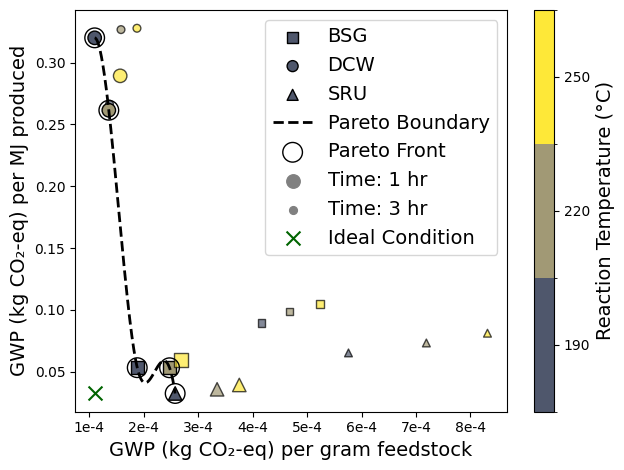

In [65]:
dcw_data = get_gwp_data('rawDCW_', ['Feedstock', 'Hydrochar HHV'])
bsg_data = get_gwp_data('stdBSG_', ['Feedstock', 'Hydrochar HHV'])
sru_data = get_gwp_data('stdSRU_', ['Feedstock', 'Hydrochar HHV'])
data = pd.concat([dcw_data, bsg_data, sru_data], ignore_index=True, sort=False)
pareto_front = get_pareto_front(data)

data[['Feedstock_Type', 'Temperature', 'Time']] = data['name'].str.extract(r'(\D+)(\d+C)_(\d+hr)')
data['Temperature'] = data['Temperature'].str.replace('C', '').astype(float)
data['Time'] = data['Time'].str.replace('hr', '').astype(float)
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('raw', '')
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('std', '')
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('_', '')

# Create a 2D scatter plot
fig, ax = plt.subplots()

# Define marker styles and colors for feedstocks
feedstock_markers = {'DCW': 'o', 'BSG': 's', 'SRU': '^'}

# Normalize temperature to a color map (for temperature gradients)
cmap = ListedColormap(plt.cm.cividis(np.linspace(0.3, 1, 3)))
temperature_norm = BoundaryNorm([175, 205, 235, 265], cmap.N)

# Plot data points with varying marker sizes for reaction time and color for temperature
for feedstock, group_data in data.groupby('Feedstock_Type'):
        # Check if any points in the group are on the Pareto front
    is_pareto = group_data[['Feedstock', 'Hydrochar HHV']].apply(lambda x: any(np.all(x == pareto_point) for pareto_point in pareto_front), axis=1)

    # Set alpha based on whether points are on the Pareto front
    # Full opacity for Pareto front, reduced for others
    alpha_value = np.where(is_pareto, 1, 0.7)  
    
    scatter = ax.scatter(group_data.iloc[:, 1], group_data.iloc[:, 2],
                         c=group_data['Temperature'], cmap=cmap, norm=temperature_norm,
                         marker=feedstock_markers[feedstock],
                         s= 75 / (group_data['Time']*0.8),  # Adjust marker size based on reaction time (multiplied for clarity)
                         edgecolor='black', label=feedstock, alpha=alpha_value)
    
# Sort Pareto front points for interpolation
sorted_pareto = pareto_front[np.argsort(pareto_front[:, 0])]

# Create spline for a smooth curve
x_pareto = sorted_pareto[:, 0]
y_pareto = sorted_pareto[:, 1]
spline = make_interp_spline(x_pareto, y_pareto, k=3)  # k=3 for cubic spline

# Generate smooth points
x_smooth = np.linspace(x_pareto.min(), x_pareto.max(), 300)
y_smooth = spline(x_smooth)

# Plot the smooth dashed Pareto front curve
ax.plot(x_smooth, y_smooth, color='black', linestyle='--', linewidth=2, label='Pareto Boundary')
ax.scatter(pareto_front[:, 0], pareto_front[:, 1], color='none', label='Pareto Front', s=200, edgecolor='k')

# Add dummy scatter points for time legend
for time_value in data['Time'].unique():
    ax.scatter([], [], s=75/(time_value*0.8), color='gray', label=f'Time: {int(time_value)} hr')  # Gray markers for clarity

# Add colorbar to indicate temperature
cbar = plt.colorbar(scatter, ax=ax, ticks=[190,220,250])
cbar.set_label('Reaction Temperature (°C)', fontsize=14)

# Add legend and make it colorblind-friendly
ax.legend(title="Feedstock Type", loc='upper right')

# Adding ideal point to the plot
ideal_x = data['Feedstock'].min()
ideal_y = data['Hydrochar HHV'].min()
ax.scatter(ideal_x, ideal_y, color='darkgreen', marker='x', s=100, label='Ideal Condition', zorder=5)

# Labels and title
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.legend(prop={'size': 14})
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0e}'.replace('e-0', 'e-').replace('e+0', 'e+')))
ax.set_xlabel('GWP (kg CO\u2082-eq) per gram feedstock', fontsize=14)
ax.set_ylabel('GWP (kg CO\u2082-eq) per MJ produced', fontsize=14)



# ax.set_title(f'Climate Change Impacts Normalized to Hydrochar HHV & Feedstock')

# Ensure layout is tidy and readable
plt.tight_layout()

# Show plot
plt.show()


In [66]:
data = pd.concat([dcw_data, bsg_data, sru_data], ignore_index=True, sort=False)
dominant, non_dominant = pareto_sort(data)
print(len(non_dominant))

13


In [67]:
dominant_data = pd.DataFrame(dominant, columns=['name', 'Feedstock', 'Hydrochar HHV'])

In [68]:
dominant_data

name  Feedstock  Hydrochar HHV
0   rawDCW_190C_1hr   0.000110       0.320015
2   rawDCW_220C_1hr   0.000136       0.261470
6   stdBSG_190C_1hr   0.000188       0.053379
8   stdBSG_220C_1hr   0.000247       0.053306
12  stdSRU_190C_1hr   0.000258       0.032526

While multiple solutions are dominant as they lie on the Pareto front, we can determine the most optimal solution through utilizing a Multiple-Criteria Decision Making (MCDM) method, Technique for Order Preference by Similarity to Ideal Solution (TOPSIS). 

In [69]:
def topsis(df, criteria_cols):
    """
    Perform TOPSIS analysis on a dataset.

    Parameters:
    df (pd.DataFrame): The input data frame with at least one criteria column.
    criteria_cols (list of str): List of column names corresponding to criteria.

    Returns:
    pd.DataFrame: The input dataframe with an additional 'TOPSIS Score' column, sorted by score.
    """
    # Step 1: Normalize the decision matrix
    normalized_df = df[criteria_cols] / np.sqrt((df[criteria_cols] ** 2).sum())
    
    # Step 2: Calculate the weighted normalized decision matrix
    # Since all criteria have equal weight, we can skip the actual multiplication step

    # Step 3: Determine ideal and nadir solutions
    ideal_solution = normalized_df.min()
    nadir_solution = normalized_df.max()
    
    # Step 4: Calculate the distance to the ideal and nadir solutions
    distance_to_ideal = np.sqrt(((normalized_df - ideal_solution) ** 2).sum(axis=1))
    distance_to_nadir = np.sqrt(((normalized_df - nadir_solution) ** 2).sum(axis=1))
    
    # Step 5: Calculate the TOPSIS score
    topsis_score = distance_to_nadir / (distance_to_ideal + distance_to_nadir)
    
    # Add the score to the dataframe and sort by it
    df['TOPSIS Score'] = topsis_score
    df_sorted = df.sort_values(by='TOPSIS Score', ascending=False).reset_index(drop=True)
    
    return df_sorted

In [70]:
# Helper Function to Truncate Name
def truncate_name(name):
    truncated_name = re.sub(r'_sa_(lb|ub)', '', name)
    truncated_name = truncated_name.replace('hydrochar production, ', '')
    truncated_name = truncated_name.replace('raw', '')
    truncated_name = truncated_name.replace('std', '')
    truncated_name = truncated_name.replace('-1', ', 1')
    truncated_name = truncated_name.replace('-2', ', 2')
    truncated_name = truncated_name.replace('_', ', ')
    truncated_name = truncated_name.replace('0C', '0°C')
    return truncated_name

In [71]:
# Saving TOPSIS scores for all reactor conditions to Excel file
path = 'results/TOPSIS-scores.xlsx'
with pd.ExcelWriter(path, engine='xlsxwriter') as writer:
    criteria_cols = ['Feedstock', 'Hydrochar HHV']
    df = pd.DataFrame(topsis(data, criteria_cols))
    df['name'] = df['name'].apply(truncate_name)
    df.to_excel(writer, sheet_name='Original Feedstocks', index=False)

In [72]:
# Computing TOPSIS scores for reactor conditions on the Pareto front
criteria_cols = ['Feedstock', 'Hydrochar HHV']
data_sorted = topsis(dominant_data, criteria_cols)

In [73]:
data_sorted

name  Feedstock  Hydrochar HHV  TOPSIS Score
0  stdBSG_190C_1hr   0.000188       0.053379      0.779522
1  stdSRU_190C_1hr   0.000258       0.032526      0.669964
2  stdBSG_220C_1hr   0.000247       0.053306      0.666787
3  rawDCW_220C_1hr   0.000136       0.261470      0.361842
4  rawDCW_190C_1hr   0.000110       0.320015      0.330036

In [74]:
# Selecting the most favorable condition for each feedstock 
data_sorted[['Feedstock_Type', 'Temperature', 'Duration']] = data_sorted['name'].str.extract(r'(\D+)(\d+C)_(\d+hr)')
data_sorted = data_sorted.drop_duplicates(subset='Feedstock_Type', keep='first')

In [75]:
data_sorted

name  Feedstock  Hydrochar HHV  TOPSIS Score Feedstock_Type  \
0  stdBSG_190C_1hr   0.000188       0.053379      0.779522        stdBSG_   
1  stdSRU_190C_1hr   0.000258       0.032526      0.669964        stdSRU_   
3  rawDCW_220C_1hr   0.000136       0.261470      0.361842        rawDCW_   

  Temperature Duration  
0        190C      1hr  
1        190C      1hr  
3        220C      1hr

### 3.2: Composite Feedstock Analysis
From plotting the Pareto front of the elementary feedstocks, we see that some solutions are dominant and contribute to the Pareto front. Let's consider what changes when considering the four primary composite feedstocks across the two residences times (1 hour and 3 hour) and three reaction temperatures (190°C, 220°C, 250°C): 
1. Mix 1: rawSRU + rawDCW
2. Mix 2: rawSRU + rawBSG 
3. Mix 3: rawDCW + rawBSG 
4. Mix 4: rawDCW + rawSRU + rawBSG 

Composite mixtures are seen in Table 2 in <i>Developing Decision-Making Tools forFood Waste Management via Spatially Explicit Integration of Experimental Hydrothermal Carbonization Data and Computational Models Using New York as a Case Study</i> (Kassem et al. 2023)

In [76]:
from feedstock import create_composite_elementary_feedstocks

In [77]:
# Creating new feedstock manager & hydrochar activities for composite feedstocks  
composite_feedstocks = create_composite_elementary_feedstocks()

for attr, feedstocks in composite_feedstocks.__dict__.items():
    for feedstock in feedstocks:
        create_hydrochar_activity(feedstock)


[{'name': 'feedstock_HTC_rawSRU50_rawDCW50_190C_1hr', 'amount': 7.416533766648233}, {'name': 'water_HTC_rawSRU50_rawDCW50_190C_1hr', 'amount': 4.25466155364479}, {'name': 'heat_HTC_rawSRU50_rawDCW50_190C_1hr', 'amount': 2.2932061855246473}, {'name': 'electricity_HTC_rawSRU50_rawDCW50_190C_1hr', 'amount': 0.07444006723179955}, {'name': 'co2_HTC_rawSRU50_rawDCW50_190C_1hr', 'amount': 0.038630574868220295}, {'name': 'wastewater_HTC_rawSRU50_rawDCW50_190C_1hr', 'amount': 10.632564745424803}, {'name': 'post_processing_HTC_rawSRU50_rawDCW50_190C_1hr', 'amount': 0.403}]

[{'name': 'feedstock_HTC_rawSRU50_rawDCW50_190C_3hr', 'amount': 5.598429612088266}, {'name': 'water_HTC_rawSRU50_rawDCW50_190C_3hr', 'amount': 3.2116651768583817}, {'name': 'heat_HTC_rawSRU50_rawDCW50_190C_3hr', 'amount': 4.2516489142270455}, {'name': 'electricity_HTC_rawSRU50_rawDCW50_190C_3hr', 'amount': 0.15006604373220264}, {'name': 'co2_HTC_rawSRU50_rawDCW50_190C_3hr', 'amount': 0.05041133340114436}, {'name': 'wastewater

In [78]:
# Computing LCIA Results for Climate Change across normalization categories 
process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']
scaling_factor = 0.001

for attr, feedstocks in composite_feedstocks.__dict__.items():
    for feedstock in feedstocks:
        
        for act in [act for act in eidb if f"hydrochar production, {feedstock.name}_{feedstock.temp}C_{feedstock.time}hr" in act['name']]:
            
            activity_lcia = HydrocharLCIA(act['name']) 
            feedstock_lcia = HydrocharLCIA(act['name']) 
            hc_hhv_lcia = HydrocharLCIA(act['name']) 
            
            feedstock_normalization_factor = 1 / feedstock.quantity
            hc_hhv = get_parameter(activity['name'], 'HHV_HC')
            hc_hhv_normalization_factor = hc_hhv / 1000
                      
            method = [m for m in bw.methods if 'TRACI' in str(m) and 'global warming' in str(m)][0]
            impact_category = get_impact_category(method)
            method_key = method
            unit = bw.methods.get(method_key).get('unit')
            
            for i in range(len(process_categories)):
                process_catgeory = process_categories[i]
                exc = [exc for exc in act.exchanges()][i]
                    
                functional_amount = exc['amount'] * scaling_factor
                functional_unit = { exc.input: functional_amount}
                temp_lca = bw.LCA(functional_unit, method_key)
                
                if 'Carbon dioxide' in str(exc.input) and 'climate change' in str(method_key):
                    score = -1*functional_amount
                    activity_lcia.set_impact_score(impact_category, process_catgeory, score, unit)
                    
                # Will not ever execute as climate change is the only impact category of interest 
                elif 'Carbon dioxide' in str(exc.input):
                    score = 0 
                    activity_lcia.set_impact_score(impact_category, process_catgeory, score, unit)
                
                else:
                    temp_lca.lci()
                    temp_lca.lcia()
                    score = temp_lca.score
                    
                    activity_lcia.set_impact_score(impact_category, process_catgeory, score, unit)  
                    feedstock_lcia.set_impact_score(impact_category, process_catgeory, score * feedstock_normalization_factor, unit)
                    hc_hhv_lcia.set_impact_score(impact_category, process_catgeory, score / hc_hhv_normalization_factor, unit)
                    
                
        baseline_lcia_manager.add_hydrochar(activity_lcia)
        feedstock_lcia_manager.add_hydrochar(feedstock_lcia)
        hc_hhv_lcia_manager.add_hydrochar(hc_hhv_lcia)
        
        print(activity_lcia.name , "successfully calculated & added to LCIA Managers.")    

hydrochar production, rawSRU50_rawDCW50_190C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, rawSRU50_rawDCW50_190C_3hr successfully calculated & added to LCIA Managers.
hydrochar production, rawSRU50_rawDCW50_220C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, rawSRU50_rawDCW50_220C_3hr successfully calculated & added to LCIA Managers.
hydrochar production, rawSRU50_rawDCW50_250C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, rawSRU50_rawDCW50_250C_3hr successfully calculated & added to LCIA Managers.
hydrochar production, rawSRU50_rawBSG50_190C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, rawSRU50_rawBSG50_190C_3hr successfully calculated & added to LCIA Managers.
hydrochar production, rawSRU50_rawBSG50_220C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, rawSRU50_rawBSG50_220C_3hr successfully calculated & added to LCIA Managers.
hydrochar 

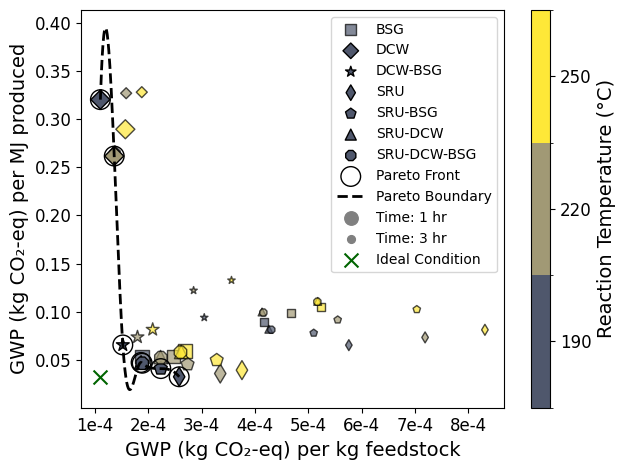

In [79]:
dcw_data = get_gwp_data('rawDCW_', ['Feedstock', 'Hydrochar HHV'])
bsg_data = get_gwp_data('stdBSG_', ['Feedstock', 'Hydrochar HHV'])
sru_data = get_gwp_data('stdSRU_', ['Feedstock', 'Hydrochar HHV'])
rawSRU50_rawDCW50 = get_gwp_data('rawSRU50_rawDCW50_', ['Feedstock', 'Hydrochar HHV'])
rawSRU50_rawBSG50 = get_gwp_data('rawSRU50_rawBSG50_', ['Feedstock', 'Hydrochar HHV'])
rawDCW50_rawBSG50 = get_gwp_data('rawDCW50_rawBSG50_', ['Feedstock', 'Hydrochar HHV'])
rawSRU33_rawDCW33_rawBSG33 = get_gwp_data('rawSRU33_rawDCW33_rawBSG33_', ['Feedstock', 'Hydrochar HHV'])
data = pd.concat([dcw_data, bsg_data, sru_data, rawSRU50_rawDCW50, rawSRU50_rawBSG50, rawDCW50_rawBSG50, rawSRU33_rawDCW33_rawBSG33], 
                 ignore_index=True, sort=False)

# Compute Pareto front
pareto_front = get_pareto_front(data)

data[['Feedstock_Type', 'Temperature', 'Time']] = data['name'].str.extract(r'([a-zA-Z0-9_]+)_(\d+C)_(\d+hr)')
data['Temperature'] = data['Temperature'].str.replace('C', '').astype(float)
data['Time'] = data['Time'].str.replace('hr', '').astype(float)
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('raw', '')
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('std', '')
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('_', '')
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('_', '')
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('50', '-')
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('33', '-')
data['Feedstock_Type'] = data['Feedstock_Type'].str.rstrip('-')

# Create a 2D scatter plot
fig, ax = plt.subplots()

# Define marker styles for feedstocks
feedstock_markers = {'DCW': 'D', 'BSG': 's', 'SRU': 'd',
                     'SRU-DCW': '^','SRU-BSG': 'p', 'DCW-BSG': '*', 'SRU-DCW-BSG': '8'}

# Normalize temperature to a color map (for temperature gradients)
cmap = ListedColormap(plt.cm.cividis(np.linspace(0.3, 1, 3)))
temperature_norm = BoundaryNorm([175, 205, 235, 265], cmap.N)

# Plot data points with varying marker sizes for reaction time and color for temperature
for feedstock, group_data in data.groupby('Feedstock_Type'):
    # Check if any points in the group are on the Pareto front
    is_pareto = group_data[['Feedstock', 'Hydrochar HHV']].apply(lambda x: any(np.all(x == pareto_point) for pareto_point in pareto_front), axis=1)

    # Set alpha (opacity) based on whether points are on the Pareto front
    # Full opacity for Pareto front, reduced for others
    alpha_value = np.where(is_pareto, 1, 0.7)  
    
    scatter = ax.scatter(group_data.iloc[:, 1], group_data.iloc[:, 2],
                         c=group_data['Temperature'], cmap=cmap, norm=temperature_norm,
                         marker=feedstock_markers[feedstock],
                         s= 75 / (group_data['Time']*0.8),  # Adjust marker size based on reaction time (multiplied for clarity)
                         edgecolor='black', label=feedstock, alpha=alpha_value)

# Plot Pareto front (with distinct markers)
ax.scatter(pareto_front[:, 0], pareto_front[:, 1], color='none', label='Pareto Front', s=200, edgecolor='k')

# Sort Pareto front points for interpolation
sorted_pareto = pareto_front[np.argsort(pareto_front[:, 0])]

# Create spline for a smooth curve
x_pareto = sorted_pareto[:, 0]
y_pareto = sorted_pareto[:, 1]
spline = make_interp_spline(x_pareto, y_pareto, k=3)  # k=3 for cubic spline

# Generate smooth points
x_smooth = np.linspace(x_pareto.min(), x_pareto.max(), 300)
y_smooth = spline(x_smooth)

# Plot the smooth dashed Pareto front curve
ax.plot(x_smooth, y_smooth, color='black', linestyle='--', linewidth=2, label='Pareto Boundary')

# Add dummy scatter points for time legend
for time_value in data['Time'].unique():
    ax.scatter([], [], s=75/(time_value*0.8), color='gray', label=f'Time: {int(time_value)} hr')  # Gray markers for clarity

# Add colorbar to indicate temperature
cbar = plt.colorbar(scatter, ax=ax, ticks=[190,220,250])
cbar.set_label('Reaction Temperature (°C)', fontsize=14)

# Add legend and make it colorblind-friendly
ax.legend(title="Feedstock Type", loc='upper right')

# Adding ideal point to the plot
ideal_x = data['Feedstock'].min()
ideal_y = data['Hydrochar HHV'].min()
ax.scatter(ideal_x, ideal_y, color='darkgreen', marker='x', s=100, label='Ideal Condition', zorder=5)


# Labels and title
ax.set_xlabel('GWP (kg CO\u2082-eq) per kg feedstock', fontsize=14)
ax.set_ylabel('GWP (kg CO\u2082-eq) per MJ produced', fontsize=14)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0e}'.replace('e-0', 'e-').replace('e+0', 'e+')))
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.legend(prop={'size': 10})

# Removing title for manuscript figure 
# ax.set_title(f'Climate Change Impacts Normalized to Hydrochar HHV & Feedstock')

# Ensure layout is tidy and readable
plt.tight_layout()

# Show plot
plt.show()

In [80]:
data = pd.concat([dcw_data, bsg_data, sru_data, rawSRU50_rawDCW50, rawSRU50_rawBSG50, rawDCW50_rawBSG50, rawSRU33_rawDCW33_rawBSG33], 
                 ignore_index=True, sort=False)
dominant, non_dominant = pareto_sort(data)
dominant_data = pd.DataFrame(dominant, columns=['name', 'Feedstock', 'Hydrochar HHV'])

We can once again apply the Multiple-Criteria Decision Making (MCDM) method, Technique for Order Preference by Similarity to Ideal Solution (TOPSIS) to determine the most optimal solutions.  

In [81]:
dominant_data

name  Feedstock  Hydrochar HHV
0                       rawDCW_190C_1hr   0.000110       0.320015
2                       rawDCW_220C_1hr   0.000136       0.261470
12                      stdSRU_190C_1hr   0.000258       0.032526
18           rawSRU50_rawDCW50_190C_1hr   0.000186       0.047383
24           rawSRU50_rawBSG50_190C_1hr   0.000223       0.041024
30           rawDCW50_rawBSG50_190C_1hr   0.000152       0.065553
36  rawSRU33_rawDCW33_rawBSG33_190C_1hr   0.000188       0.046558

In [82]:
data = pd.concat([dcw_data, bsg_data, sru_data, rawSRU50_rawDCW50, rawSRU50_rawBSG50, rawDCW50_rawBSG50, rawSRU33_rawDCW33_rawBSG33], 
                 ignore_index=True, sort=False)
criteria_cols = ['Feedstock', 'Hydrochar HHV']
data_sorted = topsis(dominant_data, criteria_cols)

In [83]:
data_sorted

name  Feedstock  Hydrochar HHV  TOPSIS Score
0           rawDCW50_rawBSG50_190C_1hr   0.000152       0.065553      0.845741
1           rawSRU50_rawDCW50_190C_1hr   0.000186       0.047383      0.803981
2  rawSRU33_rawDCW33_rawBSG33_190C_1hr   0.000188       0.046558      0.800430
3           rawSRU50_rawBSG50_190C_1hr   0.000223       0.041024      0.738888
4                      stdSRU_190C_1hr   0.000258       0.032526      0.690544
5                      rawDCW_220C_1hr   0.000136       0.261470      0.345135
6                      rawDCW_190C_1hr   0.000110       0.320015      0.309456

In [84]:
# Redefining truncate_name helper function for composite feedstocks
def truncate_name(name):
    truncated_name = re.sub(r'_sa_(lb|ub)', '', name)
    truncated_name = truncated_name.replace('hydrochar production, ', '')
    truncated_name = truncated_name.replace('raw', '')
    truncated_name = truncated_name.replace('std', '')
    truncated_name = truncated_name.replace('50_', '-')
    truncated_name = truncated_name.replace('33_', '-')
    truncated_name = truncated_name.replace('-1', ', 1')
    truncated_name = truncated_name.replace('-2', ', 2')
    truncated_name = truncated_name.replace('_', ', ')
    truncated_name = truncated_name.replace('0C', '0°C')
    return truncated_name

In [85]:
# Exporting all points to Excel file 
path = 'results/TOPSIS-scores.xlsx'
with pd.ExcelWriter(path, engine='xlsxwriter') as writer:
    df = pd.DataFrame(topsis(data, criteria_cols))
    df['name'] = df['name'].apply(truncate_name)
    df.to_excel(writer, sheet_name='Composite + Original Feedstocks', index=False)

In [86]:
# Identifying most favorable reactor condition for each feedstock on Pareto front
data_sorted[['Feedstock_Type', 'Temperature', 'Duration']] = data_sorted['name'].str.extract(r'(.+?)_(\d+C)_(\d+hr)')
data_sorted = data_sorted.drop_duplicates(subset='Feedstock_Type', keep='first')

In [87]:
data_sorted

name  Feedstock  Hydrochar HHV  \
0           rawDCW50_rawBSG50_190C_1hr   0.000152       0.065553   
1           rawSRU50_rawDCW50_190C_1hr   0.000186       0.047383   
2  rawSRU33_rawDCW33_rawBSG33_190C_1hr   0.000188       0.046558   
3           rawSRU50_rawBSG50_190C_1hr   0.000223       0.041024   
4                      stdSRU_190C_1hr   0.000258       0.032526   
5                      rawDCW_220C_1hr   0.000136       0.261470   

   TOPSIS Score              Feedstock_Type Temperature Duration  
0      0.845741           rawDCW50_rawBSG50        190C      1hr  
1      0.803981           rawSRU50_rawDCW50        190C      1hr  
2      0.800430  rawSRU33_rawDCW33_rawBSG33        190C      1hr  
3      0.738888           rawSRU50_rawBSG50        190C      1hr  
4      0.690544                      stdSRU        190C      1hr  
5      0.345135                      rawDCW        220C      1hr

Normalization on a per hydrochar produced and energy basis (HC / HHV) do not exhibit significant tradeoffs. 

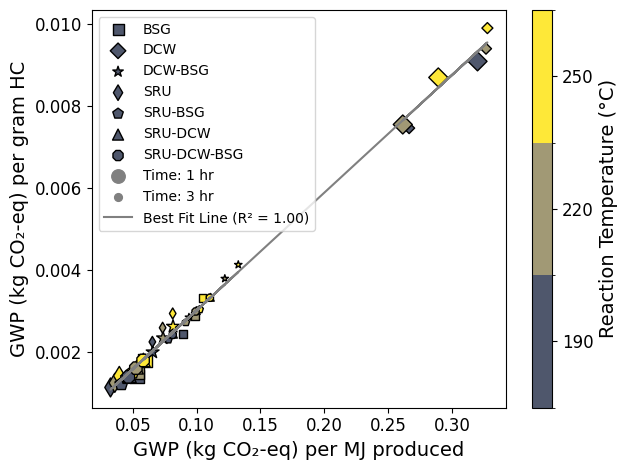

In [88]:
dcw_data = get_gwp_data('rawDCW_', ['Hydrochar', 'Hydrochar HHV'])
bsg_data = get_gwp_data('stdBSG_', ['Hydrochar', 'Hydrochar HHV'])
sru_data = get_gwp_data('stdSRU_', ['Hydrochar', 'Hydrochar HHV'])
rawSRU50_rawDCW50 = get_gwp_data('rawSRU50_rawDCW50_', ['Hydrochar', 'Hydrochar HHV'])
rawSRU50_rawBSG50 = get_gwp_data('rawSRU50_rawBSG50_', ['Hydrochar', 'Hydrochar HHV'])
rawDCW50_rawBSG50 = get_gwp_data('rawDCW50_rawBSG50_', ['Hydrochar', 'Hydrochar HHV'])
rawSRU33_rawDCW33_rawBSG33 = get_gwp_data('rawSRU33_rawDCW33_rawBSG33_', ['Hydrochar', 'Hydrochar HHV'])
data = pd.concat([dcw_data, bsg_data, sru_data, rawSRU50_rawDCW50, rawSRU50_rawBSG50, rawDCW50_rawBSG50, rawSRU33_rawDCW33_rawBSG33], 
                 ignore_index=True, sort=False)

# Compute Pareto front
pareto_front = get_pareto_front(data)

data[['Feedstock_Type', 'Temperature', 'Time']] = data['name'].str.extract(r'([a-zA-Z0-9_]+)_(\d+C)_(\d+hr)')
data['Temperature'] = data['Temperature'].str.replace('C', '').astype(float)
data['Time'] = data['Time'].str.replace('hr', '').astype(float)
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('raw', '')
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('std', '')
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('_', '')
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('_', '')
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('50', '-')
data['Feedstock_Type'] = data['Feedstock_Type'].str.replace('33', '-')
data['Feedstock_Type'] = data['Feedstock_Type'].str.rstrip('-')

# Create a 2D scatter plot
fig, ax = plt.subplots()

# Define marker styles for feedstocks
feedstock_markers = {'DCW': 'D', 'BSG': 's', 'SRU': 'd',
                     'SRU-DCW': '^','SRU-BSG': 'p', 'DCW-BSG': '*', 'SRU-DCW-BSG': '8'}

# Normalize temperature to a color map (for temperature gradients)
cmap = ListedColormap(plt.cm.cividis(np.linspace(0.3, 1, 3)))
temperature_norm = BoundaryNorm([175, 205, 235, 265], cmap.N)

# Plot data points with varying marker sizes for reaction time and color for temperature
for feedstock, group_data in data.groupby('Feedstock_Type'):
    # Check if any points in the group are on the Pareto front
    is_pareto = group_data[['Hydrochar', 'Hydrochar HHV']].apply(lambda x: any(np.all(x == pareto_point) for pareto_point in pareto_front), axis=1)

    # Set alpha based on whether points are on the Pareto front
    alpha_value = np.where(is_pareto, 1, 1)  # Full opacity for Pareto front, reduced for others
    
    scatter = ax.scatter(group_data.iloc[:, 2], group_data.iloc[:, 1],
                         c=group_data['Temperature'], cmap=cmap, norm=temperature_norm,
                         marker=feedstock_markers[feedstock],
                         s= 75 / (group_data['Time']*0.8),  # Adjust marker size based on reaction time (multiplied for clarity)
                         edgecolor='black', label=feedstock, alpha=alpha_value)

# Add dummy scatter points for time legend
for time_value in data['Time'].unique():
    ax.scatter([], [], s=75/(time_value*0.8), color='gray', label=f'Time: {int(time_value)} hr')  # Gray markers for clarity

# Add colorbar to indicate temperature
cbar = plt.colorbar(scatter, ax=ax, ticks=[190,220,250])
cbar.set_label('Reaction Temperature (°C)', fontsize=14)

# Add legend and make it colorblind-friendly
ax.legend(title="Feedstock Type", loc='upper right')

coefficients = np.polyfit(data.iloc[:, 2], data.iloc[:, 1], 1)  # Linear regression
slope, intercept = coefficients
line_fit = slope * data.iloc[:, 2] + intercept

# Calculate R-squared
residuals = data.iloc[:, 1] - line_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((data.iloc[:, 1] - np.mean(data.iloc[:, 1]))**2)
r_squared = 1 - (ss_res / ss_tot)

# Plot the line of best fit
ax.plot(data.iloc[:, 2], line_fit, color='gray', label=f'Best Fit Line (R² = {r_squared:.2f})')

# Labels and title
ax.set_xlabel('GWP (kg CO\u2082-eq) per MJ produced', fontsize=14)
ax.set_ylabel('GWP (kg CO\u2082-eq) per gram HC', fontsize=14)
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.legend(prop={'size': 10})


# Ensure layout is tidy and readable
plt.tight_layout()

# Show plot
plt.show()

## 4: Uncertainty Analysis 
From the initial LCA baseline models, we can determine that our interpretations rely heavily upon our normalization technique. There are different decisions that can be made based on viewing HTC as a process for managing food waste (standardizing it to a quantity of food waste), a process for producing hydrochar (standardizing it to per quantity of hydrochar produced), or considering the application of hydrochar in a downstream process (in this case, combustion as a substitute for coal). 

From our multi-objective optimization, we see that there are no solutions that are dominant or more optimal than the other ones, when equally weighed. While these initial results are meaningful, it's important to determine if this holds true under uncertainty as <i>"all models are wrong, but some are useful." - George Box</i>

To ensure that this analysis is comprehensively done, sensitivity analyses and Monte Carlo analyses will be used for factoring in uncertainty within experimental & feedstock parameters and corresponding output conditions. As this LCA is done at lab-scale, uncertainties within the impact scores of exchange parameters are not factored into consideration. 

In [89]:
# Creating seed to ensure reproducibility
np.random.seed(1)

In [90]:
# Importing Additional Packages
from tqdm import tqdm
import multiprocessing as mp
from collections import defaultdict

### 4.1: Uncertainty Analysis: Moisture Content 
To determine the impact of moisture content on our results, we'll conduct a local sensitivty analysis to determine the impacts of moisture on our impact assessment. 

In [91]:
# Add feedstocks to sensitivity analysis manager 
sa_feedstocks = FeedstockManager()

elementary_feedstocks = create_elementary_feedstocks()
excluded_feedstocks = {"rawSRU", "rawBSG"}

def create_sa_feedstocks(feedstock): 
    lb_feedstock = copy.deepcopy(feedstock)
    lb_feedstock.name = lb_feedstock.name + '_sa_lb'
    if lb_feedstock.moisture - (lb_feedstock.moisture_std / 100) < 0.504: 
        lb_feedstock.moisture = 0.504
    else: 
        lb_feedstock.moisture = lb_feedstock.moisture - (lb_feedstock.moisture_std / 100)
    lb_feedstock.moisture_std = 0
    
    ub_feedstock = copy.deepcopy(feedstock)
    ub_feedstock.name = ub_feedstock.name + '_sa_ub'
    if ub_feedstock.moisture + (ub_feedstock.moisture_std/100) > 0.95:
        ub_feedstock.moisture = 0.95
    else: 
        ub_feedstock.moisture = ub_feedstock.moisture + (ub_feedstock.moisture_std/100)
    ub_feedstock.moisture_std = 0
    
    return lb_feedstock, ub_feedstock
    

for attr, feedstocks in elementary_feedstocks.__dict__.items():
    for feedstock in feedstocks:
        if feedstock.name not in excluded_feedstocks:            
            lb_feedstock, ub_feedstock = create_sa_feedstocks(feedstock)
            sa_feedstocks.add_feedstock(lb_feedstock)
            sa_feedstocks.add_feedstock(ub_feedstock)
            # sa_feedstocks.add_feedstock(feedstock)

composite_feedstocks = create_composite_elementary_feedstocks()
for attr, feedstocks in composite_feedstocks.__dict__.items():
    for feedstock in feedstocks:  
        lb_feedstock, ub_feedstock = create_sa_feedstocks(feedstock)
        sa_feedstocks.add_feedstock(lb_feedstock)
        sa_feedstocks.add_feedstock(ub_feedstock)
        # sa_feedstocks.add_feedstock(feedstock)

In [92]:
# # If needed, delete existing activities
# for act in [act for act in eidb if 'hydrochar production' in act['name']]:
#     act.delete()
    
# for act in [act for act in eidb if 'hydrochar production' in act['name']]:
#     print(act)

In [93]:
# Creating activities for sensitivity analysis 
for attr, feedstocks in sa_feedstocks.__dict__.items():
    for feedstock in feedstocks:
        try:
            create_hydrochar_activity(feedstock)
        except: 
            print(f"Hydrochar activity: {feedstock.name}_{feedstock.temp}C_{feedstock.time}hr already exists. Continuing.")
            continue

[{'name': 'feedstock_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 4.187904741062433}, {'name': 'water_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 1.2665034499180747}, {'name': 'heat_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 1.7703282686958266}, {'name': 'electricity_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 0.0519272692860352}, {'name': 'co2_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 0.012816402776327064}, {'name': 'wastewater_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 4.441591788204181}, {'name': 'post_processing_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 0.403}]

[{'name': 'feedstock_HTC_stdSRU_sa_ub_190C_1hr', 'amount': 4.651776609726542}, {'name': 'water_HTC_stdSRU_sa_ub_190C_1hr', 'amount': 1.5626096040891988}, {'name': 'heat_HTC_stdSRU_sa_ub_190C_1hr', 'amount': 1.8387364536139585}, {'name': 'electricity_HTC_stdSRU_sa_ub_190C_1hr', 'amount': 0.05397052546400499}, {'name': 'co2_HTC_stdSRU_sa_ub_190C_1hr', 'amount': 0.014602148195586216}, {'name': 'wastewater_HTC_stdSRU_sa_ub_190C_1hr', 'amount': 5.199784065620155}, 

In [94]:
# Ensuring all HC activities are in database, should result in 126
print(len([act for act in eidb if 'hydrochar production' in act['name']]))

126


In [95]:
# Computing LCIA Results for Climate Change across normalization categories 
process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']
scaling_factor = 0.001

for attr, feedstocks in sa_feedstocks.__dict__.items():
    
        for feedstock in feedstocks:
            if str(feedstock.name).find('sa') != -1:
                for act in [act for act in eidb if f"hydrochar production, {feedstock.name}_{feedstock.temp}C_{feedstock.time}hr" in act['name']]:
                    activity_lcia = HydrocharLCIA(act['name']) 
                    feedstock_lcia = HydrocharLCIA(act['name']) 
                    hc_hhv_lcia = HydrocharLCIA(act['name']) 
                    
                    feedstock_normalization_factor = 1 / feedstock.quantity
                    hc_hhv = get_parameter(activity['name'], 'HHV_HC')
                    hc_hhv_normalization_factor = hc_hhv / 1000
                            
                    method = [m for m in bw.methods if 'TRACI' in str(m) and 'global warming' in str(m)][0]
                    impact_category = get_impact_category(method)
                    method_key = method
                    unit = bw.methods.get(method_key).get('unit')
                    
                    for i in range(len(process_categories)):
                        process_catgeory = process_categories[i]
                        exc = [exc for exc in act.exchanges()][i]
                            
                        functional_amount = exc['amount'] * scaling_factor
                        functional_unit = { exc.input: functional_amount}
                        temp_lca = bw.LCA(functional_unit, method_key)
                        
                        if 'Carbon dioxide' in str(exc.input) and 'climate change' in str(method_key):
                            score = -1*functional_amount
                            activity_lcia.set_impact_score(impact_category, process_catgeory, score, unit)
                            
                        # Will not ever execute as climate change is the only 
                        elif 'Carbon dioxide' in str(exc.input):
                            score = 0 
                            activity_lcia.set_impact_score(impact_category, process_catgeory, score, unit)
                        
                        else:
                            temp_lca.lci()
                            temp_lca.lcia()
                            score = temp_lca.score
                            
                            activity_lcia.set_impact_score(impact_category, process_catgeory, score, unit)  
                            feedstock_lcia.set_impact_score(impact_category, process_catgeory, score * feedstock_normalization_factor, unit)
                            hc_hhv_lcia.set_impact_score(impact_category, process_catgeory, score / hc_hhv_normalization_factor, unit)
                        
                    
                baseline_lcia_manager.add_hydrochar(activity_lcia)
                feedstock_lcia_manager.add_hydrochar(feedstock_lcia)
                hc_hhv_lcia_manager.add_hydrochar(hc_hhv_lcia)
                
                print(activity_lcia.name , "successfully calculated & added to LCIA Managers.")    

hydrochar production, stdSRU_sa_lb_190C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_ub_190C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_lb_190C_3hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_ub_190C_3hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_lb_220C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_ub_220C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_lb_220C_3hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_ub_220C_3hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_lb_250C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_ub_250C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_lb_250C_3hr successfully cal

In [96]:
def create_summary_table(lcia_list, normalization_factor):
    # Grouping global warming potentials by truncated names
    grouped_data = defaultdict(list)

    for item in lcia_list:
        truncated_name = truncate_name(item.name)
        # Normalize the total impact score if a factor is provided
        impact_score = item.get_total_impact_score('climate_change')
        grouped_data[truncated_name].append(impact_score)

    # Calculate mean and standard deviation for each group
    summary_data = {
        "Feedstock & Reactor Conditions": [],
        f"Mean Impact per {normalization_factor}": [],
        "Standard Deviation": [], 
        "Coefficient of Variation (%)" : []
    }

    for name, normalized_scores in grouped_data.items():
        summary_data["Feedstock & Reactor Conditions"].append(name)
        summary_data[f"Mean Impact per {normalization_factor}"].append(np.mean(normalized_scores))
        summary_data["Standard Deviation"].append(np.std(normalized_scores))
        summary_data["Coefficient of Variation (%)"].append(100*np.std(normalized_scores)/np.mean(normalized_scores))

    # Convert to pandas DataFrame for tabular format
    summary_table = pd.DataFrame(summary_data)

    # Sort table by mean impact score
    # summary_table = summary_table.sort_values(by=f"Mean Impact per {normalization_factor}", ascending=False)
    summary_table = summary_table.sort_values(by=f"Coefficient of Variation (%)", ascending=False)

    return summary_table

In [97]:
def plot_variability_heatmap(data, value_column): 
    """
    Creates a heatmap that demonstrates variability across feedstocks and reactor conditions.

    Parameters:
        data (pd.DataFrame): The input dataset containing feedstock, reactor conditions, value column, and standard deviation.
        value_column (str): The column name for the values to be plotted (e.g., "Mean Impact per gram hydrochar / HHV").
        units (str): The units for the values (e.g., (kg CO\u2082-eq / MJ))
    """
    data[['Feedstock', 'Reactor Conditions']] = data['Feedstock & Reactor Conditions'].str.split(', ', n=1, expand=True)

    # Reorganize x-axis order with line breaks
    condition_order = [
        "190°C\n1hr", "190°C\n3hr", "220°C\n1hr", "220°C\n3hr", "250°C\n1hr", "250°C\n3hr"
    ]
    feedstock_order = [
        'BSG', 'DCW', 'SRU', 'DCW-BSG', 'SRU-DCW', 'SRU-BSG', 'SRU-DCW-BSG' 
    ]
    data['Reactor Conditions'] = data['Reactor Conditions'].str.replace(", ", "\n")
    data['Reactor Conditions'] = pd.Categorical(data['Reactor Conditions'], ordered=True, categories=condition_order)
    data['Feedstock'] = pd.Categorical(data['Feedstock'], ordered=True, categories=feedstock_order)
    
    # Create a pivot table for the heatmap
    heatmap_data = data.pivot_table(
        index='Feedstock', columns='Reactor Conditions', values=value_column
    )

    # Set up the heatmap figure
    plt.figure(figsize=(10, 6))
    sns.set_theme(style="whitegrid")
    heatmap = sns.heatmap(
        heatmap_data, annot=True, fmt=".2f", cmap="Reds",
        cbar_kws={'label': f"{value_column}"}
    )

    # Customize the plot
    # heatmap.set_title("Variability Across Feedstocks and Reactor Conditions", fontsize=16, pad=20)
    heatmap.set_xlabel("Reactor Conditions", fontsize=14)
    heatmap.set_ylabel("Feedstock", fontsize=14)
    plt.xticks(ha='center', fontsize=12)
    plt.yticks(fontsize=12)

    # Adjust layout for better fit
    plt.tight_layout()

    # Show the plot
    plt.show()

In [98]:
def plot_facet_grid_stacked_bars(data, value_column, units):
    """
    Create a reorganized FacetGrid of stacked bar plots with error bars for varying feedstocks and reactor conditions.

    Parameters:
        data (pd.DataFrame): The input dataset containing feedstock, reactor conditions, value column, and standard deviation.
        value_column (str): The column name for the values to be plotted (e.g., "Mean Impact per gram hydrochar / HHV").
        units (str): The units for the values (e.g., (kg CO\u2082-eq / MJ))
    """
    
    # Split "Feedstock & Reactor Conditions" into separate columns
    data[['Feedstock', 'Reactor Conditions']] = data['Feedstock & Reactor Conditions'].str.split(', ', n=1, expand=True)

    # Reorganize x-axis order with line breaks
    condition_order = [
        "190°C\n1hr", "190°C\n3hr", "220°C\n1hr", "220°C\n3hr", "250°C\n1hr", "250°C\n3hr"
    ]
    data['Reactor Conditions'] = data['Reactor Conditions'].str.replace(", ", "\n")
    data['Reactor Conditions'] = pd.Categorical(data['Reactor Conditions'], ordered=True, categories=condition_order)

    # Rearrange feedstocks to specify row assignment
    first_row = ['BSG', 'DCW', 'SRU']
    second_row = ['DCW-BSG', 'SRU-BSG', 'SRU-DCW', 'SRU-DCW-BSG']
    feedstocks = first_row + second_row

    # Set up grid layout: 1st row (3 plots) and 2nd row (4 plots)
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(22, 12))
    axes = axes.flatten()

    # Plot each feedstock in its corresponding subplot
    for idx, feedstock in enumerate(feedstocks):
        ax = axes[idx]
        subset = data[data['Feedstock'] == feedstock]

        # Initialize cumulative bottoms for stacking
        bottoms = np.zeros(len(condition_order))

        for _, row in subset.iterrows():
            condition_idx = condition_order.index(row["Reactor Conditions"])
            ax.bar(
                x=row["Reactor Conditions"],
                height=row[value_column],
                bottom=bottoms[condition_idx],
                yerr=row["Standard Deviation"],
                capsize=4,
                color='lightblue'
            )
            bottoms[condition_idx] += row[value_column]

        # Add title for each grid
        ax.set_title(feedstock, fontsize=14)
        ax.tick_params(axis='x', rotation=0)
        # ax.get_yaxis().set_visible(False)  # Remove individual y-axis
        # ax.get_xaxis().set_visible(False)  # Remove individual x-axis

    # Hide unused subplots
    for idx in range(len(feedstocks), len(axes)):
        axes[idx].set_visible(False)

    # Add shared x and y axis labels
    fig.text(0.5, 0.04, "Reactor Conditions", ha='center', fontsize=16)
    if value_column == "Mean Impact per gram hydrochar":
        fig.text(0.05, 0.5, f'{value_column} {units}', va='center', rotation='vertical', fontsize=16)
    else: 
        fig.text(0.06, 0.5, f'{value_column} {units}', va='center', rotation='vertical', fontsize=16)
    # Adjust padding to avoid overlap
    plt.tight_layout(pad=2.0)
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.95)

    # Add a main title
    # fig.suptitle("FacetGrid of Stacked Bar Plots with Error Bars", fontsize=18)
    plt.show()

#### 4.1.1: Energy Basis: Moisture Content 

In [99]:
hc_hhv_lcia_list = [hc for attr, lcia in hc_hhv_lcia_manager.__dict__.items() for hc in lcia]
create_summary_table(hc_hhv_lcia_list, 'gram hydrochar / HHV')

Feedstock & Reactor Conditions  Mean Impact per gram hydrochar / HHV  \
0                 SRU, 250°C, 3hr                              0.093661   
7                 SRU, 250°C, 1hr                              0.044795   
13                SRU, 220°C, 3hr                              0.083004   
9                 SRU, 190°C, 1hr                              0.036522   
15                SRU, 220°C, 1hr                              0.039935   
12                SRU, 190°C, 3hr                              0.072768   
6                 BSG, 190°C, 1hr                              0.049097   
17                BSG, 190°C, 3hr                              0.084398   
16                BSG, 220°C, 1hr                              0.050936   
8                 DCW, 190°C, 3hr                              0.257278   
3                 BSG, 250°C, 3hr                              0.108467   
18            SRU-DCW, 190°C, 1hr                              0.047432   
20            SRU-DCW, 220°C, 1hr                              0.052989   
22            SRU-DCW, 250°C, 1hr                              0.058356   
1                 DCW, 220°C, 3hr                              0.319506   
5                 DCW, 190°C, 1hr                              0.313418   
14                DCW, 220°C, 1hr                              0.256450   
2                 BSG, 220°C, 3hr                              0.097034   
36        SRU-DCW-BSG, 190°C, 1hr                              0.046576   
38        SRU-DCW-BSG, 220°C, 1hr                              0.052408   
40        SRU-DCW-BSG, 250°C, 1hr                              0.058078   
10                DCW, 250°C, 1hr                              0.290201   
21            SRU-DCW, 220°C, 3hr                              0.099793   
11                DCW, 250°C, 3hr                              0.330387   
4                 BSG, 250°C, 1hr                              0.058710   
23            SRU-DCW, 250°C, 3hr                              0.110795   
24            SRU-BSG, 190°C, 1hr                              0.041035   
26            SRU-BSG, 220°C, 1hr                              0.045468   
19            SRU-DCW, 190°C, 3hr                              0.081846   
28            SRU-BSG, 250°C, 1hr                              0.049792   
30            DCW-BSG, 190°C, 1hr                              0.065559   
32            DCW-BSG, 220°C, 1hr                              0.073714   
34            DCW-BSG, 250°C, 1hr                              0.081523   
39        SRU-DCW-BSG, 220°C, 3hr                              0.099187   
41        SRU-DCW-BSG, 250°C, 3hr                              0.110405   
37        SRU-DCW-BSG, 190°C, 3hr                              0.081330   
33            DCW-BSG, 220°C, 3hr                              0.122086   
27            SRU-BSG, 220°C, 3hr                              0.091630   
35            DCW-BSG, 250°C, 3hr                              0.132623   
25            SRU-BSG, 190°C, 3hr                              0.077934   
29            SRU-BSG, 250°C, 3hr                              0.102394   
31            DCW-BSG, 190°C, 3hr                              0.093983   

    Standard Deviation  Coefficient of Variation (%)  
0             0.008794                      9.389668  
7             0.003849                      8.593379  
13            0.006840                      8.240809  
9             0.002869                      7.856470  
15            0.002906                      7.275655  
12            0.005282                      7.259095  
6             0.003037                      6.185783  
17            0.003559                      4.217105  
16            0.001690                      3.318480  
8             0.006730                      2.615755  
3             0.002743                      2.529191  
18            0.000953                      2.008598  
20            0.001046                      1.973260  
22     

In [100]:
# Exporting results to Excel file
path = 'results/Uncertainty_Analysis.xlsx'
with pd.ExcelWriter(path, engine='xlsxwriter') as writer:
    df = create_summary_table(hc_hhv_lcia_list, 'gram hydrochar / HHV')
    df.to_excel(writer, sheet_name='Mositure Content - HC_HHV', index=False)

/tmp/ipykernel_3806368/2271054288.py:24: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = data.pivot_table(


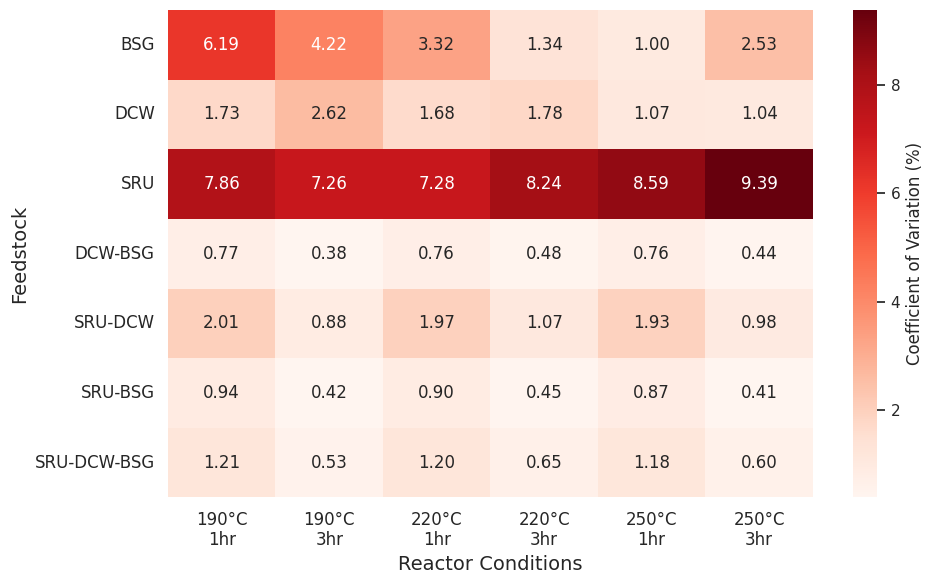

In [101]:
hc_hhv_lcia_list = [hc for attr, lcia in hc_hhv_lcia_manager.__dict__.items() for hc in lcia]
plotting_data = create_summary_table(hc_hhv_lcia_list, 'gram hydrochar / HHV')
plot_variability_heatmap(plotting_data, "Coefficient of Variation (%)")

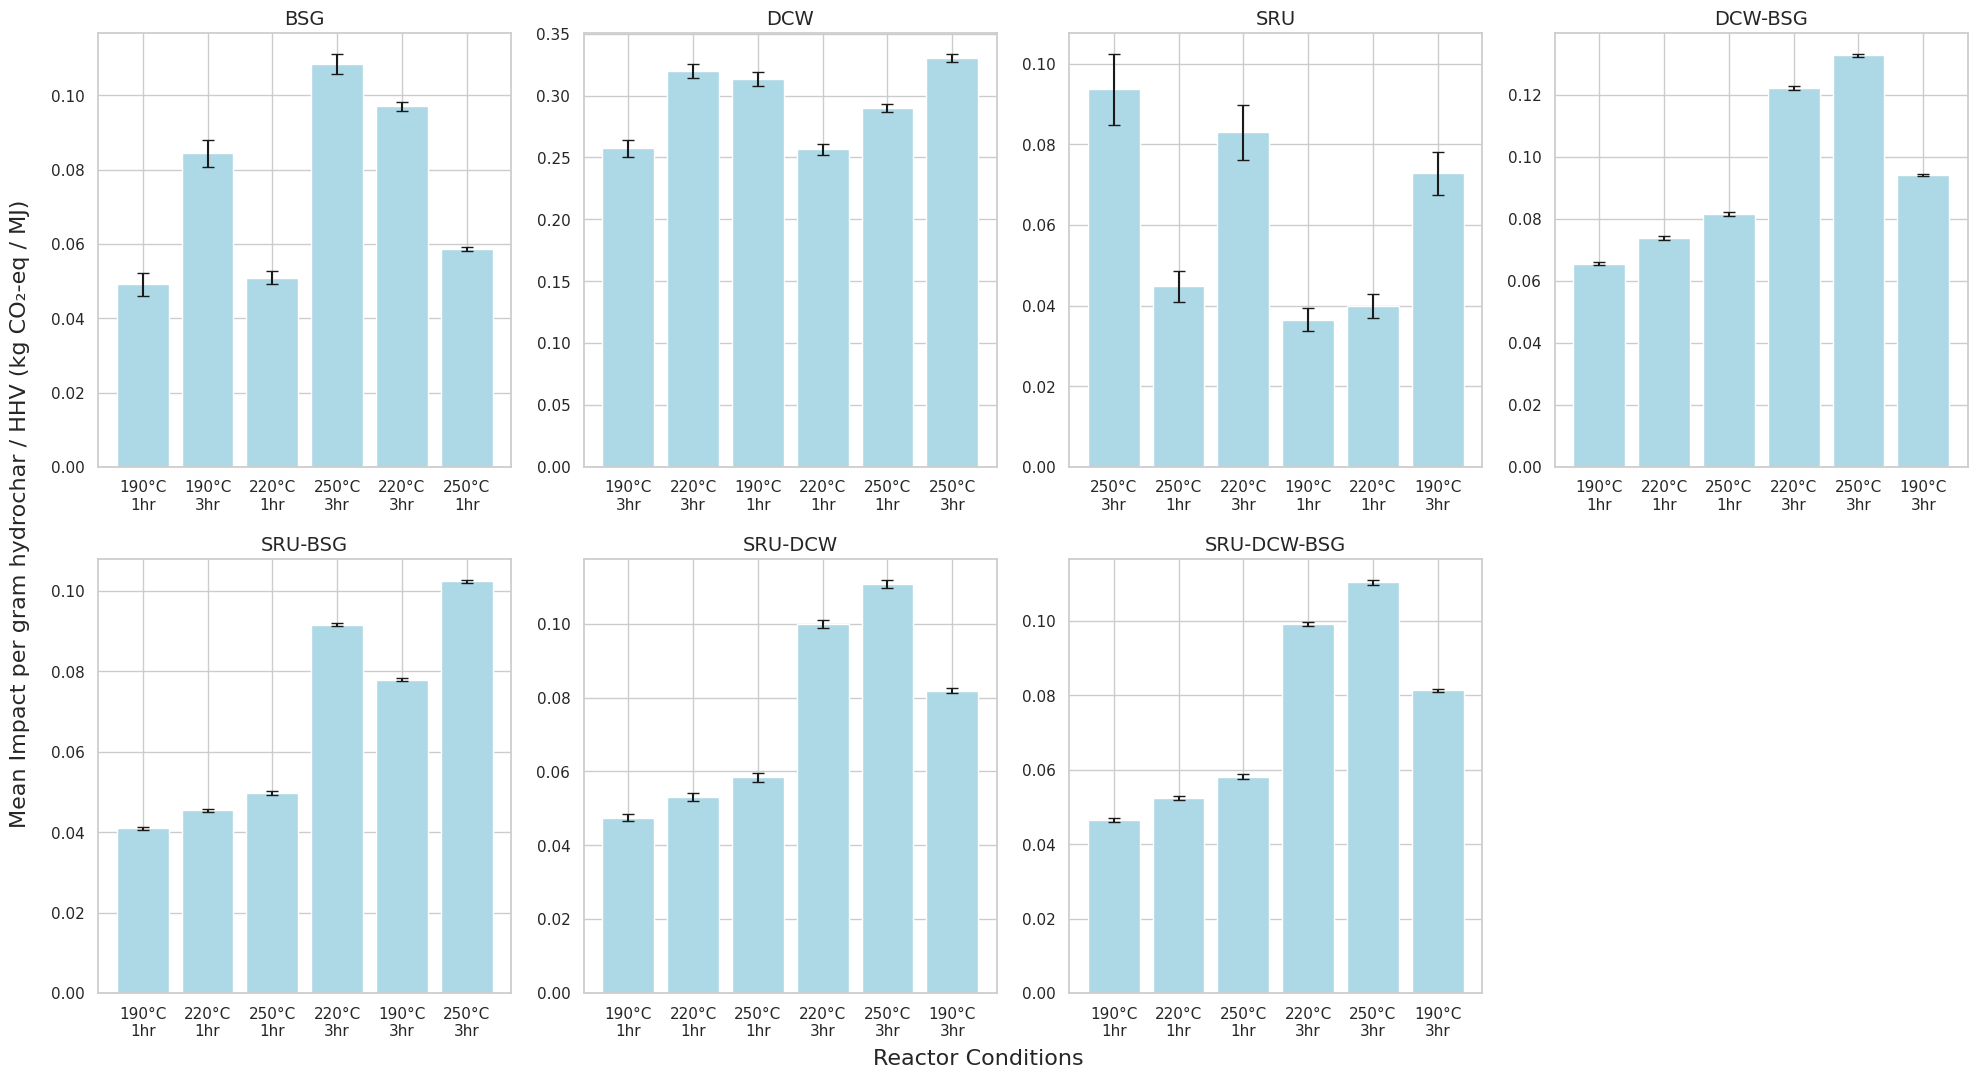

In [102]:
hc_hhv_lcia_list = [hc for attr, lcia in hc_hhv_lcia_manager.__dict__.items() for hc in lcia]
plotting_data = create_summary_table(hc_hhv_lcia_list, 'gram hydrochar / HHV')
plot_facet_grid_stacked_bars(plotting_data, "Mean Impact per gram hydrochar / HHV", '(kg CO\u2082-eq / MJ)')

#### 4.1.2: Feedstock Basis: Moisture Content 

In [103]:
# Exporting results to Excel file
feedstock_lcia_list = [hc for attr, lcia in feedstock_lcia_manager.__dict__.items() for hc in lcia]
create_summary_table(feedstock_lcia_list, 'gram feedstock')

Feedstock & Reactor Conditions  Mean Impact per gram feedstock  \
13                SRU, 220°C, 3hr                        0.000713   
0                 SRU, 250°C, 3hr                        0.000825   
12                SRU, 190°C, 3hr                        0.000573   
7                 SRU, 250°C, 1hr                        0.000369   
15                SRU, 220°C, 1hr                        0.000330   
9                 SRU, 190°C, 1hr                        0.000256   
19            SRU-DCW, 190°C, 3hr                        0.000426   
23            SRU-DCW, 250°C, 3hr                        0.000518   
21            SRU-DCW, 220°C, 3hr                        0.000413   
4                 BSG, 250°C, 1hr                        0.000259   
29            SRU-BSG, 250°C, 3hr                        0.000704   
16                BSG, 220°C, 1hr                        0.000240   
25            SRU-BSG, 190°C, 3hr                        0.000510   
27            SRU-BSG, 220°C, 3hr                        0.000555   
22            SRU-DCW, 250°C, 1hr                        0.000262   
37        SRU-DCW-BSG, 190°C, 3hr                        0.000431   
20            SRU-DCW, 220°C, 1hr                        0.000223   
18            SRU-DCW, 190°C, 1hr                        0.000186   
41        SRU-DCW-BSG, 250°C, 3hr                        0.000517   
39        SRU-DCW-BSG, 220°C, 3hr                        0.000416   
28            SRU-BSG, 250°C, 1hr                        0.000328   
3                 BSG, 250°C, 3hr                        0.000512   
26            SRU-BSG, 220°C, 1hr                        0.000274   
24            SRU-BSG, 190°C, 1hr                        0.000223   
2                 BSG, 220°C, 3hr                        0.000459   
10                DCW, 250°C, 1hr                        0.000154   
11                DCW, 250°C, 3hr                        0.000184   
6                 BSG, 190°C, 1hr                        0.000185   
40        SRU-DCW-BSG, 250°C, 1hr                        0.000260   
38        SRU-DCW-BSG, 220°C, 1hr                        0.000223   
36        SRU-DCW-BSG, 190°C, 1hr                        0.000188   
1                 DCW, 220°C, 3hr                        0.000156   
17                BSG, 190°C, 3hr                        0.000411   
14                DCW, 220°C, 1hr                        0.000134   
8                 DCW, 190°C, 3hr                        0.000136   
5                 DCW, 190°C, 1hr                        0.000109   
31            DCW-BSG, 190°C, 3hr                        0.000305   
35            DCW-BSG, 250°C, 3hr                        0.000356   
33            DCW-BSG, 220°C, 3hr                        0.000285   
34            DCW-BSG, 250°C, 1hr                        0.000208   
32            DCW-BSG, 220°C, 1hr                        0.000179   
30            DCW-BSG, 190°C, 1hr                        0.000152   

    Standard Deviation  Coefficient of Variation (%)  
13        2.688458e-05                      3.772384  
0         3.104445e-05                      3.762394  
12        2.128452e-05                      3.717434  
7         1.203604e-05                      3.258316  
15        1.068887e-05                      3.238129  
9         7.764044e-06                      3.037684  
19        1.289898e-05                      3.027990  
23        1.517171e-05                      2.930839  
21        1.175112e-05                      2.843544  
4         6.864168e-06                      2.648922  
29        1.567867e-05                      2.228443  
16        5.338067e-06                      2.223095  
25        1.132627e-05                      2.220216  
27        1.214350e-05                      2.187472  
22        5.175255e-06                      1.978670  
37        8.374227e-06                      1.944754  
20        4.317901e-06                      1.938041  
18        3.544333e-06                      1

In [104]:
# Exporting results to Excel file
path = 'results/Uncertainty_Analysis.xlsx'
with pd.ExcelWriter(path, engine='xlsxwriter') as writer:
    df = create_summary_table(feedstock_lcia_list, 'gram feedstock')
    df.to_excel(writer, sheet_name='Moisture Content - Feedstock', index=False)

/tmp/ipykernel_3806368/2271054288.py:24: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = data.pivot_table(


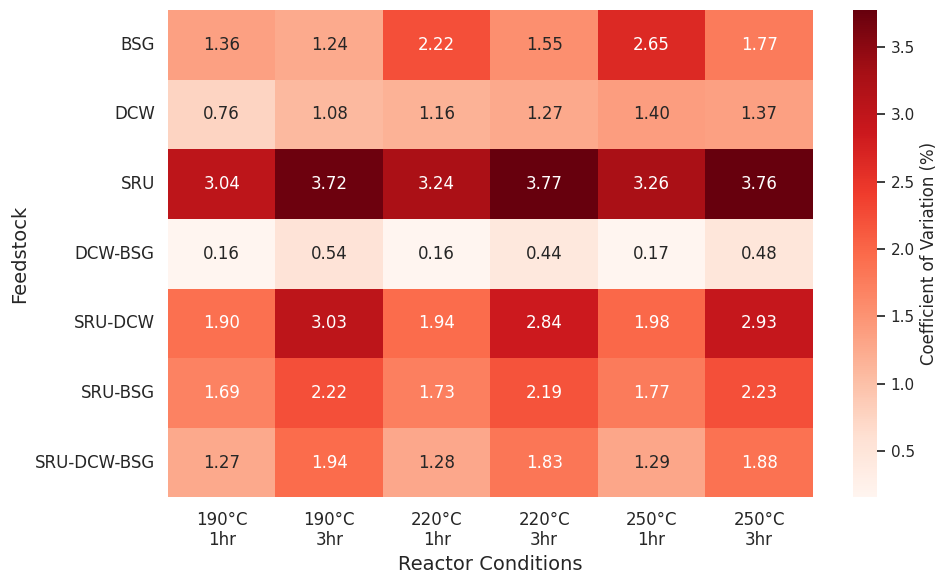

In [105]:
feedstock_lcia_list = [hc for attr, lcia in feedstock_lcia_manager.__dict__.items() for hc in lcia]
plotting_data = create_summary_table(feedstock_lcia_list, 'gram feedstock')
plot_variability_heatmap(plotting_data, "Coefficient of Variation (%)")

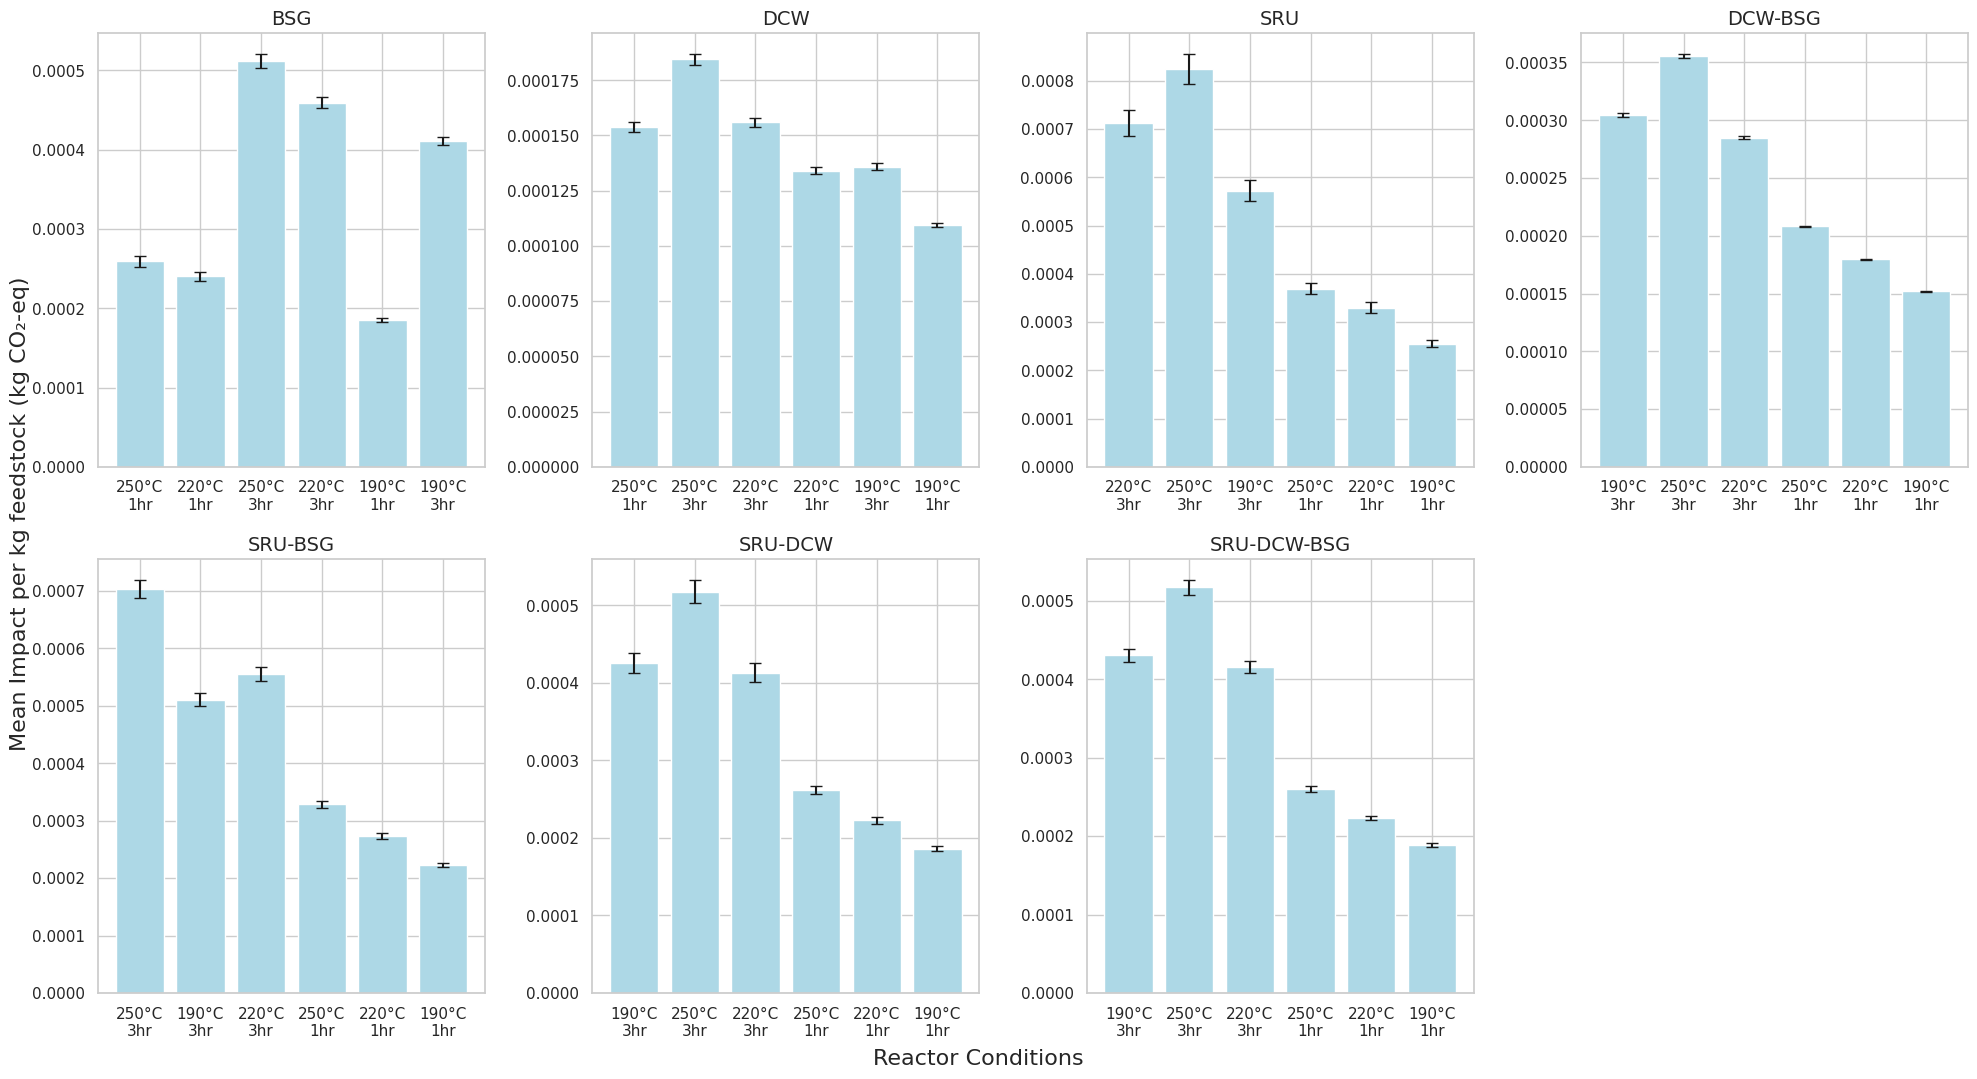

In [106]:
feedstock_lcia_list = [hc for attr, lcia in feedstock_lcia_manager.__dict__.items() for hc in lcia]
plotting_data = create_summary_table(feedstock_lcia_list, 'kg feedstock')
plot_facet_grid_stacked_bars(plotting_data, "Mean Impact per kg feedstock", '(kg CO\u2082-eq)')

#### 4.1.3: Hydrochar Basis: Moisture Content 

In [107]:
hydrochar_lcia_list = [hc for attr, lcia in baseline_lcia_manager.__dict__.items() for hc in lcia]
create_summary_table(hydrochar_lcia_list, 'gram hydrochar')

Feedstock & Reactor Conditions  Mean Impact per gram hydrochar  \
20            SRU-DCW, 220°C, 1hr                        0.001629   
22            SRU-DCW, 250°C, 1hr                        0.001809   
18            SRU-DCW, 190°C, 1hr                        0.001421   
9                 SRU, 190°C, 1hr                        0.001136   
7                 SRU, 250°C, 1hr                        0.001418   
40        SRU-DCW-BSG, 250°C, 1hr                        0.001795   
38        SRU-DCW-BSG, 220°C, 1hr                        0.001608   
15                SRU, 220°C, 1hr                        0.001248   
36        SRU-DCW-BSG, 190°C, 1hr                        0.001394   
21            SRU-DCW, 220°C, 3hr                        0.003014   
23            SRU-DCW, 250°C, 3hr                        0.003338   
24            SRU-BSG, 190°C, 1hr                        0.001217   
26            SRU-BSG, 220°C, 1hr                        0.001368   
19            SRU-DCW, 190°C, 3hr                        0.002436   
28            SRU-BSG, 250°C, 1hr                        0.001502   
10                DCW, 250°C, 1hr                        0.008815   
14                DCW, 220°C, 1hr                        0.007645   
11                DCW, 250°C, 3hr                        0.010021   
34            DCW-BSG, 250°C, 1hr                        0.002625   
32            DCW-BSG, 220°C, 1hr                        0.002341   
1                 DCW, 220°C, 3hr                        0.009512   
30            DCW-BSG, 190°C, 1hr                        0.001998   
39        SRU-DCW-BSG, 220°C, 3hr                        0.002990   
5                 DCW, 190°C, 1hr                        0.009178   
41        SRU-DCW-BSG, 250°C, 3hr                        0.003326   
8                 DCW, 190°C, 3hr                        0.007540   
12                SRU, 190°C, 3hr                        0.002249   
13                SRU, 220°C, 3hr                        0.002593   
0                 SRU, 250°C, 3hr                        0.002942   
37        SRU-DCW-BSG, 190°C, 3hr                        0.002419   
33            DCW-BSG, 220°C, 3hr                        0.003793   
4                 BSG, 250°C, 1hr                        0.001796   
6                 BSG, 190°C, 1hr                        0.001405   
27            SRU-BSG, 220°C, 3hr                        0.002723   
35            DCW-BSG, 250°C, 3hr                        0.004133   
16                BSG, 220°C, 1hr                        0.001517   
29            SRU-BSG, 250°C, 3hr                        0.003039   
25            SRU-BSG, 190°C, 3hr                        0.002300   
31            DCW-BSG, 190°C, 3hr                        0.002848   
3                 BSG, 250°C, 3hr                        0.003327   
2                 BSG, 220°C, 3hr                        0.002881   
17                BSG, 190°C, 3hr                        0.002435   

    Standard Deviation  Coefficient of Variation (%)  
20            0.000035                      2.147479  
22            0.000039                      2.135818  
18            0.000030                      2.099341  
9             0.000015                      1.344376  
7             0.000019                      1.320197  
40            0.000023                      1.305843  
38            0.000021                      1.304624  
15            0.000016                      1.270295  
36            0.000018                      1.264572  
21            0.000037                      1.215154  
23            0.000037                      1.120669  
24            0.000012                      0.982886  
26            0.000013                      0.979959  
19            0.000024                      0.973466  
28            0.000014                      0.951334  
10            0.000080                      0.907177  
14            0.000063                      0.823920  
11            0.000082                      0

In [108]:
# Exporting results to Excel file
path = 'results/Uncertainty_Analysis.xlsx'
with pd.ExcelWriter(path, engine='xlsxwriter') as writer:
    df = create_summary_table(hydrochar_lcia_list , 'gram hydrochar')
    df.to_excel(writer, sheet_name='Moisture Content - HC', index=False)

/tmp/ipykernel_3806368/2271054288.py:24: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = data.pivot_table(


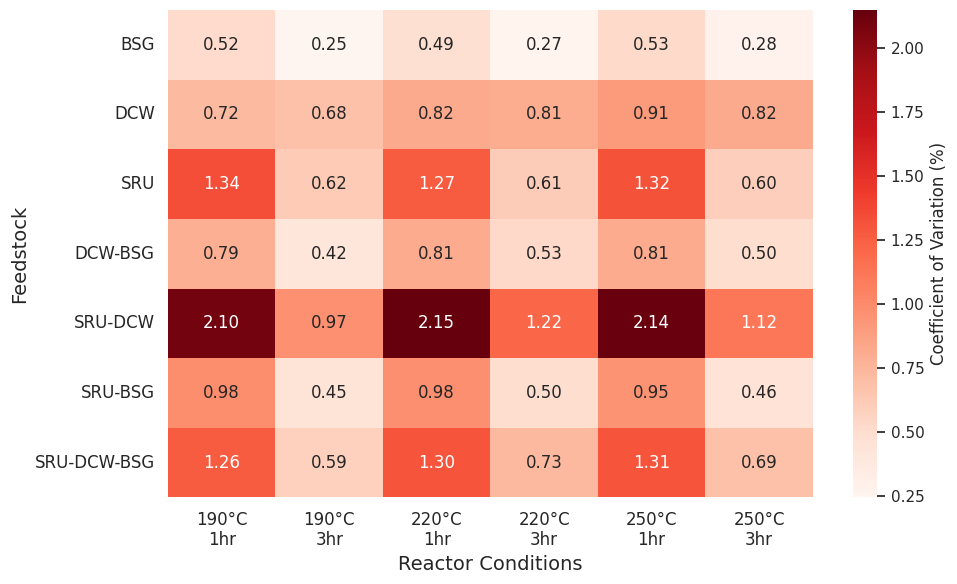

In [109]:
hydrochar_lcia_list = [hc for attr, lcia in baseline_lcia_manager.__dict__.items() for hc in lcia]
plotting_data = create_summary_table(hydrochar_lcia_list , 'gram hydrochar')
plot_variability_heatmap(plotting_data, "Coefficient of Variation (%)")

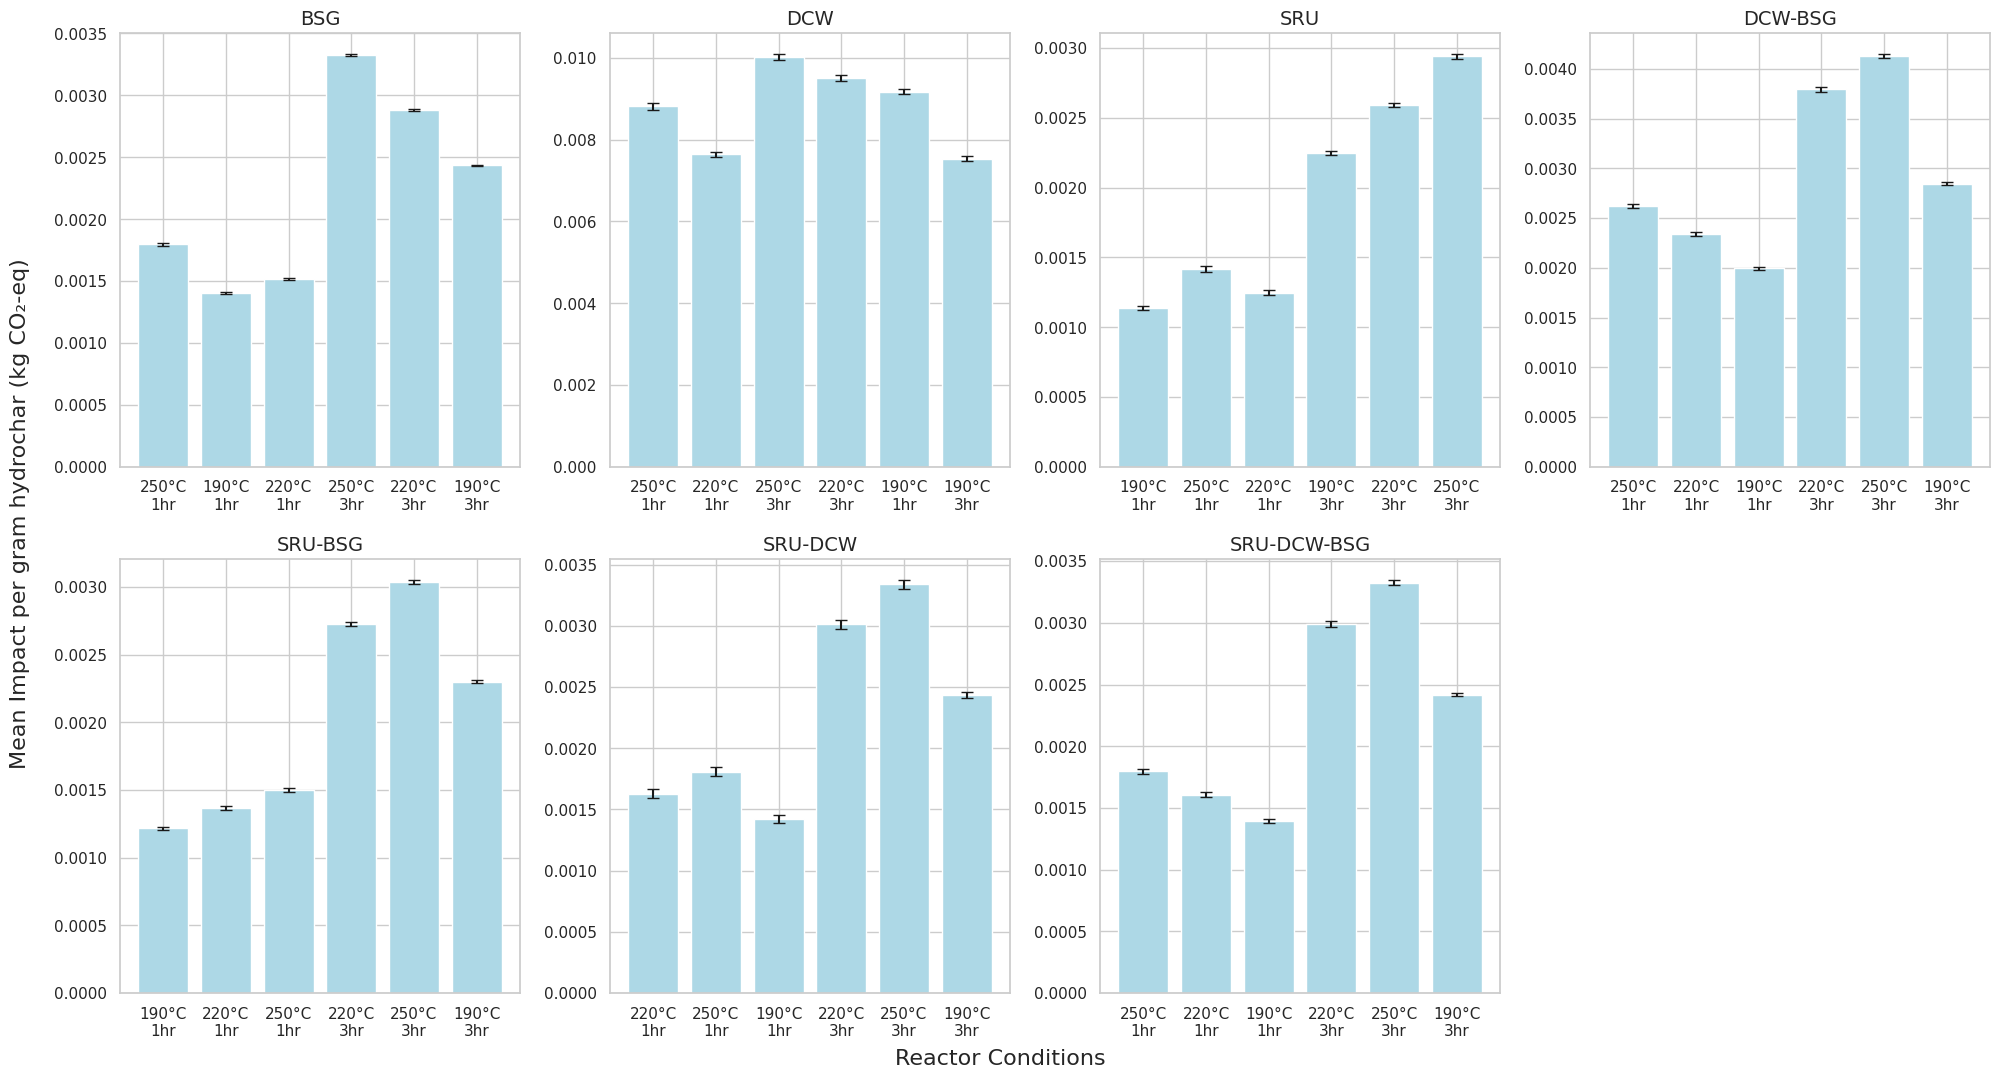

In [110]:
hydrochar_lcia_list = [hc for attr, lcia in baseline_lcia_manager.__dict__.items() for hc in lcia]
plotting_data = create_summary_table(hydrochar_lcia_list, 'gram hydrochar')
plot_facet_grid_stacked_bars(plotting_data, "Mean Impact per gram hydrochar", '(kg CO\u2082-eq)')

### 4.2: Sensitivity Analysis: Hydrochar Yield 
To determine the impact of hydrochar yield on our results, we'll conduct a local sensitivity analysis to determine the impacts of yield on our interpretation across normalization categories. 

In [111]:
# Delete existing SA Activities 
for act in [act for act in eidb if 'hydrochar production' in act['name'] and '_sa_' in act['name']]:
    act.delete()
    
for act in [act for act in eidb if 'hydrochar production' in act['name']]:
    print(act)

'hydrochar production, stdBSG_190C_1hr' (kg, US, None)
'hydrochar production, stdSRU_250C_3hr' (kg, US, None)
'hydrochar production, stdBSG_220C_1hr' (kg, US, None)
'hydrochar production, stdSRU_250C_1hr' (kg, US, None)
'hydrochar production, rawDCW50_rawBSG50_220C_3hr' (kg, US, None)
'hydrochar production, rawSRU33_rawDCW33_rawBSG33_250C_1hr' (kg, US, None)
'hydrochar production, rawDCW_220C_1hr' (kg, US, None)
'hydrochar production, rawSRU33_rawDCW33_rawBSG33_190C_1hr' (kg, US, None)
'hydrochar production, rawDCW50_rawBSG50_190C_1hr' (kg, US, None)
'hydrochar production, rawDCW50_rawBSG50_250C_1hr' (kg, US, None)
'hydrochar production, rawSRU33_rawDCW33_rawBSG33_220C_3hr' (kg, US, None)
'hydrochar production, rawDCW_250C_1hr' (kg, US, None)
'hydrochar production, rawSRU33_rawDCW33_rawBSG33_190C_3hr' (kg, US, None)
'hydrochar production, rawSRU33_rawDCW33_rawBSG33_220C_1hr' (kg, US, None)
'hydrochar production, rawDCW_250C_3hr' (kg, US, None)
'hydrochar production, rawSRU50_rawDCW50_2

In [112]:
# Delete existing SA Activities from LCIA Managers 
hc_hhv_lcia_list = [hc for attr, lcia in hc_hhv_lcia_manager.__dict__.items() for hc in lcia]
for item in hc_hhv_lcia_list: 
    if item.name.find('sa') != -1: 
        hc_hhv_lcia_manager.delete_hydrochar(item.name)

feedstock_lcia_list = [hc for attr, lcia in feedstock_lcia_manager.__dict__.items() for hc in lcia]
for item in feedstock_lcia_list: 
    if item.name.find('sa') != -1: 
        feedstock_lcia_manager.delete_hydrochar(item.name)

hydrochar_lcia_list = [hc for attr, lcia in baseline_lcia_manager.__dict__.items() for hc in lcia]
for item in hydrochar_lcia_list: 
    if item.name.find('sa') != -1: 
        baseline_lcia_manager.delete_hydrochar(item.name)

In [113]:
def create_hydrochar_activity_hc_sa(feedstock: Feedstock, err_estimate: str):
    '''
    Creates a hydrochar activity, given a feedstock
    Parameters:
        feedstock (Feedstock): Feedstock object
        err_estimate (str): Estimate for hydrochar yield. Either ub to reflect upper bound or lb to reflect lower bound.   
    '''
    temp = feedstock.temp
    time = feedstock.time 
    hydrochar_production = eidb.new_activity(
        code=f'HTC_{feedstock.name}_{temp}C_{time}hr',
        name=f"hydrochar production, {feedstock.name}_{temp}C_{time}hr",
        location='US',
        unit="kg"
    )
    parameters = ParameterManager()
    if err_estimate == 'lb':
        yield_HC = get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'HC_yield') * (1-0.025)
    elif err_estimate == 'ub': 
        yield_HC = get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'HC_yield') * (1+0.025)
    else: 
        yield_HC = get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'HC_yield')
    
    gas_yield = get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'gas_yield')
    project_data = [
        {
            'name': 'feedstock_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_feedstock_quantity(yield_HC, feedstock)
        }, 
        {
            'name': 'water_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_water_quantity(yield_HC, feedstock)
        }, 
        {
            'name': 'heat_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_heat_needed(feedstock, temp, time)
        },
        {
            'name': 'electricity_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_electricity_needed(feedstock, time, temp)
        }, 
        {
            'name': 'co2_' + f'HTC_{feedstock.name}_{temp}C_{time}hr',
            'amount': get_co2_emissions(yield_HC, gas_yield, feedstock)
        }, 
        {
            'name': 'wastewater_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_pw(yield_HC, gas_yield, feedstock, hc_placeholder=1)
        },
        {
            'name': 'post_processing_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_post_processing(hc_placeholder=1)
        }
    ]
    
    print(project_data)
    parameters.new_project_parameters(project_data)
    
    # for param in ProjectParameter.select():
    #     print(param, param.amount)
    
    # Feedstock 
    hydrochar_production.new_exchange(input=('biosphere3', 'feedstock'), amount=0, unit="kg", type='custom', formula= 'feedstock')
    hydrochar_production.save()
                        
    # Water 
    water = [act for act in eidb if 'market for water, completely softened' in act['name']  and 'US' in act['location']][0]
    hydrochar_production.new_exchange(input=water.key, amount=0, unit="kilogram", type='technosphere', 
                                        formula= 'water_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
    hydrochar_production.save()
    
    # Electricity
    electricity = [act for act in eidb if 'market group for electricity, low voltage' in act['name']  and 'US' in act['location']][0]
    hydrochar_production.new_exchange(input=electricity.key, amount=0, unit="kilowatt hour", type='technosphere', 
                                        formula='electricity_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
    hydrochar_production.save()
    
    # Heat 
    electricity = [act for act in eidb if 'market group for electricity, low voltage' in act['name']  and 'US' in act['location']][0]
    hydrochar_production.new_exchange(input=electricity.key, amount=0, unit="kilowatt hour", type='technosphere', 
                                        formula='heat_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
    hydrochar_production.save()
    
    # CO2 Emissions
    co2 = [flow for flow in biosphere3 if 'carbon dioxide, non-fossil, resource correction' in flow['name'].lower()][1]
    hydrochar_production.new_exchange(input=co2.key, amount=0, unit="kilogram", type='biosphere', 
                                        formula='-1*co2_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
    hydrochar_production.save()
    
    # Wastewater 
    wastewater = [act for act in eidb if 'treatment of wastewater, average, wastewater treatment' in act['name']  and 'RoW' in act['location']][0]
    hydrochar_production.new_exchange(input=wastewater.key, amount=0, unit="cubic meter", type='technosphere', 
                                        formula='-1*wastewater_' + f'HTC_{feedstock.name}_{temp}C_{time}hr/1000').save()
    hydrochar_production.save()
    
    # Post-Processing
    electricity = [act for act in eidb if 'market group for electricity, low voltage' in act['name']  and 'US' in act['location']][0]
    hydrochar_production.new_exchange(input=electricity.key, amount=0, unit="kilowatt hour", type='technosphere', 
                                        formula='post_processing_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
    hydrochar_production.save()
    
    parameters.add_exchanges_to_group(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", hydrochar_production)
    ActivityParameter.recalculate_exchanges(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr")
    print()        

In [114]:
# Add feedstocks to sensitivity analysis manager 
sa_feedstocks = FeedstockManager()

elementary_feedstocks = create_elementary_feedstocks()
excluded_feedstocks = {"rawSRU", "rawBSG"}

def create_sa_feedstocks(feedstock): 
    lb_feedstock = copy.deepcopy(feedstock)
    lb_feedstock.name = lb_feedstock.name + '_sa_lb'
    
    ub_feedstock = copy.deepcopy(feedstock)
    ub_feedstock.name = ub_feedstock.name + '_sa_ub'
    
    return lb_feedstock, ub_feedstock
    

for attr, feedstocks in elementary_feedstocks.__dict__.items():
    for feedstock in feedstocks:
        if feedstock.name not in excluded_feedstocks:            
            lb_feedstock, ub_feedstock = create_sa_feedstocks(feedstock)
            sa_feedstocks.add_feedstock(lb_feedstock)
            sa_feedstocks.add_feedstock(ub_feedstock)
            # sa_feedstocks.add_feedstock(feedstock)

composite_feedstocks = create_composite_elementary_feedstocks()
for attr, feedstocks in composite_feedstocks.__dict__.items():
    for feedstock in feedstocks:  
        lb_feedstock, ub_feedstock = create_sa_feedstocks(feedstock)
        sa_feedstocks.add_feedstock(lb_feedstock)
        sa_feedstocks.add_feedstock(ub_feedstock)
        # sa_feedstocks.add_feedstock(feedstock)

In [115]:
for attr, feedstocks in sa_feedstocks.__dict__.items():
    for feedstock in feedstocks:
        try:
            if feedstock.name.find('lb') == -1: 
                create_hydrochar_activity_hc_sa(feedstock, 'lb')
            if feedstock.name.find('ub') == -1: 
                create_hydrochar_activity_hc_sa(feedstock, 'ub')
            else:
                raise ValueError(f"A feedstock without sensitivity analysis bound was computed.")
        except: 
            print(f"Hydrochar activity: {feedstock.name}_{feedstock.temp}C_{feedstock.time}hr already exists. Continuing.")
            continue

[{'name': 'feedstock_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 4.297706710299925}, {'name': 'water_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 1.367131224148841}, {'name': 'heat_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 1.7856695612543314}, {'name': 'electricity_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 0.0524790412175677}, {'name': 'co2_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 0.013310856483122992}, {'name': 'wastewater_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 4.651527077965643}, {'name': 'post_processing_HTC_stdSRU_sa_lb_190C_1hr', 'amount': 0.403}]

[{'name': 'feedstock_HTC_stdSRU_sa_ub_190C_1hr', 'amount': 4.518101926212741}, {'name': 'water_HTC_stdSRU_sa_ub_190C_1hr', 'amount': 1.437240517694935}, {'name': 'heat_HTC_stdSRU_sa_ub_190C_1hr', 'amount': 1.8196683887567022}, {'name': 'electricity_HTC_stdSRU_sa_ub_190C_1hr', 'amount': 0.05330393475893037}, {'name': 'co2_HTC_stdSRU_sa_ub_190C_1hr', 'amount': 0.013993464507898528}, {'name': 'wastewater_HTC_stdSRU_sa_ub_190C_1hr', 'amount': 4.941348979399777}, {'

In [116]:
# Ensuring all HC activities are in database, should result in 126
print(len([act for act in eidb if 'hydrochar production' in act['name']]))

126


In [117]:
# Computing LCIA Results for Climate Change across normalization categories 
process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']
scaling_factor = 0.001

for attr, feedstocks in sa_feedstocks.__dict__.items():
    
        for feedstock in feedstocks:
            if str(feedstock.name).find('sa') != -1:
                for act in [act for act in eidb if f"hydrochar production, {feedstock.name}_{feedstock.temp}C_{feedstock.time}hr" in act['name']]:
                    activity_lcia = HydrocharLCIA(act['name']) 
                    feedstock_lcia = HydrocharLCIA(act['name']) 
                    hc_hhv_lcia = HydrocharLCIA(act['name']) 
                    
                    feedstock_normalization_factor = 1 / feedstock.quantity
                    hc_hhv = get_parameter(activity['name'], 'HHV_HC')
                    hc_hhv_normalization_factor = hc_hhv / 1000
                            
                    method = [m for m in bw.methods if 'TRACI' in str(m) and 'global warming' in str(m)][0]
                    impact_category = get_impact_category(method)
                    method_key = method
                    unit = bw.methods.get(method_key).get('unit')
                    
                    for i in range(len(process_categories)):
                        process_catgeory = process_categories[i]
                        exc = [exc for exc in act.exchanges()][i]
                            
                        functional_amount = exc['amount'] * scaling_factor
                        functional_unit = { exc.input: functional_amount}
                        temp_lca = bw.LCA(functional_unit, method_key)
                        
                        if 'Carbon dioxide' in str(exc.input) and 'climate change' in str(method_key):
                            score = -1*functional_amount
                            activity_lcia.set_impact_score(impact_category, process_catgeory, score, unit)
                            
                        # Will not ever execute as climate change is the only 
                        elif 'Carbon dioxide' in str(exc.input):
                            score = 0 
                            activity_lcia.set_impact_score(impact_category, process_catgeory, score, unit)
                        
                        else:
                            temp_lca.lci()
                            temp_lca.lcia()
                            score = temp_lca.score
                            
                            activity_lcia.set_impact_score(impact_category, process_catgeory, score, unit)  
                            # feedstock_lcia.set_impact_score(impact_category, process_catgeory, score * feedstock_normalization_factor * 1000, unit)
                            feedstock_lcia.set_impact_score(impact_category, process_catgeory, score * feedstock_normalization_factor, unit)
                            hc_hhv_lcia.set_impact_score(impact_category, process_catgeory, score / hc_hhv_normalization_factor, unit)
                        
                    
                baseline_lcia_manager.add_hydrochar(activity_lcia)
                feedstock_lcia_manager.add_hydrochar(feedstock_lcia)
                hc_hhv_lcia_manager.add_hydrochar(hc_hhv_lcia)
                
                print(activity_lcia.name , "successfully calculated & added to LCIA Managers.")    

hydrochar production, stdSRU_sa_lb_190C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_ub_190C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_lb_190C_3hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_ub_190C_3hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_lb_220C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_ub_220C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_lb_220C_3hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_ub_220C_3hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_lb_250C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_ub_250C_1hr successfully calculated & added to LCIA Managers.
hydrochar production, stdSRU_sa_lb_250C_3hr successfully cal

#### 4.2.1: Energy Basis: HC Yield 

In [118]:
hc_hhv_lcia_list = [hc for attr, lcia in hc_hhv_lcia_manager.__dict__.items() for hc in lcia]
create_summary_table(hc_hhv_lcia_list, 'gram hydrochar / HHV')

Feedstock & Reactor Conditions  Mean Impact per gram hydrochar / HHV  \
0                 SRU, 250°C, 3hr                              0.093637   
7                 SRU, 250°C, 1hr                              0.044769   
13                SRU, 220°C, 3hr                              0.082982   
9                 SRU, 190°C, 1hr                              0.036500   
12                SRU, 190°C, 3hr                              0.072748   
15                SRU, 220°C, 1hr                              0.039913   
6                 BSG, 190°C, 1hr                              0.049102   
17                BSG, 190°C, 3hr                              0.084402   
16                BSG, 220°C, 1hr                              0.050942   
8                 DCW, 190°C, 3hr                              0.256395   
5                 DCW, 190°C, 1hr                              0.312075   
3                 BSG, 250°C, 3hr                              0.108473   
14                DCW, 220°C, 1hr                              0.255595   
1                 DCW, 220°C, 3hr                              0.318593   
10                DCW, 250°C, 1hr                              0.289417   
11                DCW, 250°C, 3hr                              0.329641   
2                 BSG, 220°C, 3hr                              0.097039   
4                 BSG, 250°C, 1hr                              0.058717   
30            DCW-BSG, 190°C, 1hr                              0.065569   
32            DCW-BSG, 220°C, 1hr                              0.073724   
34            DCW-BSG, 250°C, 1hr                              0.081534   
18            SRU-DCW, 190°C, 1hr                              0.047392   
20            SRU-DCW, 220°C, 1hr                              0.052945   
36        SRU-DCW-BSG, 190°C, 1hr                              0.046567   
38        SRU-DCW-BSG, 220°C, 1hr                              0.052397   
22            SRU-DCW, 250°C, 1hr                              0.058309   
40        SRU-DCW-BSG, 250°C, 1hr                              0.058067   
33            DCW-BSG, 220°C, 3hr                              0.122097   
24            SRU-BSG, 190°C, 1hr                              0.041030   
35            DCW-BSG, 250°C, 3hr                              0.132635   
26            SRU-BSG, 220°C, 1hr                              0.045462   
28            SRU-BSG, 250°C, 1hr                              0.049786   
31            DCW-BSG, 190°C, 3hr                              0.093990   
21            SRU-DCW, 220°C, 3hr                              0.099748   
39        SRU-DCW-BSG, 220°C, 3hr                              0.099176   
23            SRU-DCW, 250°C, 3hr                              0.110750   
41        SRU-DCW-BSG, 250°C, 3hr                              0.110394   
19            SRU-DCW, 190°C, 3hr                              0.081816   
37        SRU-DCW-BSG, 190°C, 3hr                              0.081322   
27            SRU-BSG, 220°C, 3hr                              0.091624   
25            SRU-BSG, 190°C, 3hr                              0.077929   
29            SRU-BSG, 250°C, 3hr                              0.102388   

    Standard Deviation  Coefficient of Variation (%)  
0             0.008764                      9.359923  
7             0.003798                      8.483729  
13            0.006812                      8.208818  
9             0.002821                      7.727684  
12            0.005254                      7.222022  
15            0.002858                      7.159505  
6             0.003053                      6.217608  
17            0.003566                      4.225526  
16            0.001720                      3.376170  
8             0.008045                      3.137812  
5             0.008033                      2.574028  
3             0.002777                      2.560265  
14            0.006156                      2.408406  
1      

In [119]:
# Exporting results to Excel file
path = 'results/Uncertainty_Analysis.xlsx'
with pd.ExcelWriter(path, engine='xlsxwriter') as writer:
    df = create_summary_table(hc_hhv_lcia_list, 'gram hydrochar / HHV')
    df.to_excel(writer, sheet_name='HC Yield - HC_HHV', index=False)

/tmp/ipykernel_3806368/2271054288.py:24: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = data.pivot_table(


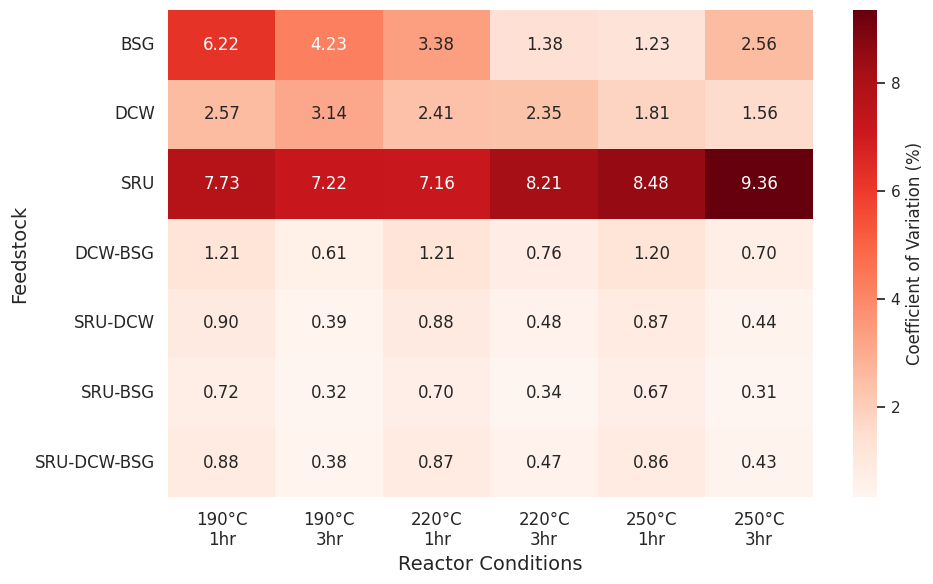

In [120]:
hc_hhv_lcia_list = [hc for attr, lcia in hc_hhv_lcia_manager.__dict__.items() for hc in lcia]
plotting_data = create_summary_table(hc_hhv_lcia_list, 'gram hydrochar / HHV')
plot_variability_heatmap(plotting_data, "Coefficient of Variation (%)")

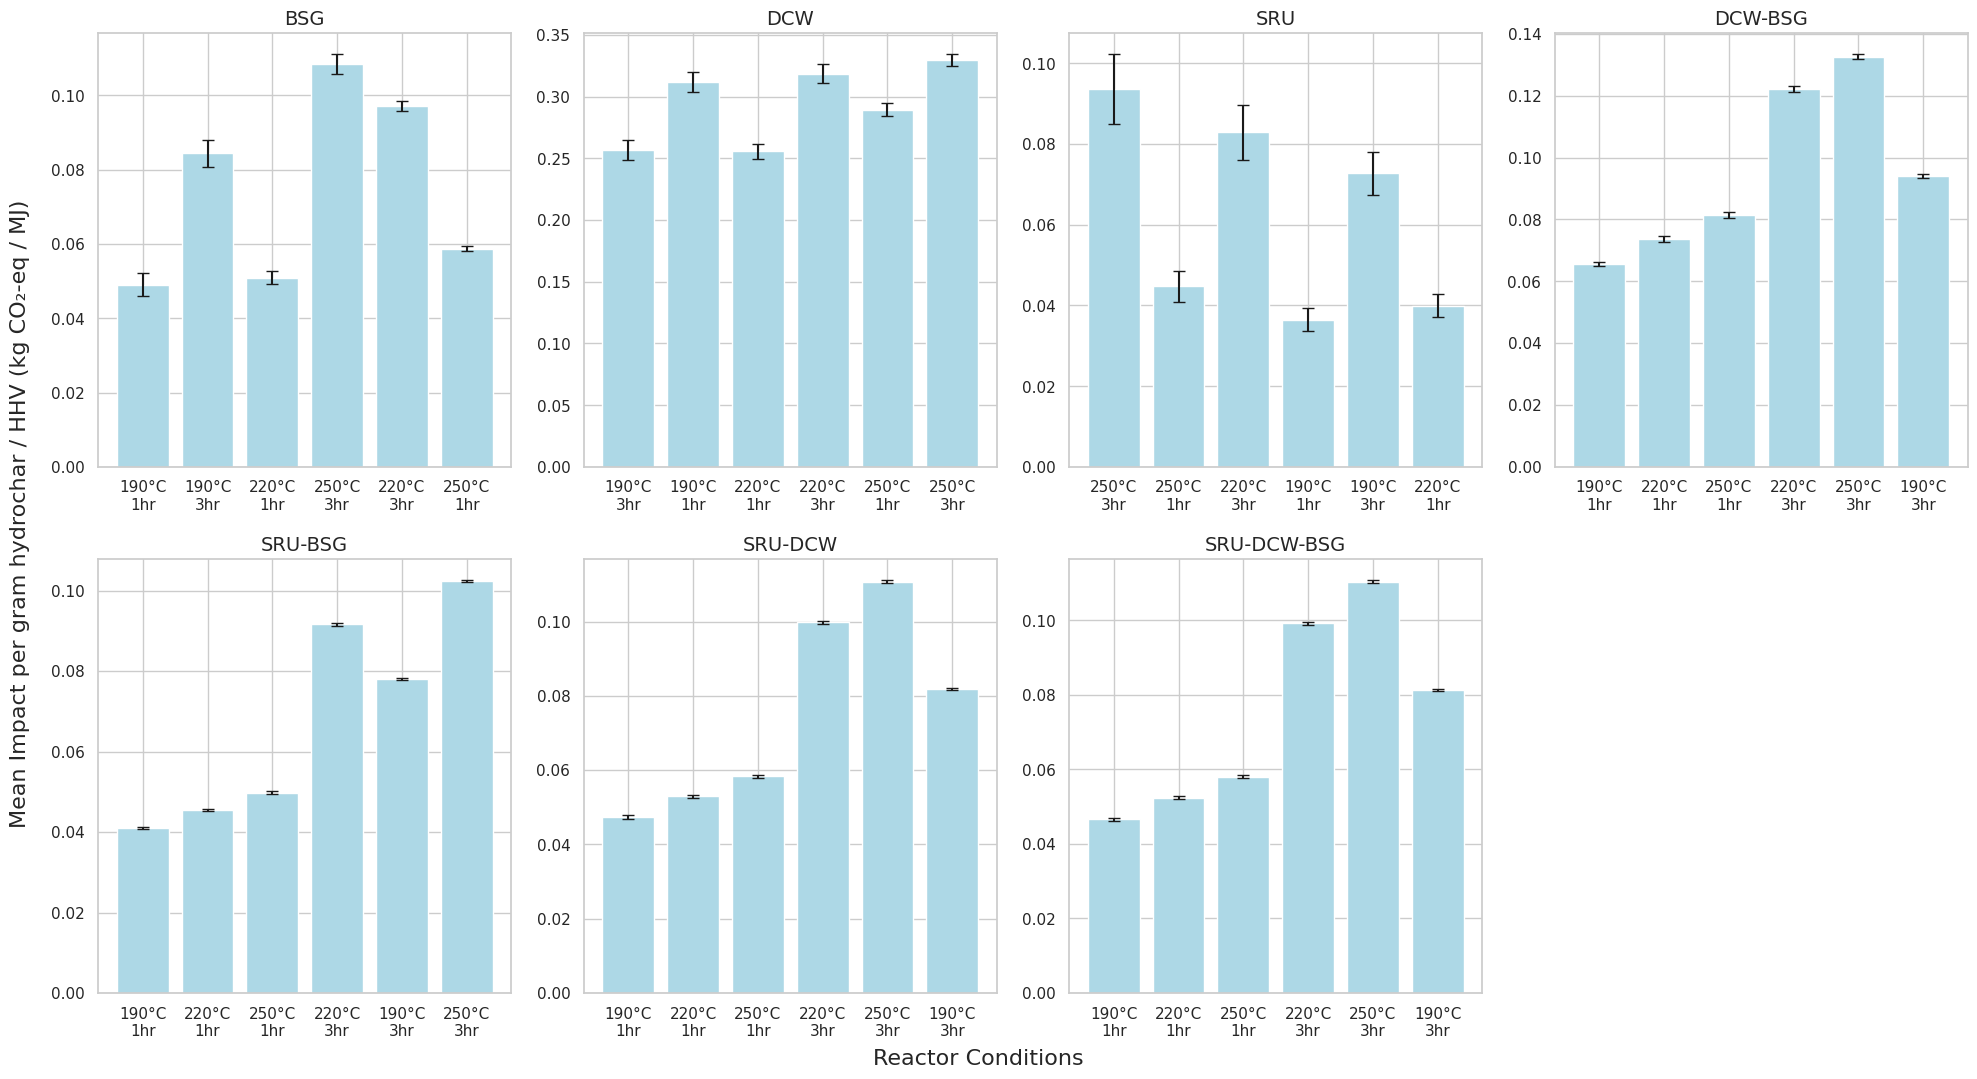

In [121]:
hc_hhv_lcia_list = [hc for attr, lcia in hc_hhv_lcia_manager.__dict__.items() for hc in lcia]
plotting_data = create_summary_table(hc_hhv_lcia_list, 'gram hydrochar / HHV')
plot_facet_grid_stacked_bars(plotting_data, "Mean Impact per gram hydrochar / HHV", '(kg CO\u2082-eq / MJ)')

#### 4.2.2: Feedstock Basis: HC Yield 

In [122]:
feedstock_lcia_list = [hc for attr, lcia in feedstock_lcia_manager.__dict__.items() for hc in lcia]
create_summary_table(feedstock_lcia_list, 'gram feedstock')

Feedstock & Reactor Conditions  Mean Impact per gram feedstock  \
4                 BSG, 250°C, 1hr                        0.000259   
16                BSG, 220°C, 1hr                        0.000240   
3                 BSG, 250°C, 3hr                        0.000512   
2                 BSG, 220°C, 3hr                        0.000459   
17                BSG, 190°C, 3hr                        0.000411   
13                SRU, 220°C, 3hr                        0.000713   
0                 SRU, 250°C, 3hr                        0.000825   
7                 SRU, 250°C, 1hr                        0.000369   
12                SRU, 190°C, 3hr                        0.000573   
15                SRU, 220°C, 1hr                        0.000330   
29            SRU-BSG, 250°C, 3hr                        0.000704   
25            SRU-BSG, 190°C, 3hr                        0.000510   
27            SRU-BSG, 220°C, 3hr                        0.000555   
6                 BSG, 190°C, 1hr                        0.000185   
37        SRU-DCW-BSG, 190°C, 3hr                        0.000431   
19            SRU-DCW, 190°C, 3hr                        0.000426   
41        SRU-DCW-BSG, 250°C, 3hr                        0.000517   
23            SRU-DCW, 250°C, 3hr                        0.000518   
39        SRU-DCW-BSG, 220°C, 3hr                        0.000416   
21            SRU-DCW, 220°C, 3hr                        0.000413   
10                DCW, 250°C, 1hr                        0.000153   
9                 SRU, 190°C, 1hr                        0.000256   
11                DCW, 250°C, 3hr                        0.000184   
31            DCW-BSG, 190°C, 3hr                        0.000305   
28            SRU-BSG, 250°C, 1hr                        0.000328   
26            SRU-BSG, 220°C, 1hr                        0.000274   
35            DCW-BSG, 250°C, 3hr                        0.000356   
1                 DCW, 220°C, 3hr                        0.000156   
24            SRU-BSG, 190°C, 1hr                        0.000223   
33            DCW-BSG, 220°C, 3hr                        0.000285   
14                DCW, 220°C, 1hr                        0.000134   
40        SRU-DCW-BSG, 250°C, 1hr                        0.000260   
22            SRU-DCW, 250°C, 1hr                        0.000261   
38        SRU-DCW-BSG, 220°C, 1hr                        0.000223   
36        SRU-DCW-BSG, 190°C, 1hr                        0.000188   
20            SRU-DCW, 220°C, 1hr                        0.000223   
18            SRU-DCW, 190°C, 1hr                        0.000186   
8                 DCW, 190°C, 3hr                        0.000135   
34            DCW-BSG, 250°C, 1hr                        0.000208   
32            DCW-BSG, 220°C, 1hr                        0.000179   
30            DCW-BSG, 190°C, 1hr                        0.000152   
5                 DCW, 190°C, 1hr                        0.000109   

    Standard Deviation  Coefficient of Variation (%)  
4         7.345260e-06                      2.834609  
16        5.914613e-06                      2.463230  
3         1.146706e-05                      2.239285  
2         9.544611e-06                      2.078733  
17        7.733678e-06                      1.882978  
13        1.332496e-05                      1.869138  
0         1.518115e-05                      1.839280  
7         6.774254e-06                      1.833448  
12        1.030722e-05                      1.799641  
15        5.770123e-06                      1.747606  
29        1.216342e-05                      1.728836  
25        8.798564e-06                      1.724751  
27        9.426816e-06                      1.698128  
6         3.120838e-06                      1.688840  
37        7.137262e-06                      1.657554  
19        7.025337e-06                      1.649349  
41        8.308137e-06                      1.606984  
23        8.297859e-06                      1

In [123]:
# Exporting results to Excel file
path = 'results/Uncertainty_Analysis.xlsx'
with pd.ExcelWriter(path, engine='xlsxwriter') as writer:
    df = create_summary_table(feedstock_lcia_list, 'gram feedstock')
    df.to_excel(writer, sheet_name='HC Yield - Feedstock', index=False)

/tmp/ipykernel_3806368/2271054288.py:24: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = data.pivot_table(


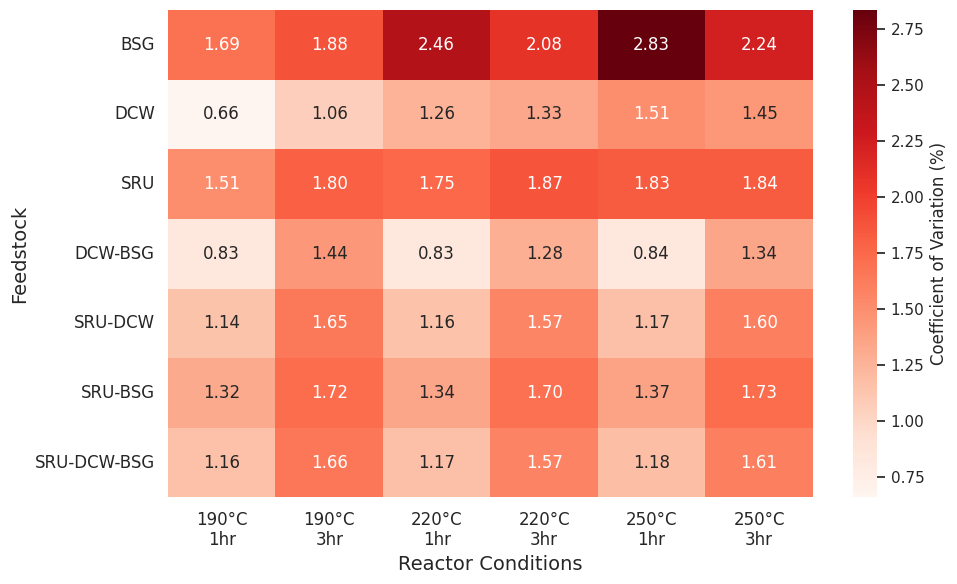

In [124]:
feedstock_lcia_list = [hc for attr, lcia in feedstock_lcia_manager.__dict__.items() for hc in lcia]
plotting_data = create_summary_table(feedstock_lcia_list, 'gram feedstock')
plot_variability_heatmap(plotting_data, "Coefficient of Variation (%)")

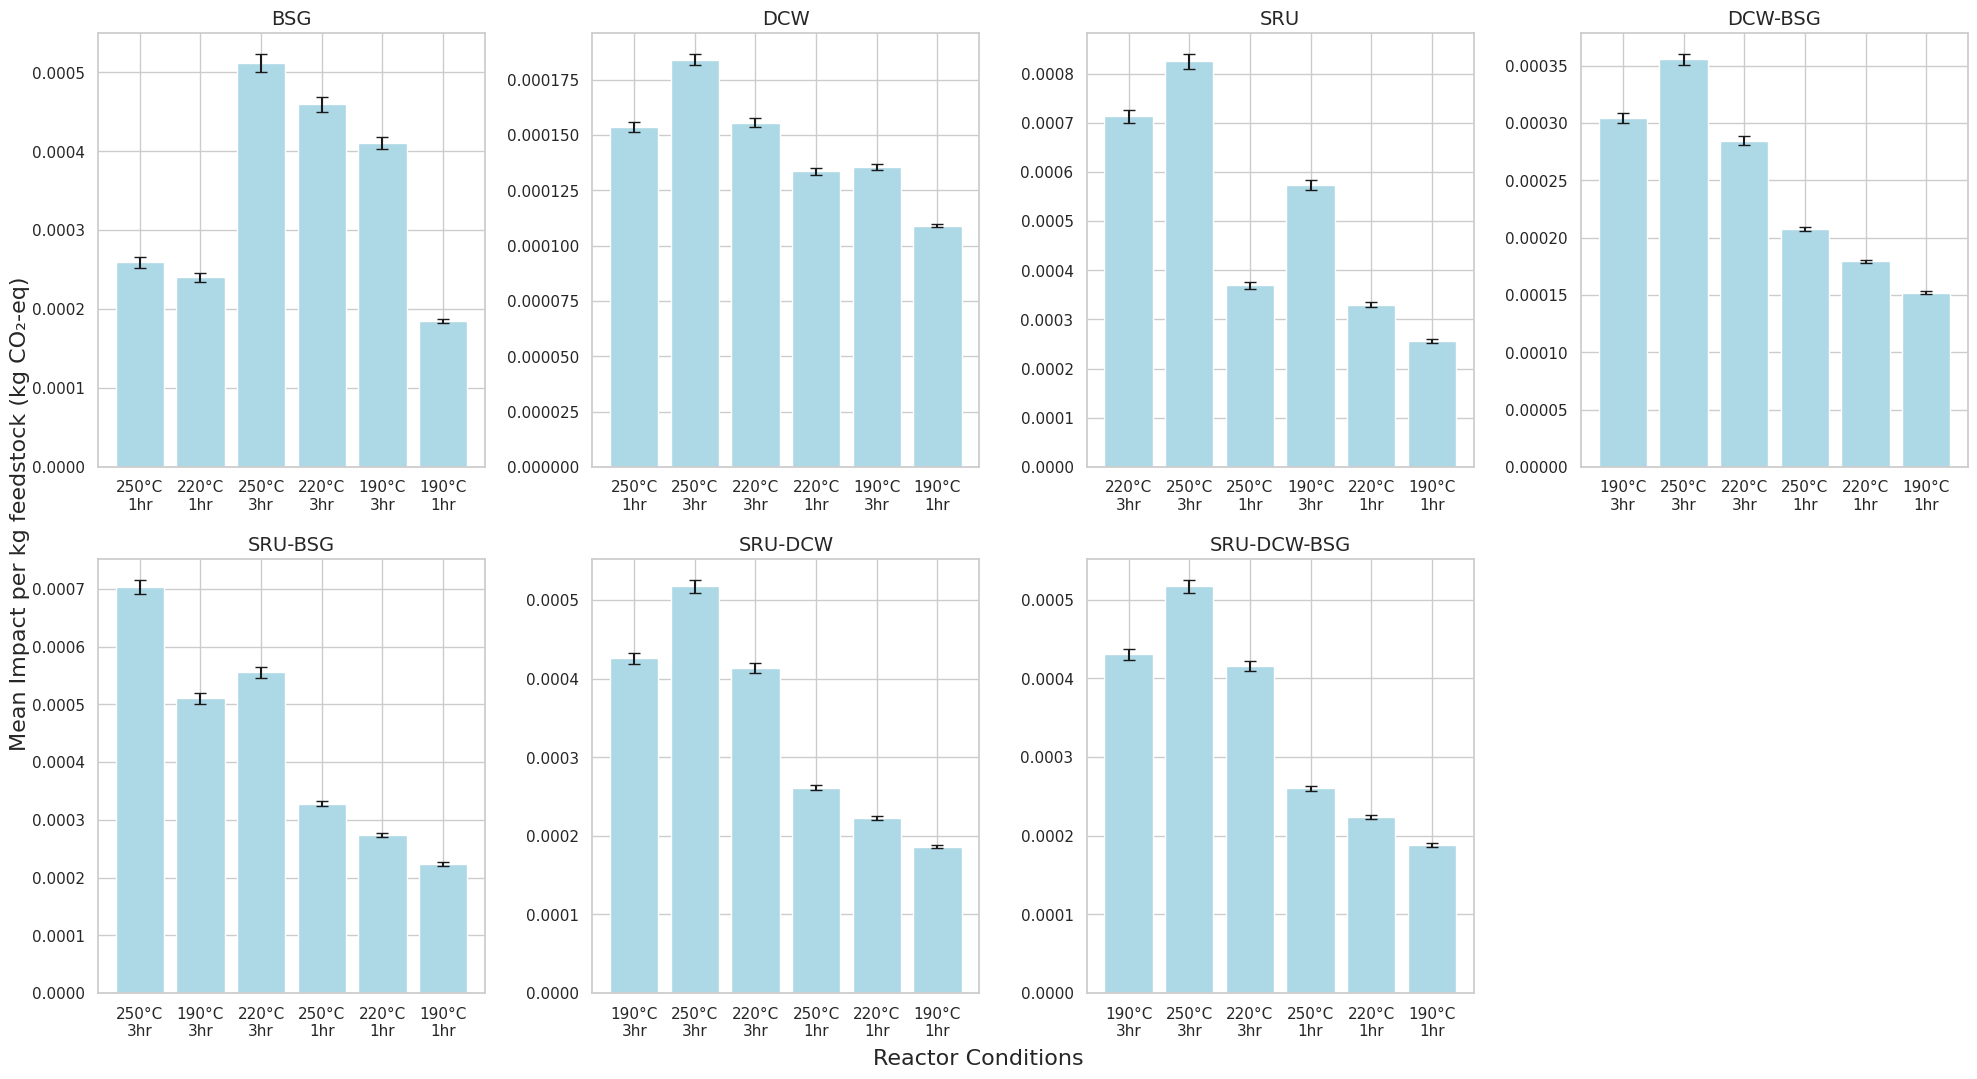

In [125]:
feedstock_lcia_list = [hc for attr, lcia in feedstock_lcia_manager.__dict__.items() for hc in lcia]
plotting_data = create_summary_table(feedstock_lcia_list, 'kg feedstock')
plot_facet_grid_stacked_bars(plotting_data, "Mean Impact per kg feedstock", '(kg CO\u2082-eq)')

#### 4.2.3: Hydrochar Basis: HC Yield 

In [126]:
hydrochar_lcia_list = [hc for attr, lcia in baseline_lcia_manager.__dict__.items() for hc in lcia]
create_summary_table(feedstock_lcia_list, 'gram hydrochar')

Feedstock & Reactor Conditions  Mean Impact per gram hydrochar  \
4                 BSG, 250°C, 1hr                        0.000259   
16                BSG, 220°C, 1hr                        0.000240   
3                 BSG, 250°C, 3hr                        0.000512   
2                 BSG, 220°C, 3hr                        0.000459   
17                BSG, 190°C, 3hr                        0.000411   
13                SRU, 220°C, 3hr                        0.000713   
0                 SRU, 250°C, 3hr                        0.000825   
7                 SRU, 250°C, 1hr                        0.000369   
12                SRU, 190°C, 3hr                        0.000573   
15                SRU, 220°C, 1hr                        0.000330   
29            SRU-BSG, 250°C, 3hr                        0.000704   
25            SRU-BSG, 190°C, 3hr                        0.000510   
27            SRU-BSG, 220°C, 3hr                        0.000555   
6                 BSG, 190°C, 1hr                        0.000185   
37        SRU-DCW-BSG, 190°C, 3hr                        0.000431   
19            SRU-DCW, 190°C, 3hr                        0.000426   
41        SRU-DCW-BSG, 250°C, 3hr                        0.000517   
23            SRU-DCW, 250°C, 3hr                        0.000518   
39        SRU-DCW-BSG, 220°C, 3hr                        0.000416   
21            SRU-DCW, 220°C, 3hr                        0.000413   
10                DCW, 250°C, 1hr                        0.000153   
9                 SRU, 190°C, 1hr                        0.000256   
11                DCW, 250°C, 3hr                        0.000184   
31            DCW-BSG, 190°C, 3hr                        0.000305   
28            SRU-BSG, 250°C, 1hr                        0.000328   
26            SRU-BSG, 220°C, 1hr                        0.000274   
35            DCW-BSG, 250°C, 3hr                        0.000356   
1                 DCW, 220°C, 3hr                        0.000156   
24            SRU-BSG, 190°C, 1hr                        0.000223   
33            DCW-BSG, 220°C, 3hr                        0.000285   
14                DCW, 220°C, 1hr                        0.000134   
40        SRU-DCW-BSG, 250°C, 1hr                        0.000260   
22            SRU-DCW, 250°C, 1hr                        0.000261   
38        SRU-DCW-BSG, 220°C, 1hr                        0.000223   
36        SRU-DCW-BSG, 190°C, 1hr                        0.000188   
20            SRU-DCW, 220°C, 1hr                        0.000223   
18            SRU-DCW, 190°C, 1hr                        0.000186   
8                 DCW, 190°C, 3hr                        0.000135   
34            DCW-BSG, 250°C, 1hr                        0.000208   
32            DCW-BSG, 220°C, 1hr                        0.000179   
30            DCW-BSG, 190°C, 1hr                        0.000152   
5                 DCW, 190°C, 1hr                        0.000109   

    Standard Deviation  Coefficient of Variation (%)  
4         7.345260e-06                      2.834609  
16        5.914613e-06                      2.463230  
3         1.146706e-05                      2.239285  
2         9.544611e-06                      2.078733  
17        7.733678e-06                      1.882978  
13        1.332496e-05                      1.869138  
0         1.518115e-05                      1.839280  
7         6.774254e-06                      1.833448  
12        1.030722e-05                      1.799641  
15        5.770123e-06                      1.747606  
29        1.216342e-05                      1.728836  
25        8.798564e-06                      1.724751  
27        9.426816e-06                      1.698128  
6         3.120838e-06                      1.688840  
37        7.137262e-06                      1.657554  
19        7.025337e-06                      1.649349  
41        8.308137e-06                      1.606984  
23        8.297859e-06                      1

In [127]:
# Exporting results to Excel file
path = 'results/Uncertainty_Analysis.xlsx'
with pd.ExcelWriter(path, engine='xlsxwriter') as writer:
    df = create_summary_table(hydrochar_lcia_list , 'gram hydrochar')
    df.to_excel(writer, sheet_name='HC Yield - HC', index=False)

/tmp/ipykernel_3806368/2271054288.py:24: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = data.pivot_table(


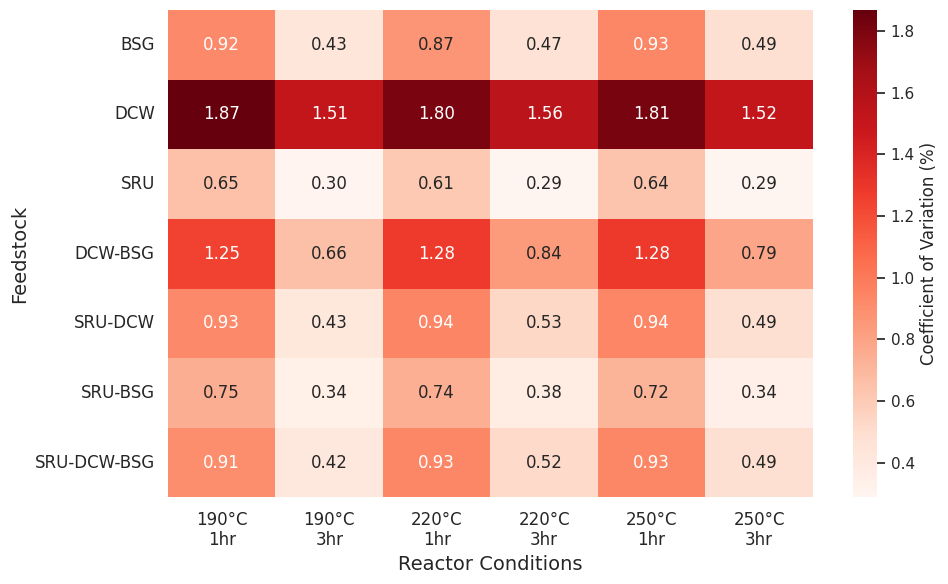

In [128]:
hydrochar_lcia_list = [hc for attr, lcia in baseline_lcia_manager.__dict__.items() for hc in lcia]
plotting_data = create_summary_table(hydrochar_lcia_list , 'gram hydrochar')
plot_variability_heatmap(plotting_data, "Coefficient of Variation (%)")

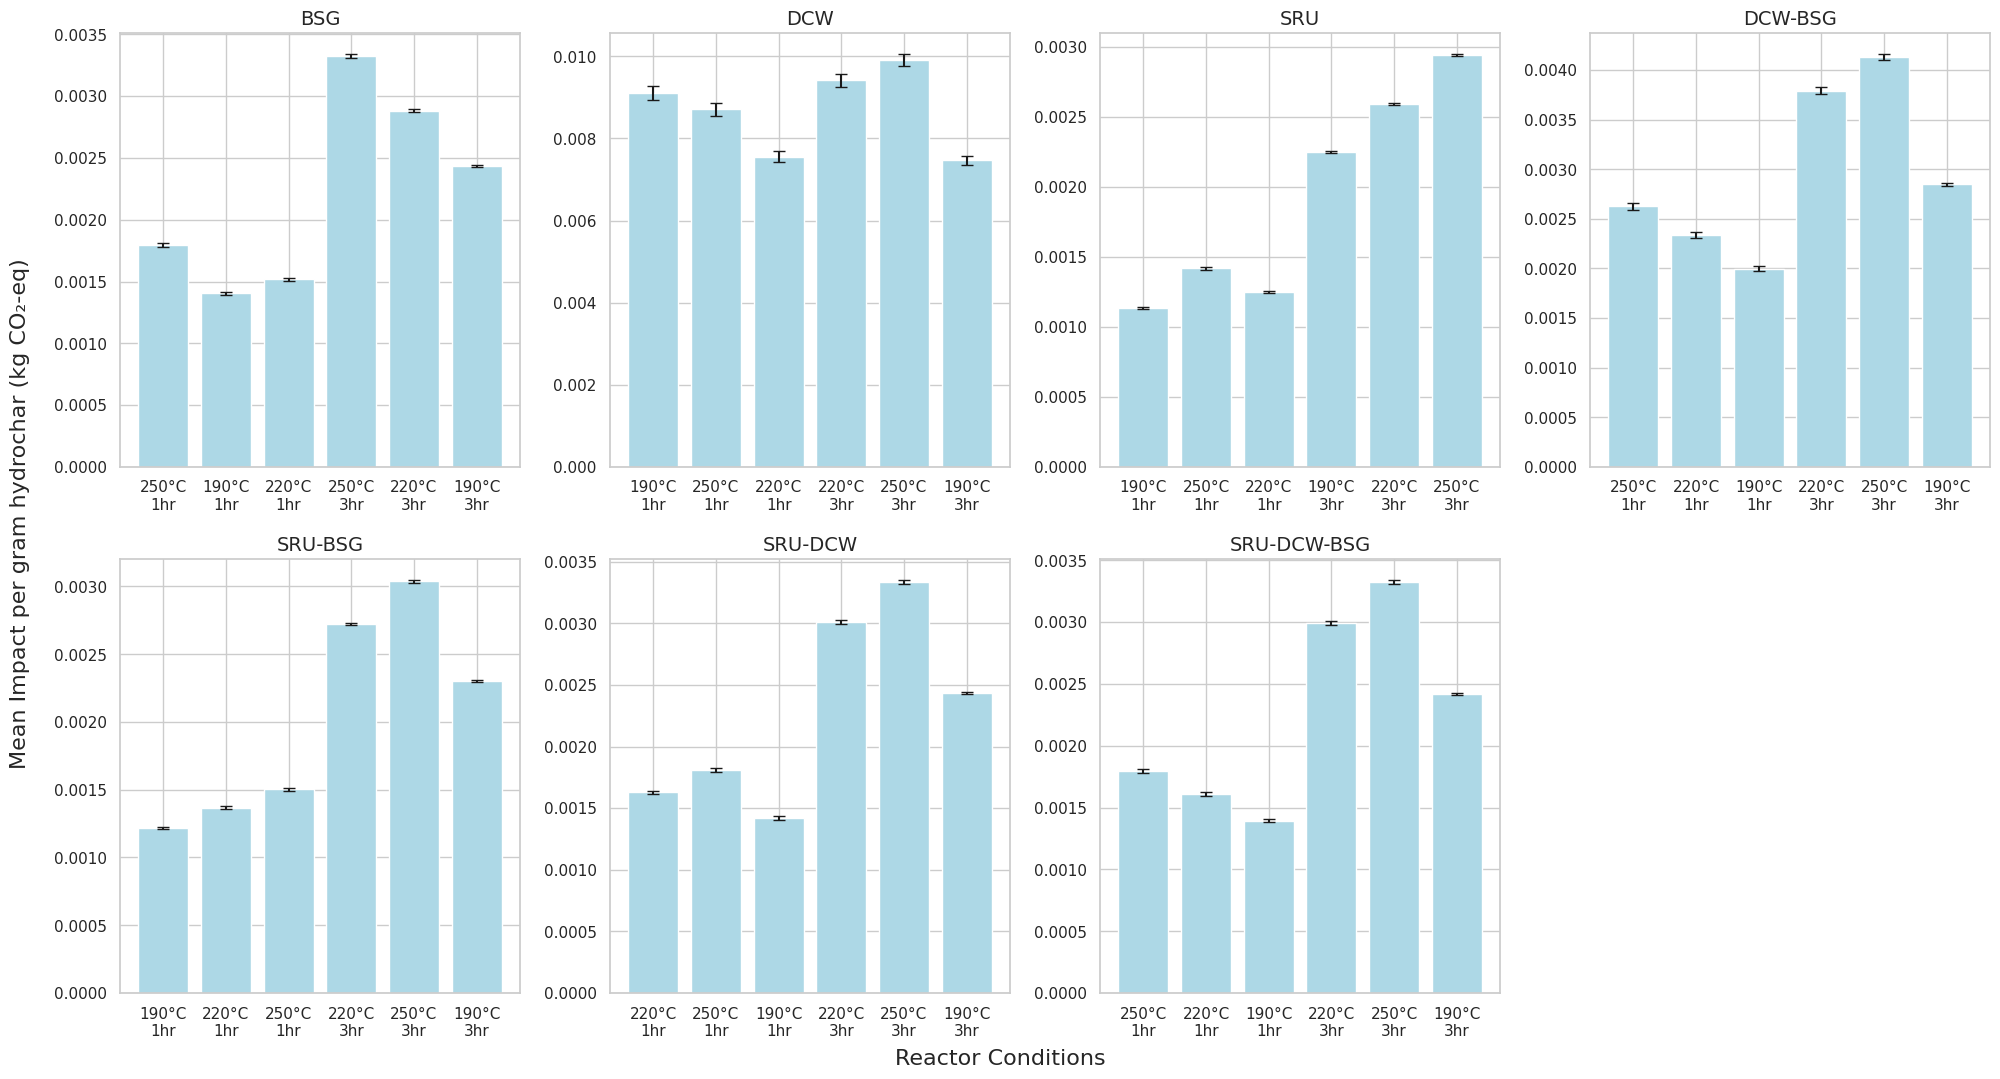

In [129]:
hydrochar_lcia_list = [hc for attr, lcia in baseline_lcia_manager.__dict__.items() for hc in lcia]
plotting_data = create_summary_table(hydrochar_lcia_list, 'gram hydrochar')
plot_facet_grid_stacked_bars(plotting_data, "Mean Impact per gram hydrochar", '(kg CO\u2082-eq)')

In [131]:
raise RuntimeError("Execution stopped intentionally: Ensure supplementary information is referenced before running all cells.")

RuntimeError: Execution stopped intentionally: Ensure supplementary information is referenced before running all cells.

## 5: Supplementary Information
The following sections contains of additional scripts that may be helpful for further analysis or for visualization purposes, but were outside of the scope of the paper. 

### 5.1: 3D Pareto Fronts 
Visualizing all normalization techniques through three-dimensional plots. 

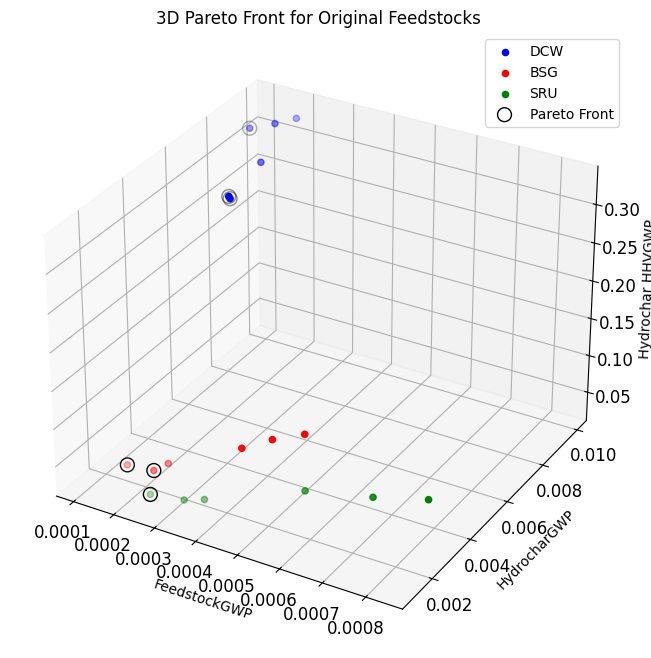

In [ ]:
# Gathering Data 
dcw_data = get_gwp_data('rawDCW', ['Feedstock', 'Hydrochar', 'Hydrochar HHV'])
bsg_data = get_gwp_data('stdBSG', ['Feedstock', 'Hydrochar', 'Hydrochar HHV'])
sru_data = get_gwp_data('stdSRU', ['Feedstock', 'Hydrochar', 'Hydrochar HHV'])
data = pd.concat([dcw_data, bsg_data, sru_data], ignore_index=True, sort=False)

# Compute Pareto front
pareto_front = get_pareto_front(data)

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot all data points
ax.scatter(dcw_data.iloc[:, 1], dcw_data.iloc[:, 2], dcw_data.iloc[:, 3], color='blue', label='DCW')
ax.scatter(bsg_data.iloc[:, 1], bsg_data.iloc[:, 2], bsg_data.iloc[:, 3], color='red', label='BSG')
ax.scatter(sru_data.iloc[:, 1], sru_data.iloc[:, 2], sru_data.iloc[:, 3], color='green', label='SRU')

# Plot Pareto front
ax.scatter(pareto_front[:, 0], pareto_front[:, 1], pareto_front[:, 2], color='none', label='Pareto Front', s=100, edgecolor='k')

# Labels and title
ax.set_xlabel(data.columns[1] + ' GWP')
ax.set_ylabel(data.columns[2] + ' GWP')
ax.set_zlabel(data.columns[3] + ' GWP')
ax.set_title(f'3D Pareto Front for Original Feedstocks')

# Add legend
ax.legend()

plt.show()

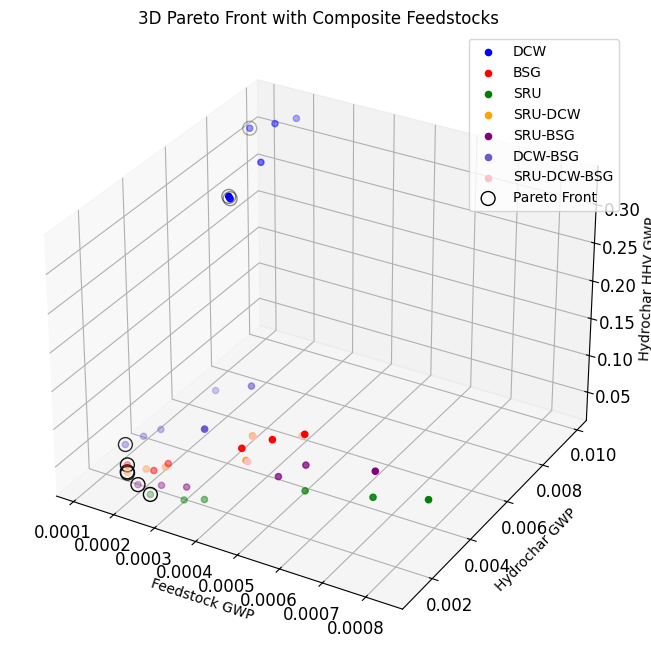

In [ ]:
# Gathering Data 
dcw_data = get_gwp_data('rawDCW_', ['Feedstock', 'Hydrochar', 'Hydrochar HHV'])
bsg_data = get_gwp_data('stdBSG_', ['Feedstock', 'Hydrochar', 'Hydrochar HHV'])
sru_data = get_gwp_data('stdSRU_', ['Feedstock', 'Hydrochar', 'Hydrochar HHV'])
rawSRU50_rawDCW50 = get_gwp_data('rawSRU50_rawDCW50', ['Feedstock', 'Hydrochar', 'Hydrochar HHV'])
rawSRU50_rawBSG50 = get_gwp_data('rawSRU50_rawBSG50', ['Feedstock', 'Hydrochar', 'Hydrochar HHV'])
rawDCW50_rawBSG50 = get_gwp_data('rawDCW50_rawBSG50', ['Feedstock', 'Hydrochar', 'Hydrochar HHV'])
rawSRU33_rawDCW33_rawBSG33 = get_gwp_data('rawSRU33_rawDCW33_rawBSG33', ['Feedstock', 'Hydrochar', 'Hydrochar HHV'])

data = pd.concat([dcw_data, bsg_data, sru_data, rawSRU50_rawDCW50, rawSRU50_rawBSG50, rawDCW50_rawBSG50, rawSRU33_rawDCW33_rawBSG33], 
                 ignore_index=True, sort=False)
data = data.drop_duplicates()

# Compute Pareto front
pareto_front = get_pareto_front(data)

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot all data points
ax.scatter(dcw_data.iloc[:, 1], dcw_data.iloc[:, 2], dcw_data.iloc[:, 3], color='blue', label='DCW')
ax.scatter(bsg_data.iloc[:, 1], bsg_data.iloc[:, 2], bsg_data.iloc[:, 3], color='red', label='BSG')
ax.scatter(sru_data.iloc[:, 1], sru_data.iloc[:, 2], sru_data.iloc[:, 3], color='green', label='SRU')
ax.scatter(rawSRU50_rawDCW50.iloc[:, 1], rawSRU50_rawDCW50.iloc[:, 2], rawSRU50_rawDCW50.iloc[:, 3], color='orange', label='SRU-DCW')
ax.scatter(rawSRU50_rawBSG50.iloc[:, 1], rawSRU50_rawBSG50.iloc[:, 2], rawSRU50_rawBSG50.iloc[:, 3], color='purple', label='SRU-BSG')
ax.scatter(rawDCW50_rawBSG50.iloc[:, 1], rawDCW50_rawBSG50.iloc[:, 2], rawDCW50_rawBSG50.iloc[:, 3], color='slateblue', label='DCW-BSG')
ax.scatter(rawSRU33_rawDCW33_rawBSG33.iloc[:, 1], rawSRU33_rawDCW33_rawBSG33.iloc[:, 2], 
           rawSRU33_rawDCW33_rawBSG33.iloc[:, 3], color='pink', label='SRU-DCW-BSG')

# Plot Pareto front
ax.scatter(pareto_front[:, 0], pareto_front[:, 1], pareto_front[:, 2], color='none', label='Pareto Front', s=100, edgecolor='k')

# Labels and title
ax.set_xlabel(data.columns[1] + ' GWP')
ax.set_ylabel(data.columns[2] + ' GWP')
ax.set_zlabel(data.columns[3] + ' GWP')
ax.set_title(f'3D Pareto Front with Composite Feedstocks')

# Add legend
ax.legend()

plt.show()

### 5.2: Sensitivity Analysis: Bar Graphs
Plotting uncertainty analysis results in one graph for each sensitivity variable (HC yield, moisture content) and normalization method (feedstock, hydrochar produced, hydrochar per higher heating value)

In [ ]:
def plot_summary(lcia_list, normalization_factor, sa_variable): 

    # Grouping global warming potentials by truncated names
    grouped_data = defaultdict(list)

    for item in lcia_list:
        truncated_name = truncate_name(item.name)
        grouped_data[truncated_name].append(item.get_total_impact_score('climate_change'))

    # Calculate mean and standard deviation for each group
    means = {}
    std_devs = {}

    for name, gwps in grouped_data.items():
        means[name] = np.mean(gwps)
        std_devs[name] = np.std(gwps)

    sorted_means = dict(sorted(means.items(), key=lambda item: item[1], reverse=True))
    sorted_std_devs = {name: std_devs[name] for name in sorted_means.keys()}

    labels = list(sorted_means.keys())
    mean_values = list(sorted_means.values())
    std_errors = list(sorted_std_devs.values())

    fig, ax = plt.subplots(figsize=(10, 7))

    # Create horizontal bar chart with error bars
    # No specific process categories given, so assume a single category to plot
    ax.barh(labels, mean_values, xerr=std_errors, capsize=5, color='skyblue', edgecolor='black')
    # ax.tick_params(axis='y', labelsize=12)

    # Adding labels and title
    if normalization_factor.find('HHV') != -1: 
        ax.set_xlabel(f'Total Impact per {normalization_factor} (kg CO\u2082-Eq / MJ)') 
    else: 
        ax.set_xlabel(f'Total Impact per {normalization_factor} (kg CO\u2082-Eq)') 
    ax.set_ylabel('Feedstock & Reactor Conditions')
    ax.set_title(f'Sensitivity Analysis for {sa_variable} per {normalization_factor}: GWP Impacts')

    # Set x-axis to be twice the size of the greatest bar graph value
    ax.set_xlim(0, np.max(mean_values) * 1.5)

    # Rotate y-axis labels for better readability if necessary
    plt.tight_layout()
    plt.show()

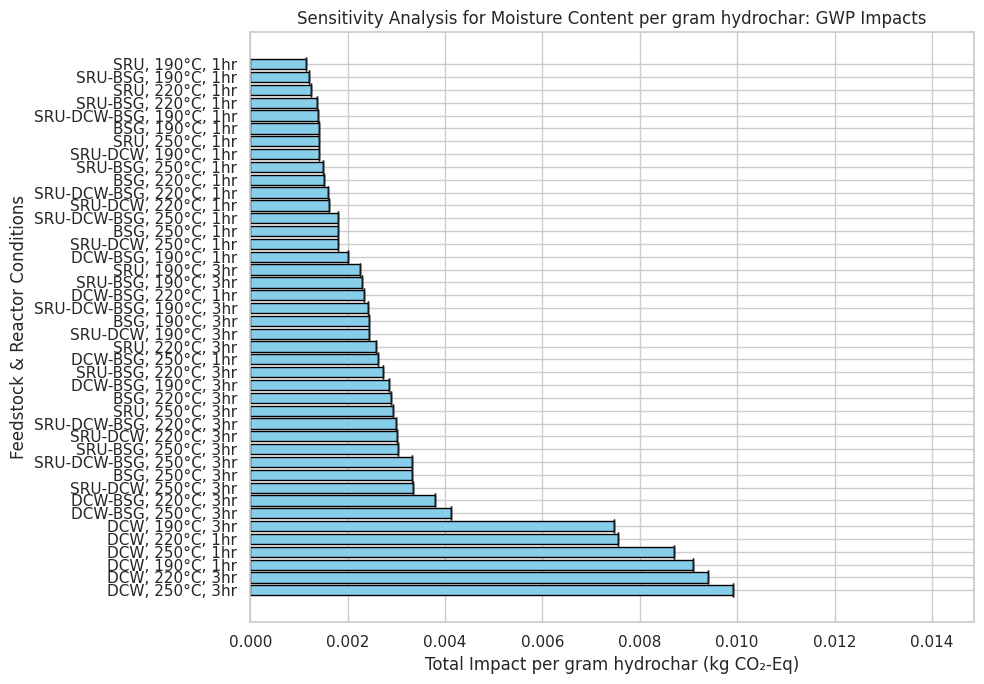

In [ ]:
hydrochar_lcia_list = [hc for attr, lcia in baseline_lcia_manager.__dict__.items() for hc in lcia]
plot_summary(hydrochar_lcia_list, 'gram hydrochar', 'Moisture Content')


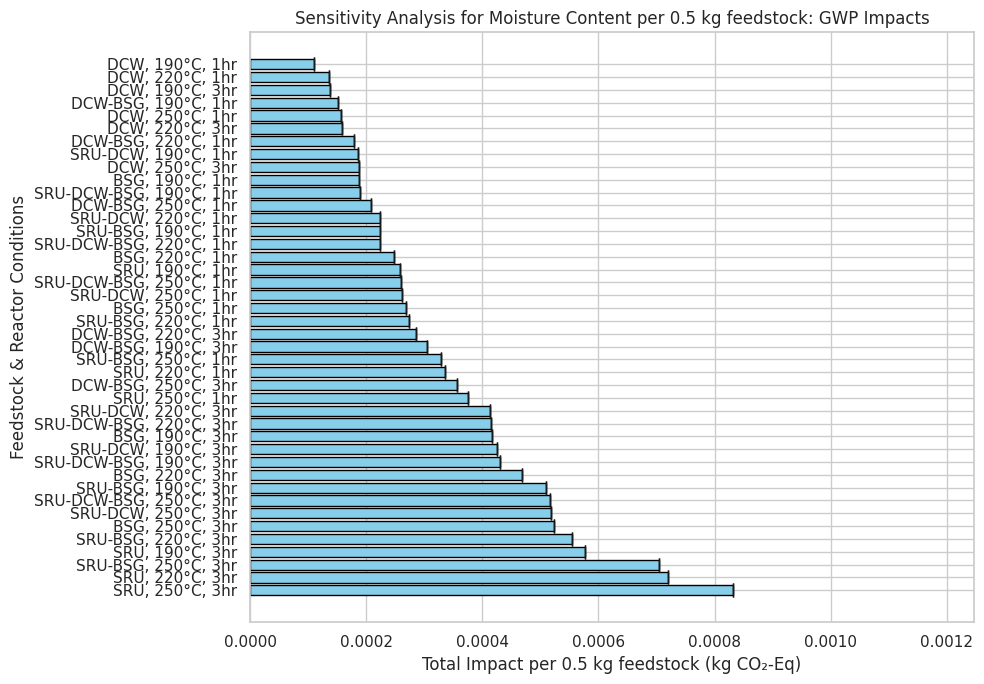

In [ ]:
feedstock_lcia_list = [hc for attr, lcia in feedstock_lcia_manager.__dict__.items() for hc in lcia]
plot_summary(feedstock_lcia_list, 'gram feedstock', 'Moisture Content')

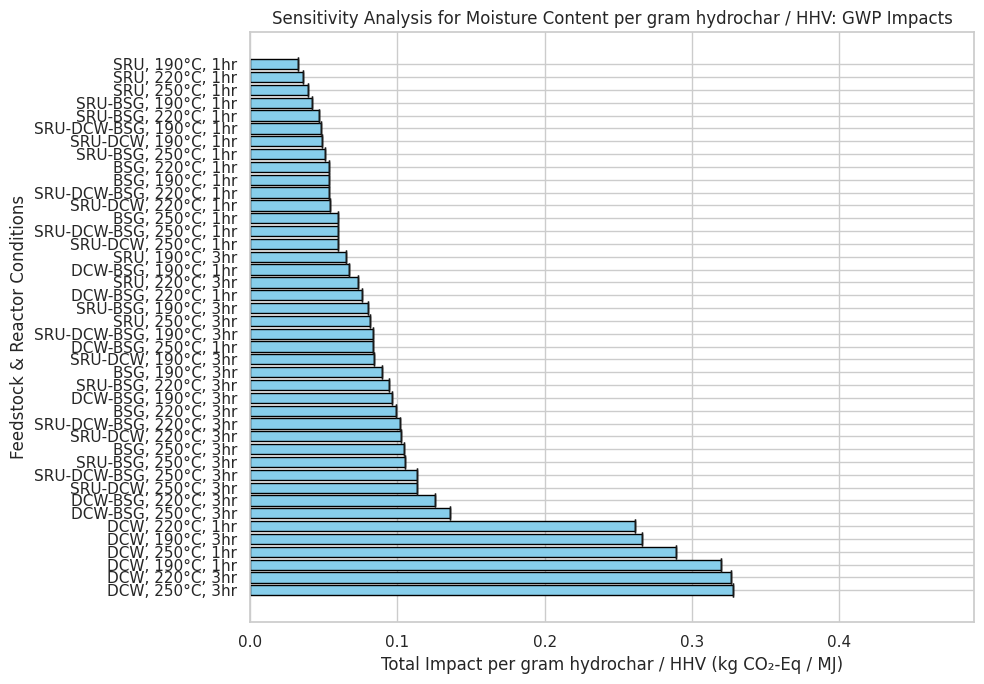

In [ ]:
hc_hhv_lcia_list = [hc for attr, lcia in hc_hhv_lcia_manager.__dict__.items() for hc in lcia]
plot_summary(hc_hhv_lcia_list, 'gram hydrochar / HHV', 'Moisture Content')

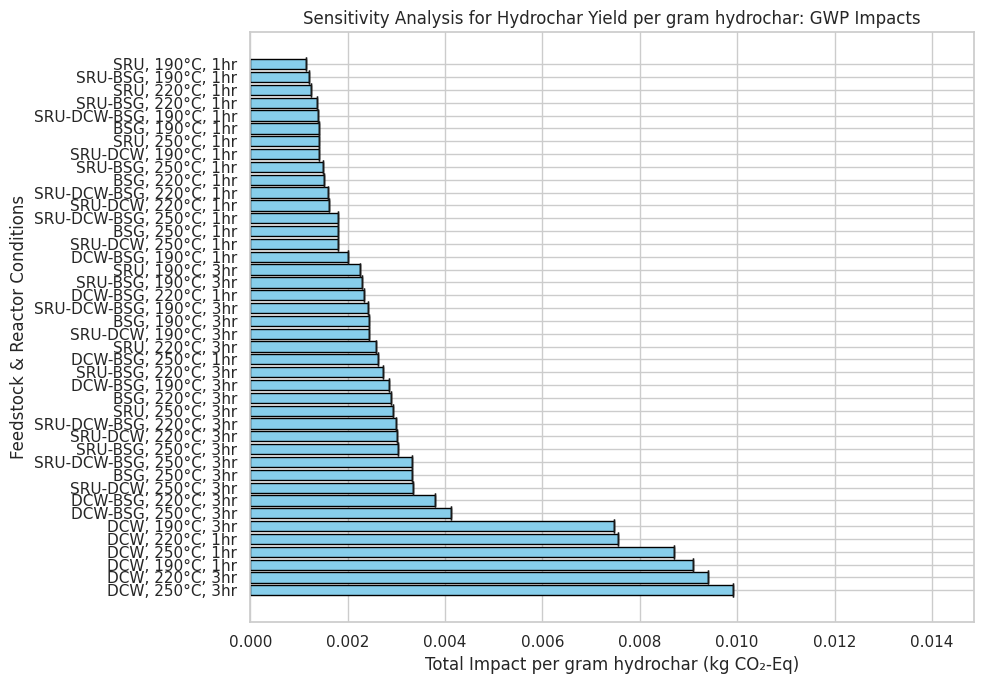

In [ ]:
hydrochar_lcia_list = [hc for attr, lcia in baseline_lcia_manager.__dict__.items() for hc in lcia]
plot_summary(hydrochar_lcia_list, 'gram hydrochar', 'Hydrochar Yield')

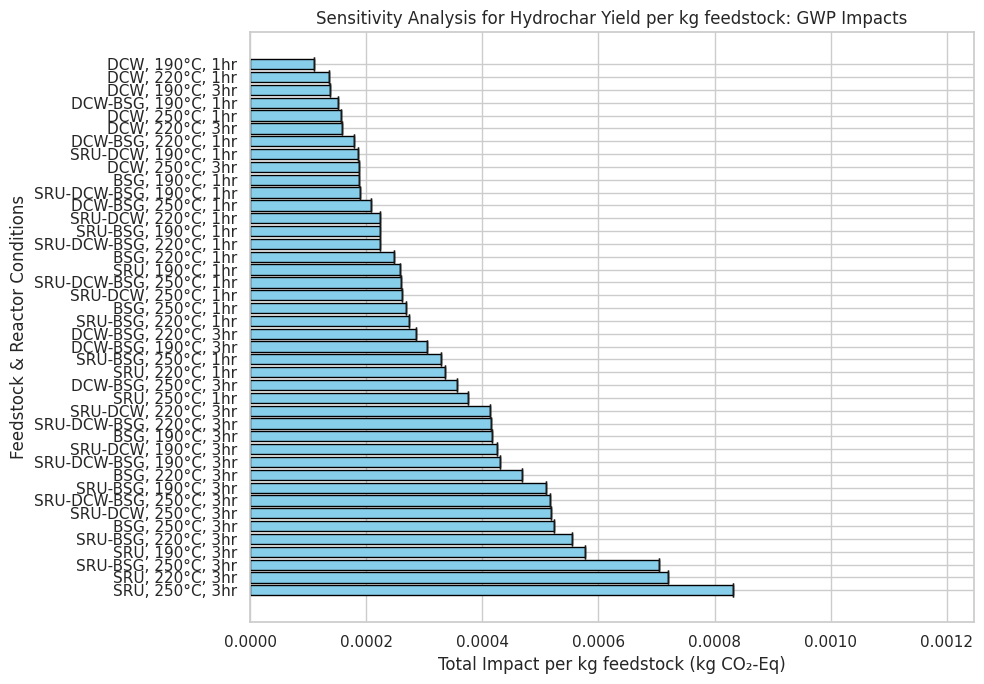

In [ ]:
feedstock_lcia_list = [hc for attr, lcia in feedstock_lcia_manager.__dict__.items() for hc in lcia]
plot_summary(feedstock_lcia_list, 'gram feedstock', 'Hydrochar Yield')

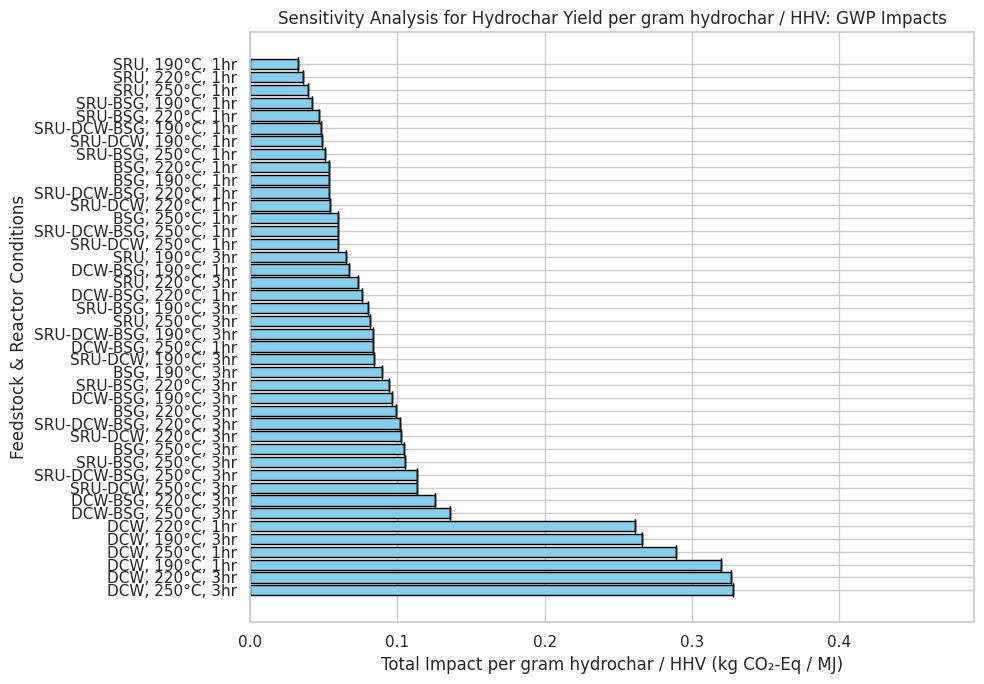

In [ ]:
hc_hhv_lcia_list = [hc for attr, lcia in hc_hhv_lcia_manager.__dict__.items() for hc in lcia]
plot_summary(hc_hhv_lcia_list, 'gram hydrochar / HHV', 'Hydrochar Yield')

### 5.3: Monte Carlo Simulation 
Although not utilized, a Monte Carlo simulation was set up to focus on the 'deterministic model' of the HTC process. Although there are uncertainties related to the outputs of HTC— such as hydrochar yield, gas yield, process water yield, and hydrochar characteristics — the primary goal of this Monte Carlo simulation is to examine how variability in feedstock characteristics and reaction conditions influence impact scores. 

A Monte Carlo simulation may address two key goals: (1) determining optimal reactor conditions, and (2) identifying efficient feedstocks. Since the original baseline LCIA results show consistency across all impact categories for the different process categories, the results from one impact category in this analysis are representative of all other indicators. In this case, the Monte Carlo simulation was set up for the climate change impact category. 

It should be noted that the Monte Carlo simulation will require the utilization of more resources. 

In [ ]:
# Creates a feedstock manager to store Monte Carlo feedstocks 
monte_carlo_feedstocks = FeedstockManager()

# Define a set to keep track of feedstock names we've already added
added_feedstock_names = set()

# Creating new original feedstocks 
original_feedstocks = create_elementary_feedstocks()

for attr, feedstocks in original_feedstocks.__dict__.items():
    for feedstock in feedstocks:
        # Select one feedstock of name rawDCW, stdBSG, stdSRU
        if any(feedstock.name.startswith(prefix) for prefix in ['rawDCW', 'stdBSG', 'stdSRU']):
            if feedstock.name not in added_feedstock_names:
                new_feedstock = copy.deepcopy(feedstock)
                new_feedstock.name = new_feedstock.name + '_mc'
                monte_carlo_feedstocks.add_feedstock(new_feedstock)
                added_feedstock_names.add(feedstock.name)

In [ ]:
mc_parameters = ParameterManager()

In [ ]:
def create_hydrochar_activity_mc(feedstock: Feedstock):
    '''Creates a hydrochar activity for a Monte Carlo simulation, given a feedstock'''
    feedstock.default_mc = feedstock.moisture
    temp = feedstock.temp
    time = feedstock.time 
    hydrochar_production = eidb.new_activity(
        code=f'HTC_{feedstock.name}',
        name=f"hydrochar production, {feedstock.name}",
        location='US',
        unit="kg"
    )
    yield_HC = get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'HC_yield')
    gas_yield = get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'gas_yield')
    project_data = [
        {
            'name': 'feedstock_' + f'HTC_{feedstock.name}', 
            'amount': get_feedstock_quantity(yield_HC, feedstock)
        }, 
        {
            'name': 'water_' + f'HTC_{feedstock.name}', 
            'amount': get_water_quantity(yield_HC, feedstock)
        }, 
        {
            'name': 'heat_' + f'HTC_{feedstock.name}', 
            'amount': get_heat_needed(feedstock, temp, time)
        },
        {
            'name': 'electricity_' + f'HTC_{feedstock.name}', 
            'amount': get_electricity_needed(feedstock, time, temp)
        }, 
        {
            'name': 'co2_' + f'HTC_{feedstock.name}',
            'amount': get_co2_emissions(yield_HC, gas_yield, feedstock)
        }, 
        {
            'name': 'wastewater_' + f'HTC_{feedstock.name}', 
            'amount': get_pw(yield_HC, gas_yield, feedstock, hc_placeholder=1)
        },
        {
            'name': 'post_processing_' + f'HTC_{feedstock.name}', 
            'amount': get_post_processing(hc_placeholder=1)
        }
    ]
    
    print(project_data)
    mc_parameters.new_project_parameters(project_data)
    
    # for param in ProjectParameter.select():
    #     print(param, param.amount)
    
    # Feedstock 
    hydrochar_production.new_exchange(input=('biosphere3', 'feedstock'), amount=0, unit="kg", type='custom', formula= 'feedstock')
    hydrochar_production.save()
                        
    # Water 
    water = [act for act in eidb if 'market for water, completely softened' in act['name']  and 'US' in act['location']][0]
    hydrochar_production.new_exchange(input=water.key, amount=0, unit="kilogram", type='technosphere', 
                                        formula= 'water_' + f'HTC_{feedstock.name}').save()
    hydrochar_production.save()
    
    # Electricity
    electricity = [act for act in eidb if 'market group for electricity, low voltage' in act['name']  and 'US' in act['location']][0]
    hydrochar_production.new_exchange(input=electricity.key, amount=0, unit="kilowatt hour", type='technosphere', 
                                        formula='electricity_' + f'HTC_{feedstock.name}').save()
    hydrochar_production.save()
    
    # Heat 
    electricity = [act for act in eidb if 'market group for electricity, low voltage' in act['name']  and 'US' in act['location']][0]
    hydrochar_production.new_exchange(input=electricity.key, amount=0, unit="kilowatt hour", type='technosphere', 
                                        formula='heat_' + f'HTC_{feedstock.name}').save()
    hydrochar_production.save()
    
    # CO2 Emissions
    co2 = [flow for flow in biosphere3 if 'carbon dioxide, non-fossil, resource correction' in flow['name'].lower()][1]
    hydrochar_production.new_exchange(input=co2.key, amount=0, unit="kilogram", type='biosphere', 
                                        formula='-1*co2_' + f'HTC_{feedstock.name}').save()
    hydrochar_production.save()
    
    # Wastewater 
    wastewater = [act for act in eidb if 'treatment of wastewater, average, wastewater treatment' in act['name']  and 'RoW' in act['location']][0]
    hydrochar_production.new_exchange(input=wastewater.key, amount=0, unit="cubic meter", type='technosphere', 
                                        formula='-1*wastewater_' + f'HTC_{feedstock.name}/1000').save()
    hydrochar_production.save()
    
    # Post-Processing
    electricity = [act for act in eidb if 'market group for electricity, low voltage' in act['name']  and 'US' in act['location']][0]
    hydrochar_production.new_exchange(input=electricity.key, amount=0, unit="kilowatt hour", type='technosphere', 
                                        formula='post_processing_' + f'HTC_{feedstock.name}').save()
    hydrochar_production.save()
    
    mc_parameters.add_exchanges_to_group(f"hydrochar production, {feedstock.name}", hydrochar_production)
    ActivityParameter.recalculate_exchanges(f"hydrochar production, {feedstock.name}")
    print()    

In [ ]:
# If needed, delete existing activities
for act in [act for act in eidb if 'hydrochar production' in act['name'] and '_mc' in act['name']]:
    act.delete()
    
for act in [act for act in eidb if 'hydrochar production' in act['name'] and '_mc' in act['name']]:
    print(act)

In [ ]:
# Creating HC activities that can be tweaked for a MC Analysis. 
for attr, feedstocks in monte_carlo_feedstocks.__dict__.items():
    for feedstock in feedstocks:
        print(feedstock)
        # print(get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'HC_yield'))
        create_hydrochar_activity_mc(feedstock)

In [ ]:
def monte_carlo_sample(feedstock, activity, method_key, time, temp, moisture, index):
    # Resetting Feedstock
    feedstock.moisture = moisture
    feedstock.time = time
    feedstock.temp = temp
    feedstock.quantity = 0 
    feedstock.water_added = 0 
    
    # Computing & Updating Exchanges of Interest
    yield_HC = get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'HC_yield')
    gas_yield = get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'gas_yield')
    
    updates = []
    
    for item in [item for item in ProjectParameter.select() if f'HTC_{feedstock.name}' in str(item)]:
        if item.name == 'feedstock_' + f'HTC_{feedstock.name}':
            item.amount = get_feedstock_quantity(yield_HC, feedstock)
        elif item.name == 'water_' + f'HTC_{feedstock.name}':
            item.amount = get_water_quantity(yield_HC, feedstock)
        elif item.name == 'heat_' + f'HTC_{feedstock.name}':
            item.amount = get_heat_needed(feedstock, temp, time)
        elif item.name == 'electricity_' + f'HTC_{feedstock.name}': 
            item.amount = get_electricity_needed(feedstock, time, temp)
        elif item.name == 'co2_' + f'HTC_{feedstock.name}':
            item.amount = get_co2_emissions(yield_HC, gas_yield, feedstock)
        elif item.name == 'wastewater_' + f'HTC_{feedstock.name}':
            item.amount = get_pw(yield_HC, gas_yield, feedstock, hc_placeholder=1)
        updates.append(item)
    
    ProjectParameter.bulk_update(updates, fields=['amount'])
    ActivityParameter.recalculate_exchanges(f"hydrochar production, {feedstock.name}")
    
    # Computing New LCA Results 
    functional_unit = {activity: 1e-3}
    lca = bw.LCA(functional_unit, method_key)
    lca.lci()
    lca.lcia()
    
    # Factoring in CO2
    co2_score = 0 
    for exc in [exc for exc in activity.exchanges() if 'Carbon dioxide' in str(exc.input)]:
        co2_score = exc.amount
    
    # Return result
    return {
        'feedstock_quantity': feedstock.quantity, 
        'moisture': moisture, 
        'temp': temp, 
        'time': time, 
        'climate_impact': lca.score + co2_score 
    }

def monte_carlo_gwp(feedstock, num_samples) -> list:
    method_key = [m for m in bw.methods if 'TRACI' in str(m) and 'global warming' in str(m)][0]

    # Discrete uniform variable time: (values: 1, 3) 
    time = np.random.choice([1, 3], size=num_samples)

    # Discrete uniform variable temp: (values: 190, 220, 250)
    temp = np.random.choice([190, 220, 250], size=num_samples)
    
    # Continuous uniform variable moisture_content 
    feedstock_mc_lower = feedstock.default_mc - (feedstock.moisture_std/100)
    feedstock_mc_upper = feedstock.default_mc + (feedstock.moisture_std/100)
    moisture = np.random.uniform(feedstock_mc_lower, feedstock_mc_upper, size=num_samples)

    # Selecting relevant activity 
    activity = [act for act in eidb if f"hydrochar production, {feedstock.name}" in act['name']][0]
    
    # Prepare arguments for parallel processing
    args = [(feedstock, activity, method_key, time[i], temp[i], moisture[i], i) for i in range(num_samples)]

    # Run simulations in parallel
    with mp.Pool(mp.cpu_count()) as pool:
        mc_results = list(tqdm(pool.imap_unordered(monte_carlo_sample, args), total=num_samples, desc=f"{feedstock.name} Monte Carlo simulation"))
    
    return mc_results

In [ ]:
def monte_carlo_gwp(feedstock, num_samples) -> list: 
    '''
    Computes a Monte Carlo simulation on a per feedstock basis. 
    Returns a list of length num_samples with the following elements for each iteration: feedstock.quantity, moisture, temp, time, lca.score
    '''
    # num_samples = 1000
    method_key = [m for m in bw.methods if 'TRACI' in str(m) and 'global warming' in str(m)][0]
    mc_results = []

    # Discrete uniform variable time: (values: 1, 3) 
    time = np.random.choice([1, 3], size=num_samples)

    # Discrete uniform variable temp: (values: 190, 220, 250)
    temp = np.random.choice([190, 220, 250], size=num_samples)
    
    # Continuous uniform variable moisture_content 
    feedstock_mc_lower = feedstock.default_mc - (feedstock.moisture_std/100)
    feedstock_mc_upper = feedstock.default_mc + (feedstock.moisture_std/100)
    moisture = np.random.uniform(feedstock_mc_lower, feedstock_mc_upper, size=num_samples)

    # Selecting relevant activity 
    activity = [act for act in eidb if f"hydrochar production, {feedstock.name}" in act['name']][0]

    for i in tqdm(range(num_samples), desc=f"{feedstock.name} Monte Carlo simulation"):
        
        # Resetting Feedstock 
        feedstock.moisture = moisture[i]
        feedstock.time = time[i]
        feedstock.temp = temp[i]
        feedstock.quantity = 0 
        feedstock.water_added = 0 
        
        # Computing & Updating Exchanges of Interest 
        yield_HC = get_parameter(f"hydrochar production, {feedstock.name}_{temp[i]}C_{time[i]}hr", 'HC_yield')
        gas_yield = get_parameter(f"hydrochar production, {feedstock.name}_{temp[i]}C_{time[i]}hr", 'gas_yield')
        
        updates = []
        
        for item in [item for item in ProjectParameter.select() if f'HTC_{feedstock.name}' in str(item)]:
            if item.name == 'feedstock_' + f'HTC_{feedstock.name}':
                item.amount = get_feedstock_quantity(yield_HC, feedstock)
                item.save()       
            elif item.name == 'water_' + f'HTC_{feedstock.name}':
                item.amount = get_water_quantity(yield_HC, feedstock)
                item.save()
            elif item.name == 'heat_' + f'HTC_{feedstock.name}':
                item.amount = get_heat_needed(feedstock, temp[i], time[i])
                item.save()
            elif item.name == 'electricity_' + f'HTC_{feedstock.name}': 
                item.amount = get_electricity_needed(feedstock, time[i], temp[i])
                item.save()
            elif item.name == 'co2_' + f'HTC_{feedstock.name}':
                item.amount = get_co2_emissions(yield_HC, gas_yield, feedstock)
                item.save()
            elif item.name == 'wastewater_' + f'HTC_{feedstock.name}':
                item.amount = get_pw(yield_HC, gas_yield, feedstock, hc_placeholder=1)
                item.save()
                mc_parameters.add_exchanges_to_group(f"hydrochar production, {feedstock.name}", activity)
            
            # Post-processing stays constant 
            updates.append(item)
        
        ProjectParameter.bulk_update(updates, fields=['amount'])
        ActivityParameter.recalculate_exchanges(f"hydrochar production, {feedstock.name}")
        activity.save()
            
        # Computing New LCA Results 
        functional_unit = {activity: 1e-3}
        lca = bw.LCA(functional_unit, method_key)
        lca.lci()
        lca.lcia()
        
        # Factoring in CO2
        co2_score = 0 
        for exc in [exc for exc in activity.exchanges() if 'Carbon dioxide' in str(exc.input)]:
            co2_score = exc.amount
            
        
        # Save results
        mc_results = []
        mc_results.append({
            'feedstock_quantity': feedstock.quantity, 
            'moisture': moisture, 
            'temp': temp, 
            'time': time, 
            'climate_impact': lca.score + co2_score 
        })
        # print()
        
    return mc_results                
    

In [ ]:
for attr, feedstocks in monte_carlo_feedstocks.__dict__.items():
    for feedstock in feedstocks:
        print('Running MC for', feedstock.name)
        feedstock.mc_results = monte_carlo_gwp(feedstock, 1000)